In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv("../../data/quarterly_data.csv", encoding = 'unicode_escape')

In [2]:
df.head(3)

Postal code  \
0  00100 Helsinki Keskusta - Etu-Töölö   (Helsinki )   
1  00100 Helsinki Keskusta - Etu-Töölö   (Helsinki )   
2  00100 Helsinki Keskusta - Etu-Töölö   (Helsinki )   

                       Building type 2010Q1 Price per square meter (EUR/m2)  \
0     Blocks of flats, one-room flat                                   5458   
1     Blocks of flats, two-room flat                                   5164   
2  Blocks of flats, three-room flat+                                   4944   

  2010Q2 Price per square meter (EUR/m2)  \
0                                   5347   
1                                   5021   
2                                   5396   

  2010Q3 Price per square meter (EUR/m2)  \
0                                   5826   
1                                   5081   
2                                   4828   

  2010Q4 Price per square meter (EUR/m2)  \
0                                   5566   
1                                   5006   
2                                   5394   

  2011Q1 Price per square meter (EUR/m2)  \
0                                   5545   
1                                   5713   
2                                   5571   

  2011Q2 Price per square meter (EUR/m2)  \
0                                   5812   
1                                   5866   
2                                   5709   

  2011Q3 Price per square meter (EUR/m2)  \
0                                   5909   
1                                   5552   
2                                   5450   

  2011Q4 Price per square meter (EUR/m2)  ...  \
0                                   5856  ...   
1                                   5614  ...   
2                                   5010  ...   

  2019Q1 Price per square meter (EUR/m2)  \
0                                   7755   
1                                   6914   
2                                   6883   

  2019Q2 Price per square meter (EUR/m2)  \
0                                   8332   
1                                   7694   
2                                   6846   

  2019Q3 Price per square meter (EUR/m2)  \
0                                   8130   
1                                   6901   
2                                   7379   

  2019Q4 Price per square meter (EUR/m2)  \
0                                   8068   
1                                   7435   
2                                   6728   

  2020Q1 Price per square meter (EUR/m2)  \
0                                   7802   
1                                   7573   
2                                   7205   

  2020Q2 Price per square meter (EUR/m2)  \
0                                   8543   
1                                   7398   
2                                   6678   

  2020Q3 Price per square meter (EUR/m2)  \
0                                   9170   
1                                   7868   
2                                   7178   

  2020Q4 Price per square meter (EUR/m2)  \
0                                   7517   
1                                   7700   
2                                   7405   

  2021Q1* Price per square meter (EUR/m2)  \
0                                    8872   
1                                    7829   
2                                    8053   

  2021Q2* Price per square meter (EUR/m2)  
0                                    8596  
1                                    7974  
2                                    8174  

[3 rows x 48 columns]

In [3]:
df_quartered = df.melt(id_vars=["Postal code", "Building type"],var_name="Quarter", value_name="EUR/m2")

In [4]:
### Regex to change quarters to datetime
import datetime as date

def quarter_to_datetime(row):
    dates = {"Q1": "1/1", "Q2":"1/4", "Q3":"1/7", "Q4":"1/10"}
    string = row.replace("*", "").split(" ")[0]
    year, quarter = string[:4], string[4:]
    datetime_str = dates[quarter] + "/" + year
    return date.datetime.strptime(datetime_str, '%d/%m/%Y')
    
    
df_quartered["Quarter"] = df_quartered["Quarter"].apply(lambda row: quarter_to_datetime(row))
df_quartered[['Postal code', 'Location']] = df_quartered['Postal code'].str.split(' ', 1, expand=True)

In [5]:
## Turn .. to NaN values 
df_quartered["EUR/m2"] = df_quartered["EUR/m2"].apply(pd.to_numeric, errors="coerce", downcast="integer")
df_quartered.head()

Postal code                      Building type    Quarter  EUR/m2  \
0       00100     Blocks of flats, one-room flat 2010-01-01  5458.0   
1       00100     Blocks of flats, two-room flat 2010-01-01  5164.0   
2       00100  Blocks of flats, three-room flat+ 2010-01-01  4944.0   
3       00100              Blocks of flats total 2010-01-01  5168.0   
4       00100              Terraced houses total 2010-01-01     NaN   

                                      Location  
0  Helsinki Keskusta - Etu-Töölö   (Helsinki )  
1  Helsinki Keskusta - Etu-Töölö   (Helsinki )  
2  Helsinki Keskusta - Etu-Töölö   (Helsinki )  
3  Helsinki Keskusta - Etu-Töölö   (Helsinki )  
4  Helsinki Keskusta - Etu-Töölö   (Helsinki )

In [6]:
def filter_building_type(data, building_type):
    return data[data["Building type"].isin([building_type])].reset_index(drop=True)

df_copy = df_quartered.copy()
one_room = filter_building_type(df_copy, "Blocks of flats total")

In [7]:
## Pivoting for KNN

one_room_pivot = one_room.pivot(index="Quarter", columns="Postal code", values="EUR/m2")

In [8]:
def split_dataframe_by_missing_cells_in_postalcodes(df, perc):
    
    def filter_missing_cells_by_percentage(df, perc):
        min_count =  int(((100-perc)/100)*df.shape[0] + 1)
        over_perc_cells = df.dropna(axis=1, thresh=min_count)
        return over_perc_cells

    def find_missing_cells(df, columns):
        missing_columns = set(df.columns) - set(columns)
        return df[missing_columns]


    df_percentage = filter_missing_cells_by_percentage(df, percentage)
    df_percentage_columns = df_percentage.columns

    df_missing = find_missing_cells(df, df_percentage_columns)
    df_missing_columns = df_missing.columns
    
    return df_percentage, df_percentage_columns, df_missing, df_missing_columns

In [9]:
# Split datasets to 

percentage = 40
df_p, df_p_col, df_m, df_m_col = split_dataframe_by_missing_cells_in_postalcodes(one_room_pivot, percentage)

# Prophet for df_p which has samples missing under percentage value

In [10]:
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.impute import KNNImputer

def knn_imputation_for_data(data):
        num_columns = list(data.columns)
        num_columns.remove("Quarter")

        quarter = data["Quarter"]
        numeral = data[num_columns]
        imputer = KNNImputer(n_neighbors=5)
        knn_imputed = imputer.fit_transform(numeral)
        data_imp = pd.DataFrame(knn_imputed, columns=num_columns)
        data_imp["Quarter"] = quarter
        return data_imp

def train_test_split(data):
    train = data[:-4].reset_index()
    test = data[-4:].reset_index()
    return train, test


def remove_nan_from_test(test, forecast):
    print(test)
    test = list(test["y"])
    forecast = list(forecast["yhat"])
    new_test = []
    new_forecast = []
    for i in range(len(test)):
        if not math.isnan(test[i]):
            print(test[i])
            new_test.append(test[i])
            new_forecast.append(forecast[i])
    return new_test, new_forecast



def train_and_test_prophet(data, pc):     
    
    train, test = train_test_split(data)
    train_imp = knn_imputation_for_data(train)
    
    df_train = train_imp[[pc, "Quarter"]].rename(columns={pc:"y","Quarter":"ds"})
    df_test = test[[pc, "Quarter"]].rename(columns={pc:"y","Quarter":"ds"})
    try:
        prop = Prophet(interval_width=0.95)
        prop.fit(df_train)
        forecast = prop.predict(df_test)
        new_test, new_forecast = remove_nan_from_test(df_test, forecast)
        mae = mean_absolute_error(new_test, new_forecast)
        rmse = math.sqrt(mean_squared_error(new_test, new_forecast))
        return mae, rmse
    except:
        return -1,-1

### Results for postal code which is missing under 40% of its values


In [11]:
mae_list = []
rmse_list = []
for col in df_p_col:
    mae, rmse = train_and_test_prophet(df_p, col)
    mae_list.append(mae)
    rmse_list.append(rmse)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -52.7935
Iteration  1. Log joint probability =     81.067. Improved by 133.86.
Iteration  2. Log joint probability =    105.143. Improved by 24.076.
Iteration  3. Log joint probability =    113.938. Improved by 8.79479.
Iteration  4. Log joint probability =    114.836. Improved by 0.897786.
Iteration  5. Log joint probability =    115.207. Improved by 0.371794.
Iteration  6. Log joint probability =    115.298. Improved by 0.0902768.
Iteration  7. Log joint probability =    115.375. Improved by 0.0774581.
Iteration  8. Log joint probability =    115.429. Improved by 0.0543558.
Iteration  9. Log joint probability =    115.493. Improved by 0.0630725.
Iteration 10. Log joint probability =    115.541. Improved by 0.0485879.
Iteration 11. Log joint probability =    115.654. Improved by 0.112801.
Iteration 12. Log joint probability =    115.717. Improved by 0.0631605.
Iteration 13. Log joint probability =    115.798. Improved by 0.0806127.
Iteration 14. Log jo

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            8058.0 2020-07-01
1            7540.0 2020-10-01
2            8188.0 2021-01-01
3            8188.0 2021-04-01
8058.0
7540.0
8188.0
8188.0

Initial log joint probability = -52.8281
Iteration  1. Log joint probability =    54.6097. Improved by 107.438.
Iteration  2. Log joint probability =    68.5585. Improved by 13.9488.
Iteration  3. Log joint probability =    101.371. Improved by 32.8125.
Iteration  4. Log joint probability =    112.488. Improved by 11.1169.
Iteration  5. Log joint probability =    126.616. Improved by 14.1283.
Iteration  6. Log joint probability =    126.712. Improved by 0.0954232.
Iteration  7. Log joint probability =    126.745. Improved by 0.0332806.
Iteration  8. Log joint probability =    126.823. Improved by 0.0778208.
Iteration  9. Log joint probability =    126.892. Improved by 0.0690258.
Iteration 10. Log joint probability =    127.006. Improved by 0.114414.
Iteration 11. Log joint probability =    127.269. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            8393.0 2020-07-01
1               NaN 2020-10-01
2               NaN 2021-01-01
3               NaN 2021-04-01
8393.0

Initial log joint probability = -52.832
Iteration  1. Log joint probability =    54.4565. Improved by 107.288.
Iteration  2. Log joint probability =    67.8224. Improved by 13.366.
Iteration  3. Log joint probability =     99.931. Improved by 32.1085.
Iteration  4. Log joint probability =    103.444. Improved by 3.5128.
Iteration  5. Log joint probability =    103.467. Improved by 0.0233503.
Iteration  6. Log joint probability =    103.534. Improved by 0.0663892.
Iteration  7. Log joint probability =     103.63. Improved by 0.0960384.
Iteration  8. Log joint probability =    103.728. Improved by 0.0981439.
Iteration  9. Log joint probability =    103.898. Improved by 0.169879.
Iteration 10. Log joint probability =    103.924. Improved by 0.0262868.
Iteration 11. Log joint probability =    103.968. Improved by 0.0441382.
Itera

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            8359.0 2020-07-01
1            6706.0 2020-10-01
2            9639.0 2021-01-01
3            9986.0 2021-04-01
8359.0
6706.0
9639.0
9986.0

Initial log joint probability = -52.805
Iteration  1. Log joint probability =    55.5444. Improved by 108.349.
Iteration  2. Log joint probability =    82.4102. Improved by 26.8657.
Iteration  3. Log joint probability =    104.577. Improved by 22.167.
Iteration  4. Log joint probability =    120.374. Improved by 15.7971.
Iteration  5. Log joint probability =    125.423. Improved by 5.04825.
Iteration  6. Log joint probability =    125.471. Improved by 0.048022.
Iteration  7. Log joint probability =    125.554. Improved by 0.0836592.
Iteration  8. Log joint probability =    125.651. Improved by 0.0972535.
Iteration  9. Log joint probability =    125.787. Improved by 0.135662.
Iteration 10. Log joint probability =    125.897. Improved by 0.109682.
Iteration 11. Log joint probability =    126.071. Improved b

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0               NaN 2020-07-01
1            8898.0 2020-10-01
2            9049.0 2021-01-01
3               NaN 2021-04-01
8898.0
9049.0

Initial log joint probability = -52.7676
Iteration  1. Log joint probability =    99.8344. Improved by 152.602.
Iteration  2. Log joint probability =    121.543. Improved by 21.7085.
Iteration  3. Log joint probability =    138.626. Improved by 17.0834.
Iteration  4. Log joint probability =    141.543. Improved by 2.91667.
Iteration  5. Log joint probability =    141.555. Improved by 0.0124637.
Iteration  6. Log joint probability =     141.65. Improved by 0.0950682.
Iteration  7. Log joint probability =    141.684. Improved by 0.0330984.
Iteration  8. Log joint probability =     143.54. Improved by 1.85611.
Iteration  9. Log joint probability =    143.579. Improved by 0.0389678.
Iteration 10. Log joint probability =    143.604. Improved by 0.0249022.
Iteration 11. Log joint probability =    143.755. Improved by 0.15101

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            8577.0 2020-07-01
1            8529.0 2020-10-01
2            8959.0 2021-01-01
3            9197.0 2021-04-01
8577.0
8529.0
8959.0
9197.0

Initial log joint probability = -52.9907
Iteration  1. Log joint probability =    43.1484. Improved by 96.139.
Iteration  2. Log joint probability =    69.3231. Improved by 26.1747.
Iteration  3. Log joint probability =    92.0772. Improved by 22.7542.
Iteration  4. Log joint probability =    92.1173. Improved by 0.0400271.
Iteration  5. Log joint probability =    92.1227. Improved by 0.00540142.
Iteration  6. Log joint probability =    100.214. Improved by 8.09111.
Iteration  7. Log joint probability =    101.379. Improved by 1.1655.
Iteration  8. Log joint probability =    107.939. Improved by 6.55928.
Iteration  9. Log joint probability =    107.978. Improved by 0.0394505.
Iteration 10. Log joint probability =    109.002. Improved by 1.02354.
Iteration 11. Log joint probability =    109.405. Improved b

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            7715.0 2020-07-01
1            7688.0 2020-10-01
2            8025.0 2021-01-01
3            7658.0 2021-04-01
7715.0
7688.0
8025.0
7658.0

Initial log joint probability = -52.7726
Iteration  1. Log joint probability =    66.3849. Improved by 119.158.
Iteration  2. Log joint probability =    119.821. Improved by 53.4365.
Iteration  3. Log joint probability =    119.861. Improved by 0.0395655.
Iteration  4. Log joint probability =    120.244. Improved by 0.383224.
Iteration  5. Log joint probability =    128.021. Improved by 7.77658.
Iteration  6. Log joint probability =    128.355. Improved by 0.334148.
Iteration  7. Log joint probability =    132.343. Improved by 3.98848.
Iteration  8. Log joint probability =    132.447. Improved by 0.10335.
Iteration  9. Log joint probability =     132.56. Improved by 0.113047.
Iteration 10. Log joint probability =    132.984. Improved by 0.424434.
Iteration 11. Log joint probability =    133.052. Improved 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            7818.0 2020-07-01
1            8142.0 2020-10-01
2            8076.0 2021-01-01
3            8035.0 2021-04-01
7818.0
8142.0
8076.0
8035.0

Initial log joint probability = -52.8199
Iteration  1. Log joint probability =     54.966. Improved by 107.786.
Iteration  2. Log joint probability =    80.6519. Improved by 25.686.
Iteration  3. Log joint probability =    91.1795. Improved by 10.5276.
Iteration  4. Log joint probability =    105.338. Improved by 14.1582.
Iteration  5. Log joint probability =    114.925. Improved by 9.58692.
Iteration  6. Log joint probability =     115.19. Improved by 0.265714.
Iteration  7. Log joint probability =    126.646. Improved by 11.4561.
Iteration  8. Log joint probability =    126.715. Improved by 0.0687284.
Iteration  9. Log joint probability =    127.025. Improved by 0.309728.
Iteration 10. Log joint probability =    127.101. Improved by 0.0756429.
Iteration 11. Log joint probability =     127.29. Improved b

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0               NaN 2020-07-01
1               NaN 2020-10-01
2            8294.0 2021-01-01
3               NaN 2021-04-01
8294.0

Initial log joint probability = -52.7764
Iteration  1. Log joint probability =    49.8524. Improved by 102.629.
Iteration  2. Log joint probability =    116.289. Improved by 66.4361.
Iteration  3. Log joint probability =    116.326. Improved by 0.0379514.
Iteration  4. Log joint probability =    116.362. Improved by 0.0360067.
Iteration  5. Log joint probability =    116.385. Improved by 0.0223755.
Iteration  6. Log joint probability =     116.72. Improved by 0.334823.
Iteration  7. Log joint probability =     121.18. Improved by 4.46001.
Iteration  8. Log joint probability =    130.444. Improved by 9.26388.
Iteration  9. Log joint probability =    130.457. Improved by 0.0132628.
Iteration 10. Log joint probability =    130.469. Improved by 0.012336.
Iteration 11. Log joint probability =    130.638. Improved by 0.168636.
Iter

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0               NaN 2020-07-01
1            6811.0 2020-10-01
2            6578.0 2021-01-01
3               NaN 2021-04-01
6811.0
6578.0

Initial log joint probability = -52.8225
Iteration  1. Log joint probability =    54.7918. Improved by 107.614.
Iteration  2. Log joint probability =    84.7329. Improved by 29.9411.
Iteration  3. Log joint probability =    103.693. Improved by 18.9604.
Iteration  4. Log joint probability =    104.836. Improved by 1.1422.
Iteration  5. Log joint probability =    107.161. Improved by 2.32582.
Iteration  6. Log joint probability =      107.2. Improved by 0.0387687.
Iteration  7. Log joint probability =    107.242. Improved by 0.041693.
Iteration  8. Log joint probability =    107.336. Improved by 0.0942515.
Iteration  9. Log joint probability =    107.422. Improved by 0.085609.
Iteration 10. Log joint probability =    107.473. Improved by 0.0513048.
Iteration 11. Log joint probability =    107.707. Improved by 0.233938.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            5504.0 2020-07-01
1            5049.0 2020-10-01
2            5131.0 2021-01-01
3            5699.0 2021-04-01
5504.0
5049.0
5131.0
5699.0

Initial log joint probability = -52.782
Iteration  1. Log joint probability =    56.4747. Improved by 109.257.
Iteration  2. Log joint probability =    85.3303. Improved by 28.8556.
Iteration  3. Log joint probability =    96.4201. Improved by 11.0898.
Iteration  4. Log joint probability =    139.802. Improved by 43.3821.
Iteration  5. Log joint probability =    147.251. Improved by 7.44915.
Iteration  6. Log joint probability =    147.274. Improved by 0.0228669.
Iteration  7. Log joint probability =    147.294. Improved by 0.0194235.
Iteration  8. Log joint probability =    147.315. Improved by 0.0211559.
Iteration  9. Log joint probability =    147.325. Improved by 0.0102975.
Iteration 10. Log joint probability =     147.41. Improved by 0.0849867.
Iteration 11. Log joint probability =    147.474. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            6944.0 2020-07-01
1            6826.0 2020-10-01
2            7274.0 2021-01-01
3            7443.0 2021-04-01
6944.0
6826.0
7274.0
7443.0

Initial log joint probability = -52.8027
Iteration  1. Log joint probability =    55.6602. Improved by 108.463.
Iteration  2. Log joint probability =    83.1795. Improved by 27.5194.
Iteration  3. Log joint probability =    107.796. Improved by 24.6164.
Iteration  4. Log joint probability =    123.913. Improved by 16.1168.
Iteration  5. Log joint probability =    126.539. Improved by 2.62587.
Iteration  6. Log joint probability =    127.445. Improved by 0.906771.
Iteration  7. Log joint probability =    127.478. Improved by 0.0326558.
Iteration  8. Log joint probability =    127.518. Improved by 0.0400014.
Iteration  9. Log joint probability =    127.527. Improved by 0.00896917.
Iteration 10. Log joint probability =    127.531. Improved by 0.00438714.
Iteration 11. Log joint probability =    127.555. Impr

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            7047.0 2020-07-01
1            7506.0 2020-10-01
2            7849.0 2021-01-01
3            7903.0 2021-04-01
7047.0
7506.0
7849.0
7903.0

Initial log joint probability = -52.7956
Iteration  1. Log joint probability =    55.9627. Improved by 108.758.
Iteration  2. Log joint probability =    83.8832. Improved by 27.9205.
Iteration  3. Log joint probability =    107.737. Improved by 23.8533.
Iteration  4. Log joint probability =    133.261. Improved by 25.524.
Iteration  5. Log joint probability =    139.567. Improved by 6.3061.
Iteration  6. Log joint probability =    139.579. Improved by 0.0119056.
Iteration  7. Log joint probability =    139.631. Improved by 0.0525299.
Iteration  8. Log joint probability =    139.786. Improved by 0.155295.
Iteration  9. Log joint probability =     139.87. Improved by 0.083634.
Iteration 10. Log joint probability =    139.931. Improved by 0.0608522.
Iteration 11. Log joint probability =    140.057. Improved 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            6805.0 2020-07-01
1            6521.0 2020-10-01
2            6942.0 2021-01-01
3            6549.0 2021-04-01
6805.0
6521.0
6942.0
6549.0

Initial log joint probability = -52.7817
Iteration  1. Log joint probability =    28.3047. Improved by 81.0864.
Iteration  2. Log joint probability =    98.4271. Improved by 70.1224.
Iteration  3. Log joint probability =    98.4554. Improved by 0.0282754.
Iteration  4. Log joint probability =    98.4713. Improved by 0.0158958.
Iteration  5. Log joint probability =    98.5205. Improved by 0.0492332.
Iteration  6. Log joint probability =    111.399. Improved by 12.8788.
Iteration  7. Log joint probability =    111.439. Improved by 0.0392646.
Iteration  8. Log joint probability =    111.476. Improved by 0.0376236.
Iteration  9. Log joint probability =    112.365. Improved by 0.889213.
Iteration 10. Log joint probability =    112.395. Improved by 0.0300804.
Iteration 11. Log joint probability =    112.653. Im

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            6676.0 2020-07-01
1            6235.0 2020-10-01
2            5984.0 2021-01-01
3            6597.0 2021-04-01
6676.0
6235.0
5984.0
6597.0

Initial log joint probability = -52.8003
Iteration  1. Log joint probability =    2.90732. Improved by 55.7076.
Iteration  2. Log joint probability =    89.3394. Improved by 86.4321.
Iteration  3. Log joint probability =    89.3412. Improved by 0.00174823.
Iteration  4. Log joint probability =    89.3503. Improved by 0.00908967.
Iteration  5. Log joint probability =    89.3959. Improved by 0.0456599.
Iteration  6. Log joint probability =    108.672. Improved by 19.2765.
Iteration  7. Log joint probability =    108.766. Improved by 0.0936614.
Iteration  8. Log joint probability =     108.77. Improved by 0.00403784.
Iteration  9. Log joint probability =    108.857. Improved by 0.0869573.
Iteration 10. Log joint probability =    108.896. Improved by 0.0392683.
Iteration 11. Log joint probability =      108.9

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            4539.0 2020-07-01
1            4577.0 2020-10-01
2            4631.0 2021-01-01
3            4979.0 2021-04-01
4539.0
4577.0
4631.0
4979.0

Initial log joint probability = -52.8355
Iteration  1. Log joint probability =    54.4061. Improved by 107.242.
Iteration  2. Log joint probability =     80.489. Improved by 26.0829.
Iteration  3. Log joint probability =    105.921. Improved by 25.4316.
Iteration  4. Log joint probability =    111.698. Improved by 5.77758.
Iteration  5. Log joint probability =    113.898. Improved by 2.20028.
Iteration  6. Log joint probability =    114.848. Improved by 0.949699.
Iteration  7. Log joint probability =    114.896. Improved by 0.0475602.
Iteration  8. Log joint probability =    114.933. Improved by 0.0368891.
Iteration  9. Log joint probability =    114.979. Improved by 0.0462935.
Iteration 10. Log joint probability =    115.044. Improved by 0.0653824.
Iteration 11. Log joint probability =    115.116. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            5414.0 2020-07-01
1            4815.0 2020-10-01
2               NaN 2021-01-01
3            5716.0 2021-04-01
5414.0
4815.0
5716.0

Initial log joint probability = -52.7916
Iteration  1. Log joint probability =    3.10944. Improved by 55.9011.
Iteration  2. Log joint probability =    70.9764. Improved by 67.8669.
Iteration  3. Log joint probability =    71.0249. Improved by 0.0485812.
Iteration  4. Log joint probability =    71.0749. Improved by 0.0499879.
Iteration  5. Log joint probability =    71.1316. Improved by 0.0566823.
Iteration  6. Log joint probability =    71.2683. Improved by 0.136686.
Iteration  7. Log joint probability =     71.487. Improved by 0.218711.
Iteration  8. Log joint probability =    71.7674. Improved by 0.280365.
Iteration  9. Log joint probability =    72.1417. Improved by 0.374298.
Iteration 10. Log joint probability =    72.4323. Improved by 0.290582.
Iteration 11. Log joint probability =       72.8. Improved by

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            4524.0 2020-07-01
1            4394.0 2020-10-01
2            4308.0 2021-01-01
3            4899.0 2021-04-01
4524.0
4394.0
4308.0
4899.0

Initial log joint probability = -52.821
Iteration  1. Log joint probability =    55.0264. Improved by 107.847.
Iteration  2. Log joint probability =    81.4049. Improved by 26.3786.
Iteration  3. Log joint probability =    101.585. Improved by 20.1803.
Iteration  4. Log joint probability =    121.347. Improved by 19.7617.
Iteration  5. Log joint probability =    124.835. Improved by 3.48803.
Iteration  6. Log joint probability =    126.464. Improved by 1.62945.
Iteration  7. Log joint probability =    126.547. Improved by 0.0823558.
Iteration  8. Log joint probability =    126.565. Improved by 0.0183234.
Iteration  9. Log joint probability =    126.574. Improved by 0.0092025.
Iteration 10. Log joint probability =    126.655. Improved by 0.0809626.
Iteration 11. Log joint probability =    126.675. Improved

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3780.0 2020-07-01
1            3997.0 2020-10-01
2               NaN 2021-01-01
3               NaN 2021-04-01
3780.0
3997.0

Initial log joint probability = -52.7864
Iteration  1. Log joint probability =    56.3039. Improved by 109.09.
Iteration  2. Log joint probability =    84.5662. Improved by 28.2624.
Iteration  3. Log joint probability =     88.907. Improved by 4.34076.
Iteration  4. Log joint probability =    121.493. Improved by 32.5864.
Iteration  5. Log joint probability =    141.792. Improved by 20.2983.
Iteration  6. Log joint probability =    141.792. Improved by 0.000301361.
Iteration  7. Log joint probability =    141.817. Improved by 0.0246277.
Iteration  8. Log joint probability =    141.945. Improved by 0.128714.
Iteration  9. Log joint probability =    141.968. Improved by 0.0223731.
Iteration 10. Log joint probability =    142.001. Improved by 0.0330499.
Iteration 11. Log joint probability =    144.978. Improved by 2.97774

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            6799.0 2020-07-01
1            6648.0 2020-10-01
2            7013.0 2021-01-01
3            7098.0 2021-04-01
6799.0
6648.0
7013.0
7098.0

Initial log joint probability = -52.7914
Iteration  1. Log joint probability =    56.0896. Improved by 108.881.
Iteration  2. Log joint probability =    83.9825. Improved by 27.8929.
Iteration  3. Log joint probability =    88.8143. Improved by 4.83184.
Iteration  4. Log joint probability =    119.832. Improved by 31.0178.
Iteration  5. Log joint probability =    124.482. Improved by 4.65002.
Iteration  6. Log joint probability =    124.682. Improved by 0.199806.
Iteration  7. Log joint probability =    124.952. Improved by 0.26962.
Iteration  8. Log joint probability =    125.415. Improved by 0.463291.
Iteration  9. Log joint probability =     125.44. Improved by 0.0249403.
Iteration 10. Log joint probability =    126.544. Improved by 1.10381.
Iteration 11. Log joint probability =    126.621. Improved by

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            6654.0 2020-07-01
1            6821.0 2020-10-01
2            6660.0 2021-01-01
3            7257.0 2021-04-01
6654.0
6821.0
6660.0
7257.0

Initial log joint probability = -52.7986
Iteration  1. Log joint probability =    55.7944. Improved by 108.593.
Iteration  2. Log joint probability =    87.1613. Improved by 31.3669.
Iteration  3. Log joint probability =    87.6986. Improved by 0.53738.
Iteration  4. Log joint probability =    96.0784. Improved by 8.37974.
Iteration  5. Log joint probability =    107.451. Improved by 11.373.
Iteration  6. Log joint probability =    114.158. Improved by 6.70685.
Iteration  7. Log joint probability =    114.195. Improved by 0.0366019.
Iteration  8. Log joint probability =    114.491. Improved by 0.296444.
Iteration  9. Log joint probability =    114.648. Improved by 0.156781.
Iteration 10. Log joint probability =    114.667. Improved by 0.0189473.
Iteration 11. Log joint probability =    114.932. Improved b

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            5638.0 2020-07-01
1            5668.0 2020-10-01
2            5673.0 2021-01-01
3            6282.0 2021-04-01
5638.0
5668.0
5673.0
6282.0

Initial log joint probability = -52.7678
Iteration  1. Log joint probability =    77.0992. Improved by 129.867.
Iteration  2. Log joint probability =    123.053. Improved by 45.9542.
Iteration  3. Log joint probability =    128.283. Improved by 5.22961.
Iteration  4. Log joint probability =    128.333. Improved by 0.0504612.
Iteration  5. Log joint probability =    128.379. Improved by 0.0456399.
Iteration  6. Log joint probability =    128.785. Improved by 0.405947.
Iteration  7. Log joint probability =    130.079. Improved by 1.29446.
Iteration  8. Log joint probability =    130.096. Improved by 0.0164665.
Iteration  9. Log joint probability =    130.724. Improved by 0.627992.
Iteration 10. Log joint probability =     131.16. Improved by 0.435574.
Iteration 11. Log joint probability =    131.652. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            6964.0 2020-07-01
1            6701.0 2020-10-01
2            6738.0 2021-01-01
3            7051.0 2021-04-01
6964.0
6701.0
6738.0
7051.0

Initial log joint probability = -52.8841
Iteration  1. Log joint probability =    52.2589. Improved by 105.143.
Iteration  2. Log joint probability =    80.6858. Improved by 28.4269.
Iteration  3. Log joint probability =    105.585. Improved by 24.899.
Iteration  4. Log joint probability =    112.186. Improved by 6.60126.
Iteration  5. Log joint probability =    112.832. Improved by 0.646117.
Iteration  6. Log joint probability =    112.841. Improved by 0.0085194.
Iteration  7. Log joint probability =    112.843. Improved by 0.00212326.
Iteration  8. Log joint probability =    112.936. Improved by 0.0935352.
Iteration  9. Log joint probability =    112.949. Improved by 0.012237.
Iteration 10. Log joint probability =    113.073. Improved by 0.124686.
Iteration 11. Log joint probability =    113.143. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3191.0 2020-07-01
1            3042.0 2020-10-01
2            3049.0 2021-01-01
3               NaN 2021-04-01
3191.0
3042.0
3049.0

Initial log joint probability = -52.9481
Iteration  1. Log joint probability =    48.6658. Improved by 101.614.
Iteration  2. Log joint probability =    73.0206. Improved by 24.3548.
Iteration  3. Log joint probability =    89.2654. Improved by 16.2448.
Iteration  4. Log joint probability =    100.353. Improved by 11.0879.
Iteration  5. Log joint probability =    103.151. Improved by 2.79801.
Iteration  6. Log joint probability =    103.175. Improved by 0.0236155.
Iteration  7. Log joint probability =    103.188. Improved by 0.0129262.
Iteration  8. Log joint probability =    103.205. Improved by 0.0172858.
Iteration  9. Log joint probability =    103.363. Improved by 0.157437.
Iteration 10. Log joint probability =    103.529. Improved by 0.166594.
Iteration 11. Log joint probability =    103.573. Improved by 0.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3581.0 2020-07-01
1            3993.0 2020-10-01
2            3683.0 2021-01-01
3            4006.0 2021-04-01
3581.0
3993.0
3683.0
4006.0

Initial log joint probability = -52.8794
Iteration  1. Log joint probability =    52.7848. Improved by 105.664.
Iteration  2. Log joint probability =    74.0935. Improved by 21.3088.
Iteration  3. Log joint probability =    98.1698. Improved by 24.0762.
Iteration  4. Log joint probability =    104.225. Improved by 6.05505.
Iteration  5. Log joint probability =    104.851. Improved by 0.625936.
Iteration  6. Log joint probability =    104.857. Improved by 0.00647694.
Iteration  7. Log joint probability =     104.88. Improved by 0.022848.
Iteration  8. Log joint probability =    104.928. Improved by 0.0477412.
Iteration  9. Log joint probability =    105.034. Improved by 0.106498.
Iteration 10. Log joint probability =    105.051. Improved by 0.0168889.
Iteration 11. Log joint probability =      105.1. Impro

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2112.0 2020-07-01
1            2397.0 2020-10-01
2            2436.0 2021-01-01
3            2224.0 2021-04-01
2112.0
2397.0
2436.0
2224.0

Initial log joint probability = -52.9216
Iteration  1. Log joint probability =    48.8243. Improved by 101.746.
Iteration  2. Log joint probability =    73.6229. Improved by 24.7986.
Iteration  3. Log joint probability =    110.857. Improved by 37.2342.
Iteration  4. Log joint probability =    121.485. Improved by 10.6277.
Iteration  5. Log joint probability =    122.027. Improved by 0.542373.
Iteration  6. Log joint probability =    122.077. Improved by 0.0499431.
Iteration  7. Log joint probability =    122.084. Improved by 0.00656361.
Iteration  8. Log joint probability =    122.091. Improved by 0.00770642.
Iteration  9. Log joint probability =    122.094. Improved by 0.00217608.
Iteration 10. Log joint probability =    122.098. Improved by 0.00448142.
Iteration 11. Log joint probability =    122.102. 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0               NaN 2020-07-01
1            2636.0 2020-10-01
2            2284.0 2021-01-01
3            2523.0 2021-04-01
2636.0
2284.0
2523.0

Initial log joint probability = -52.9043
Iteration  1. Log joint probability =    51.5089. Improved by 104.413.
Iteration  2. Log joint probability =    55.8473. Improved by 4.3384.
Iteration  3. Log joint probability =    77.2817. Improved by 21.4344.
Iteration  4. Log joint probability =    102.654. Improved by 25.3723.
Iteration  5. Log joint probability =    105.386. Improved by 2.73153.
Iteration  6. Log joint probability =    105.557. Improved by 0.171772.
Iteration  7. Log joint probability =    105.588. Improved by 0.0305037.
Iteration  8. Log joint probability =     105.61. Improved by 0.0225585.
Iteration  9. Log joint probability =    105.649. Improved by 0.0390893.
Iteration 10. Log joint probability =    105.688. Improved by 0.0388462.
Iteration 11. Log joint probability =    105.707. Improved by 0.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3315.0 2020-07-01
1            3291.0 2020-10-01
2            3290.0 2021-01-01
3            3191.0 2021-04-01
3315.0
3291.0
3290.0
3191.0

Initial log joint probability = -52.8082
Iteration  1. Log joint probability =    55.4302. Improved by 108.238.
Iteration  2. Log joint probability =    63.9684. Improved by 8.53813.
Iteration  3. Log joint probability =    105.823. Improved by 41.855.
Iteration  4. Log joint probability =    117.926. Improved by 12.1021.
Iteration  5. Log joint probability =    117.958. Improved by 0.0325184.
Iteration  6. Log joint probability =    118.014. Improved by 0.055718.
Iteration  7. Log joint probability =     118.73. Improved by 0.71639.
Iteration  8. Log joint probability =    118.793. Improved by 0.0633382.
Iteration  9. Log joint probability =    118.922. Improved by 0.128281.
Iteration 10. Log joint probability =    119.032. Improved by 0.11028.
Iteration 11. Log joint probability =    119.414. Improved b

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3930.0 2020-07-01
1            4180.0 2020-10-01
2            4065.0 2021-01-01
3            4460.0 2021-04-01
3930.0
4180.0
4065.0
4460.0

Initial log joint probability = -52.7796
Iteration  1. Log joint probability =    96.9428. Improved by 149.722.
Iteration  2. Log joint probability =    116.075. Improved by 19.1325.
Iteration  3. Log joint probability =    125.194. Improved by 9.11912.
Iteration  4. Log joint probability =    126.045. Improved by 0.850821.
Iteration  5. Log joint probability =    126.104. Improved by 0.0585995.
Iteration  6. Log joint probability =    126.105. Improved by 0.000844158.
Iteration  7. Log joint probability =    126.163. Improved by 0.0580527.
Iteration  8. Log joint probability =    126.198. Improved by 0.035588.
Iteration  9. Log joint probability =    126.213. Improved by 0.0148682.
Iteration 10. Log joint probability =    126.234. Improved by 0.0212189.
Iteration 11. Log joint probability =    126.238. I

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3889.0 2020-07-01
1            3836.0 2020-10-01
2            3774.0 2021-01-01
3            3735.0 2021-04-01
3889.0
3836.0
3774.0
3735.0

Initial log joint probability = -52.7965
Iteration  1. Log joint probability =    42.1549. Improved by 94.9514.
Iteration  2. Log joint probability =    102.619. Improved by 60.4641.
Iteration  3. Log joint probability =    114.555. Improved by 11.9356.
Iteration  4. Log joint probability =    119.076. Improved by 4.52097.
Iteration  5. Log joint probability =    119.127. Improved by 0.0513987.
Iteration  6. Log joint probability =    119.152. Improved by 0.0251312.
Iteration  7. Log joint probability =    119.162. Improved by 0.010161.
Iteration  8. Log joint probability =    119.233. Improved by 0.0702178.
Iteration  9. Log joint probability =    119.267. Improved by 0.0348645.
Iteration 10. Log joint probability =    119.284. Improved by 0.016711.
Iteration 11. Log joint probability =    119.411. Impro

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0               NaN 2020-07-01
1               NaN 2020-10-01
2               NaN 2021-01-01
3            3133.0 2021-04-01
3133.0

Initial log joint probability = -52.8015
Iteration  1. Log joint probability =    52.3223. Improved by 105.124.
Iteration  2. Log joint probability =     84.856. Improved by 32.5337.
Iteration  3. Log joint probability =    110.487. Improved by 25.631.
Iteration  4. Log joint probability =    114.511. Improved by 4.02444.
Iteration  5. Log joint probability =    117.019. Improved by 2.50734.
Iteration  6. Log joint probability =    117.242. Improved by 0.22268.
Iteration  7. Log joint probability =    117.366. Improved by 0.124434.
Iteration  8. Log joint probability =    117.448. Improved by 0.0823639.
Iteration  9. Log joint probability =    117.593. Improved by 0.14423.
Iteration 10. Log joint probability =    117.681. Improved by 0.088817.
Iteration 11. Log joint probability =    117.702. Improved by 0.0210559.
Iteration 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2353.0 2020-07-01
1            2407.0 2020-10-01
2            2537.0 2021-01-01
3            2550.0 2021-04-01
2353.0
2407.0
2537.0
2550.0

Initial log joint probability = -52.7869
Iteration  1. Log joint probability =    67.7998. Improved by 120.587.
Iteration  2. Log joint probability =    82.9538. Improved by 15.154.
Iteration  3. Log joint probability =    105.221. Improved by 22.2672.
Iteration  4. Log joint probability =    105.252. Improved by 0.0306304.
Iteration  5. Log joint probability =    105.347. Improved by 0.0954027.
Iteration  6. Log joint probability =    105.561. Improved by 0.213974.
Iteration  7. Log joint probability =    105.761. Improved by 0.200094.
Iteration  8. Log joint probability =    105.839. Improved by 0.0778984.
Iteration  9. Log joint probability =    115.092. Improved by 9.25313.
Iteration 10. Log joint probability =    115.116. Improved by 0.0237334.
Iteration 11. Log joint probability =    115.308. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3163.0 2020-07-01
1            3532.0 2020-10-01
2            3405.0 2021-01-01
3            3219.0 2021-04-01
3163.0
3532.0
3405.0
3219.0

Initial log joint probability = -52.814
Iteration  1. Log joint probability =    55.3679. Improved by 108.182.
Iteration  2. Log joint probability =    85.3907. Improved by 30.0229.
Iteration  3. Log joint probability =    105.482. Improved by 20.0917.
Iteration  4. Log joint probability =    114.998. Improved by 9.51574.
Iteration  5. Log joint probability =    115.616. Improved by 0.618177.
Iteration  6. Log joint probability =    115.625. Improved by 0.00912244.
Iteration  7. Log joint probability =    115.636. Improved by 0.0106402.
Iteration  8. Log joint probability =    115.661. Improved by 0.0245085.
Iteration  9. Log joint probability =    115.673. Improved by 0.0127155.
Iteration 10. Log joint probability =    115.683. Improved by 0.00919853.
Iteration 11. Log joint probability =    116.014. Imp

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2168.0 2020-07-01
1            1913.0 2020-10-01
2            2341.0 2021-01-01
3            2230.0 2021-04-01
2168.0
1913.0
2341.0
2230.0

Initial log joint probability = -52.8383
Iteration  1. Log joint probability =     54.468. Improved by 107.306.
Iteration  2. Log joint probability =    81.8725. Improved by 27.4045.
Iteration  3. Log joint probability =    103.285. Improved by 21.4125.
Iteration  4. Log joint probability =    109.157. Improved by 5.87232.
Iteration  5. Log joint probability =    109.404. Improved by 0.246606.
Iteration  6. Log joint probability =    109.469. Improved by 0.0649688.
Iteration  7. Log joint probability =    109.475. Improved by 0.00595201.
Iteration  8. Log joint probability =    109.475. Improved by 0.000380035.
Iteration  9. Log joint probability =    109.482. Improved by 0.00625597.
Iteration 10. Log joint probability =    109.483. Improved by 0.00166698.
Iteration 11. Log joint probability =    109.486.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2321.0 2020-07-01
1            2138.0 2020-10-01
2            2258.0 2021-01-01
3            2255.0 2021-04-01
2321.0
2138.0
2258.0
2255.0

Initial log joint probability = -52.8378
Iteration  1. Log joint probability =    54.2332. Improved by 107.071.
Iteration  2. Log joint probability =    70.8186. Improved by 16.5854.
Iteration  3. Log joint probability =    77.1553. Improved by 6.33678.
Iteration  4. Log joint probability =    102.946. Improved by 25.7906.
Iteration  5. Log joint probability =    115.016. Improved by 12.0704.
Iteration  6. Log joint probability =    115.092. Improved by 0.0760126.
Iteration  7. Log joint probability =    121.517. Improved by 6.42428.
Iteration  8. Log joint probability =    121.543. Improved by 0.0267513.
Iteration  9. Log joint probability =    121.811. Improved by 0.268048.
Iteration 10. Log joint probability =    121.883. Improved by 0.0713339.
Iteration 11. Log joint probability =     121.92. Improved

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3690.0 2020-07-01
1            3718.0 2020-10-01
2            4030.0 2021-01-01
3            3830.0 2021-04-01
3690.0
3718.0
4030.0
3830.0

Initial log joint probability = -52.7855
Iteration  1. Log joint probability =     65.998. Improved by 118.784.
Iteration  2. Log joint probability =    90.0884. Improved by 24.0904.
Iteration  3. Log joint probability =     115.43. Improved by 25.3411.
Iteration  4. Log joint probability =    121.483. Improved by 6.05385.
Iteration  5. Log joint probability =    124.852. Improved by 3.36884.
Iteration  6. Log joint probability =    124.933. Improved by 0.0807842.
Iteration  7. Log joint probability =    125.005. Improved by 0.0724459.
Iteration  8. Log joint probability =    125.023. Improved by 0.0171471.
Iteration  9. Log joint probability =    125.037. Improved by 0.0144618.
Iteration 10. Log joint probability =    125.147. Improved by 0.109624.
Iteration 11. Log joint probability =    125.658. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2831.0 2020-07-01
1            2990.0 2020-10-01
2            2969.0 2021-01-01
3            2961.0 2021-04-01
2831.0
2990.0
2969.0
2961.0

Initial log joint probability = -52.8117
Iteration  1. Log joint probability =    55.4447. Improved by 108.256.
Iteration  2. Log joint probability =    86.4509. Improved by 31.0063.
Iteration  3. Log joint probability =    107.183. Improved by 20.7323.
Iteration  4. Log joint probability =    116.174. Improved by 8.99119.
Iteration  5. Log joint probability =    121.462. Improved by 5.28794.
Iteration  6. Log joint probability =    121.486. Improved by 0.0236344.
Iteration  7. Log joint probability =    121.501. Improved by 0.0149183.
Iteration  8. Log joint probability =    121.701. Improved by 0.199929.
Iteration  9. Log joint probability =    121.737. Improved by 0.0366185.
Iteration 10. Log joint probability =    121.752. Improved by 0.0150373.
Iteration 11. Log joint probability =    121.855. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1973.0 2020-07-01
1            1964.0 2020-10-01
2            2060.0 2021-01-01
3            2006.0 2021-04-01
1973.0
1964.0
2060.0
2006.0

Initial log joint probability = -52.8073
Iteration  1. Log joint probability =     44.082. Improved by 96.8893.
Iteration  2. Log joint probability =    88.8389. Improved by 44.7569.
Iteration  3. Log joint probability =    101.264. Improved by 12.4253.
Iteration  4. Log joint probability =    101.268. Improved by 0.00338592.
Iteration  5. Log joint probability =    101.295. Improved by 0.0269951.
Iteration  6. Log joint probability =    101.337. Improved by 0.0424398.
Iteration  7. Log joint probability =    101.348. Improved by 0.0108257.
Iteration  8. Log joint probability =    102.865. Improved by 1.51685.
Iteration  9. Log joint probability =    102.905. Improved by 0.0403087.
Iteration 10. Log joint probability =    102.932. Improved by 0.0270836.
Iteration 11. Log joint probability =    102.941. Im

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3481.0 2020-07-01
1            3503.0 2020-10-01
2            3088.0 2021-01-01
3            3515.0 2021-04-01
3481.0
3503.0
3088.0
3515.0

Initial log joint probability = -52.9088
Iteration  1. Log joint probability =    50.8897. Improved by 103.798.
Iteration  2. Log joint probability =    76.6706. Improved by 25.781.
Iteration  3. Log joint probability =    81.9915. Improved by 5.32084.
Iteration  4. Log joint probability =    97.1151. Improved by 15.1236.
Iteration  5. Log joint probability =    107.504. Improved by 10.3885.
Iteration  6. Log joint probability =    107.513. Improved by 0.00901039.
Iteration  7. Log joint probability =    107.586. Improved by 0.0730841.
Iteration  8. Log joint probability =    107.639. Improved by 0.0533951.
Iteration  9. Log joint probability =    107.688. Improved by 0.0486834.
Iteration 10. Log joint probability =    107.702. Improved by 0.0138804.
Iteration 11. Log joint probability =    107.745. Impro

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2230.0 2020-07-01
1            2459.0 2020-10-01
2            2724.0 2021-01-01
3            2389.0 2021-04-01
2230.0
2459.0
2724.0
2389.0

Initial log joint probability = -52.7657
Iteration  1. Log joint probability =    106.675. Improved by 159.441.
Iteration  2. Log joint probability =    132.253. Improved by 25.5777.
Iteration  3. Log joint probability =     132.92. Improved by 0.667199.
Iteration  4. Log joint probability =    143.632. Improved by 10.712.
Iteration  5. Log joint probability =      144.4. Improved by 0.768277.
Iteration  6. Log joint probability =    144.652. Improved by 0.251632.
Iteration  7. Log joint probability =    144.976. Improved by 0.323777.
Iteration  8. Log joint probability =    145.099. Improved by 0.12351.
Iteration  9. Log joint probability =    145.186. Improved by 0.087331.
Iteration 10. Log joint probability =    145.308. Improved by 0.121931.
Iteration 11. Log joint probability =    145.488. Improved b

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            4099.0 2020-07-01
1            4129.0 2020-10-01
2            3960.0 2021-01-01
3            3804.0 2021-04-01
4099.0
4129.0
3960.0
3804.0

Initial log joint probability = -52.7869
Iteration  1. Log joint probability =    88.8742. Improved by 141.661.
Iteration  2. Log joint probability =    108.301. Improved by 19.4269.
Iteration  3. Log joint probability =    122.411. Improved by 14.1102.
Iteration  4. Log joint probability =    127.468. Improved by 5.05683.
Iteration  5. Log joint probability =    127.517. Improved by 0.0489776.
Iteration  6. Log joint probability =    127.585. Improved by 0.0676569.
Iteration  7. Log joint probability =    127.632. Improved by 0.0468774.
Iteration  8. Log joint probability =     127.79. Improved by 0.15837.
Iteration  9. Log joint probability =    127.829. Improved by 0.0385533.
Iteration 10. Log joint probability =    128.018. Improved by 0.189284.
Iteration 11. Log joint probability =    128.047. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2195.0 2020-07-01
1            2252.0 2020-10-01
2            2270.0 2021-01-01
3            2549.0 2021-04-01
2195.0
2252.0
2270.0
2549.0

Initial log joint probability = -52.8396
Iteration  1. Log joint probability =     31.817. Improved by 84.6567.
Iteration  2. Log joint probability =    59.7295. Improved by 27.9125.
Iteration  3. Log joint probability =    86.5203. Improved by 26.7907.
Iteration  4. Log joint probability =    94.5381. Improved by 8.0178.
Iteration  5. Log joint probability =     94.634. Improved by 0.0959222.
Iteration  6. Log joint probability =    94.7664. Improved by 0.132405.
Iteration  7. Log joint probability =    94.8751. Improved by 0.108731.
Iteration  8. Log joint probability =    95.0858. Improved by 0.21062.
Iteration  9. Log joint probability =    95.1458. Improved by 0.0600206.
Iteration 10. Log joint probability =    95.1854. Improved by 0.0396535.
Iteration 11. Log joint probability =    95.1986. Improved

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2440.0 2020-07-01
1            2407.0 2020-10-01
2            2704.0 2021-01-01
3            2287.0 2021-04-01
2440.0
2407.0
2704.0
2287.0

Initial log joint probability = -52.8747
Iteration  1. Log joint probability =    53.0802. Improved by 105.955.
Iteration  2. Log joint probability =    76.3705. Improved by 23.2903.
Iteration  3. Log joint probability =    100.869. Improved by 24.4985.
Iteration  4. Log joint probability =    107.255. Improved by 6.38582.
Iteration  5. Log joint probability =    107.403. Improved by 0.147671.
Iteration  6. Log joint probability =    107.409. Improved by 0.00605887.
Iteration  7. Log joint probability =    107.446. Improved by 0.0369176.
Iteration  8. Log joint probability =    107.567. Improved by 0.121844.
Iteration  9. Log joint probability =     107.64. Improved by 0.072872.
Iteration 10. Log joint probability =      107.8. Improved by 0.159639.
Iteration 11. Log joint probability =    107.971. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1797.0 2020-07-01
1            1694.0 2020-10-01
2            1719.0 2021-01-01
3            1909.0 2021-04-01
1797.0
1694.0
1719.0
1909.0

Initial log joint probability = -52.8117
Iteration  1. Log joint probability =    55.3268. Improved by 108.139.
Iteration  2. Log joint probability =    80.6076. Improved by 25.2808.
Iteration  3. Log joint probability =    115.586. Improved by 34.9781.
Iteration  4. Log joint probability =    131.034. Improved by 15.4486.
Iteration  5. Log joint probability =      136.3. Improved by 5.26528.
Iteration  6. Log joint probability =    139.724. Improved by 3.42474.
Iteration  7. Log joint probability =    140.236. Improved by 0.511984.
Iteration  8. Log joint probability =    140.279. Improved by 0.0429274.
Iteration  9. Log joint probability =    140.292. Improved by 0.0122742.
Iteration 10. Log joint probability =    140.295. Improved by 0.00329305.
Iteration 11. Log joint probability =    140.323. Improve

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            4466.0 2020-07-01
1            4554.0 2020-10-01
2            4722.0 2021-01-01
3            4840.0 2021-04-01
4466.0
4554.0
4722.0
4840.0

Initial log joint probability = -52.7736
Iteration  1. Log joint probability =    87.2509. Improved by 140.024.
Iteration  2. Log joint probability =    94.5196. Improved by 7.26869.
Iteration  3. Log joint probability =    121.051. Improved by 26.5313.
Iteration  4. Log joint probability =    132.634. Improved by 11.5831.
Iteration  5. Log joint probability =    136.419. Improved by 3.78471.
Iteration  6. Log joint probability =    136.496. Improved by 0.0776259.
Iteration  7. Log joint probability =    136.787. Improved by 0.290781.
Iteration  8. Log joint probability =    136.793. Improved by 0.00600246.
Iteration  9. Log joint probability =    136.912. Improved by 0.11844.
Iteration 10. Log joint probability =    137.328. Improved by 0.416109.
Iteration 11. Log joint probability =    137.822. Improved

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            5134.0 2020-07-01
1            4690.0 2020-10-01
2            4707.0 2021-01-01
3            4977.0 2021-04-01
5134.0
4690.0
4707.0
4977.0

Initial log joint probability = -52.7948
Iteration  1. Log joint probability =    62.6258. Improved by 115.421.
Iteration  2. Log joint probability =    93.6891. Improved by 31.0633.
Iteration  3. Log joint probability =    105.664. Improved by 11.9751.
Iteration  4. Log joint probability =    105.669. Improved by 0.00530405.
Iteration  5. Log joint probability =    105.715. Improved by 0.0452843.
Iteration  6. Log joint probability =    105.731. Improved by 0.0167043.
Iteration  7. Log joint probability =    105.747. Improved by 0.0151684.
Iteration  8. Log joint probability =    105.854. Improved by 0.106952.
Iteration  9. Log joint probability =    105.938. Improved by 0.0840924.
Iteration 10. Log joint probability =    105.974. Improved by 0.0364238.
Iteration 11. Log joint probability =    105.995. I

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            4837.0 2020-07-01
1            4983.0 2020-10-01
2            5191.0 2021-01-01
3            5352.0 2021-04-01
4837.0
4983.0
5191.0
5352.0

Initial log joint probability = -52.7973
Iteration  1. Log joint probability =    55.9897. Improved by 108.787.
Iteration  2. Log joint probability =    84.7548. Improved by 28.7651.
Iteration  3. Log joint probability =    111.801. Improved by 27.0458.
Iteration  4. Log joint probability =    127.815. Improved by 16.0141.
Iteration  5. Log joint probability =    129.446. Improved by 1.63076.
Iteration  6. Log joint probability =      129.7. Improved by 0.254048.
Iteration  7. Log joint probability =    129.715. Improved by 0.0153317.
Iteration  8. Log joint probability =    129.798. Improved by 0.08358.
Iteration  9. Log joint probability =     130.18. Improved by 0.381403.
Iteration 10. Log joint probability =    130.199. Improved by 0.0191111.
Iteration 11. Log joint probability =    130.228. Improved 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3328.0 2020-07-01
1            3163.0 2020-10-01
2            3206.0 2021-01-01
3            3079.0 2021-04-01
3328.0
3163.0
3206.0
3079.0

Initial log joint probability = -52.795
Iteration  1. Log joint probability =    56.0024. Improved by 108.797.
Iteration  2. Log joint probability =    67.7664. Improved by 11.764.
Iteration  3. Log joint probability =    102.311. Improved by 34.545.
Iteration  4. Log joint probability =    124.814. Improved by 22.5026.
Iteration  5. Log joint probability =    124.872. Improved by 0.0582276.
Iteration  6. Log joint probability =    124.913. Improved by 0.041031.
Iteration  7. Log joint probability =    125.081. Improved by 0.167645.
Iteration  8. Log joint probability =    125.145. Improved by 0.0643141.
Iteration  9. Log joint probability =    130.014. Improved by 4.86843.
Iteration 10. Log joint probability =    133.011. Improved by 2.9973.
Iteration 11. Log joint probability =    133.199. Improved by 0

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3958.0 2020-07-01
1            3880.0 2020-10-01
2            4403.0 2021-01-01
3            4230.0 2021-04-01
3958.0
3880.0
4403.0
4230.0

Initial log joint probability = -52.8031
Iteration  1. Log joint probability =    55.7032. Improved by 108.506.
Iteration  2. Log joint probability =    82.6197. Improved by 26.9165.
Iteration  3. Log joint probability =    102.905. Improved by 20.2857.
Iteration  4. Log joint probability =    115.577. Improved by 12.6715.
Iteration  5. Log joint probability =    120.842. Improved by 5.26559.
Iteration  6. Log joint probability =    120.847. Improved by 0.00434922.
Iteration  7. Log joint probability =     120.85. Improved by 0.00348102.
Iteration  8. Log joint probability =    120.928. Improved by 0.0776398.
Iteration  9. Log joint probability =    121.076. Improved by 0.148506.
Iteration 10. Log joint probability =    121.335. Improved by 0.258707.
Iteration 11. Log joint probability =    121.565. Impro

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2999.0 2020-07-01
1            3173.0 2020-10-01
2            3061.0 2021-01-01
3            3277.0 2021-04-01
2999.0
3173.0
3061.0
3277.0

Initial log joint probability = -52.789
Iteration  1. Log joint probability =    56.3561. Improved by 109.145.
Iteration  2. Log joint probability =    86.4405. Improved by 30.0844.
Iteration  3. Log joint probability =    114.799. Improved by 28.3582.
Iteration  4. Log joint probability =    126.684. Improved by 11.8854.
Iteration  5. Log joint probability =    135.258. Improved by 8.57381.
Iteration  6. Log joint probability =    135.283. Improved by 0.0251316.
Iteration  7. Log joint probability =    135.337. Improved by 0.0537278.
Iteration  8. Log joint probability =    135.436. Improved by 0.0996803.
Iteration  9. Log joint probability =    135.443. Improved by 0.00706291.
Iteration 10. Log joint probability =    135.478. Improved by 0.0347181.
Iteration 11. Log joint probability =    136.643. Impro

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            4383.0 2020-07-01
1            4501.0 2020-10-01
2            4624.0 2021-01-01
3            4458.0 2021-04-01
4383.0
4501.0
4624.0
4458.0

Initial log joint probability = -52.7851
Iteration  1. Log joint probability =    80.7718. Improved by 133.557.
Iteration  2. Log joint probability =    87.2402. Improved by 6.46847.
Iteration  3. Log joint probability =    101.958. Improved by 14.7176.
Iteration  4. Log joint probability =    117.749. Improved by 15.7909.
Iteration  5. Log joint probability =    117.798. Improved by 0.048945.
Iteration  6. Log joint probability =    118.478. Improved by 0.68032.
Iteration  7. Log joint probability =     119.88. Improved by 1.40151.
Iteration  8. Log joint probability =    120.098. Improved by 0.218858.
Iteration  9. Log joint probability =    120.474. Improved by 0.375115.
Iteration 10. Log joint probability =    121.492. Improved by 1.01847.
Iteration 11. Log joint probability =    121.495. Improved by 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2748.0 2020-07-01
1            2864.0 2020-10-01
2            2887.0 2021-01-01
3            2931.0 2021-04-01
2748.0
2864.0
2887.0
2931.0

Initial log joint probability = -52.8676
Iteration  1. Log joint probability =    2.33745. Improved by 55.205.
Iteration  2. Log joint probability =    44.5838. Improved by 42.2463.
Iteration  3. Log joint probability =    57.0006. Improved by 12.4168.
Iteration  4. Log joint probability =    64.3075. Improved by 7.30697.
Iteration  5. Log joint probability =    64.5325. Improved by 0.224923.
Iteration  6. Log joint probability =      64.75. Improved by 0.217541.
Iteration  7. Log joint probability =    64.7594. Improved by 0.00938911.
Iteration  8. Log joint probability =    64.9035. Improved by 0.144097.
Iteration  9. Log joint probability =    65.2188. Improved by 0.315258.
Iteration 10. Log joint probability =    66.2744. Improved by 1.05565.
Iteration 11. Log joint probability =    66.5473. Improved 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2275.0 2020-07-01
1            2286.0 2020-10-01
2            2701.0 2021-01-01
3            2358.0 2021-04-01
2275.0
2286.0
2701.0
2358.0

Initial log joint probability = -52.813
Iteration  1. Log joint probability =    55.3976. Improved by 108.211.
Iteration  2. Log joint probability =    83.5782. Improved by 28.1807.
Iteration  3. Log joint probability =    105.307. Improved by 21.729.
Iteration  4. Log joint probability =    121.428. Improved by 16.1212.
Iteration  5. Log joint probability =    123.256. Improved by 1.82737.
Iteration  6. Log joint probability =    123.353. Improved by 0.0973272.
Iteration  7. Log joint probability =    123.373. Improved by 0.0199817.
Iteration  8. Log joint probability =    123.391. Improved by 0.0175355.
Iteration  9. Log joint probability =    123.468. Improved by 0.0774256.
Iteration 10. Log joint probability =    123.518. Improved by 0.0497871.
Iteration 11. Log joint probability =    123.545. Improve

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3999.0 2020-07-01
1            4278.0 2020-10-01
2            4057.0 2021-01-01
3            4612.0 2021-04-01
3999.0
4278.0
4057.0
4612.0

Initial log joint probability = -52.8279
Iteration  1. Log joint probability =    54.7551. Improved by 107.583.
Iteration  2. Log joint probability =    84.7904. Improved by 30.0353.
Iteration  3. Log joint probability =    107.797. Improved by 23.0062.
Iteration  4. Log joint probability =     117.83. Improved by 10.0336.
Iteration  5. Log joint probability =    118.128. Improved by 0.297705.
Iteration  6. Log joint probability =    118.302. Improved by 0.174366.
Iteration  7. Log joint probability =    118.335. Improved by 0.0329805.
Iteration  8. Log joint probability =    118.357. Improved by 0.0213467.
Iteration  9. Log joint probability =    118.381. Improved by 0.0241669.
Iteration 10. Log joint probability =    118.392. Improved by 0.0111574.
Iteration 11. Log joint probability =    118.413. Impro

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            4162.0 2020-07-01
1            4456.0 2020-10-01
2            4220.0 2021-01-01
3            4761.0 2021-04-01
4162.0
4456.0
4220.0
4761.0

Initial log joint probability = -52.8542
Iteration  1. Log joint probability =    53.9448. Improved by 106.799.
Iteration  2. Log joint probability =    78.7091. Improved by 24.7643.
Iteration  3. Log joint probability =    86.2452. Improved by 7.53608.
Iteration  4. Log joint probability =    108.541. Improved by 22.2961.
Iteration  5. Log joint probability =    112.104. Improved by 3.56303.
Iteration  6. Log joint probability =    113.846. Improved by 1.74143.
Iteration  7. Log joint probability =    113.994. Improved by 0.147777.
Iteration  8. Log joint probability =    114.105. Improved by 0.111122.
Iteration  9. Log joint probability =    114.219. Improved by 0.114398.
Iteration 10. Log joint probability =    114.494. Improved by 0.274961.
Iteration 11. Log joint probability =     114.58. Improved by

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2313.0 2020-07-01
1            2549.0 2020-10-01
2            2843.0 2021-01-01
3            2829.0 2021-04-01
2313.0
2549.0
2843.0
2829.0

Initial log joint probability = -52.7808
Iteration  1. Log joint probability =    34.8341. Improved by 87.6149.
Iteration  2. Log joint probability =    51.2334. Improved by 16.3992.
Iteration  3. Log joint probability =    51.2649. Improved by 0.0315172.
Iteration  4. Log joint probability =    51.2788. Improved by 0.0138493.
Iteration  5. Log joint probability =    51.2991. Improved by 0.0203703.
Iteration  6. Log joint probability =     51.368. Improved by 0.0688898.
Iteration  7. Log joint probability =    51.4923. Improved by 0.124259.
Iteration  8. Log joint probability =    51.4982. Improved by 0.00595316.
Iteration  9. Log joint probability =    51.7018. Improved by 0.203532.
Iteration 10. Log joint probability =    51.8788. Improved by 0.17706.
Iteration 11. Log joint probability =    53.7519. Im

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3898.0 2020-07-01
1            3653.0 2020-10-01
2            4315.0 2021-01-01
3               NaN 2021-04-01
3898.0
3653.0
4315.0

Initial log joint probability = -52.8348
Iteration  1. Log joint probability =    54.7092. Improved by 107.544.
Iteration  2. Log joint probability =    69.7779. Improved by 15.0687.
Iteration  3. Log joint probability =    70.0325. Improved by 0.25468.
Iteration  4. Log joint probability =    100.377. Improved by 30.3443.
Iteration  5. Log joint probability =    110.999. Improved by 10.6225.
Iteration  6. Log joint probability =    118.264. Improved by 7.26505.
Iteration  7. Log joint probability =     118.28. Improved by 0.0159565.
Iteration  8. Log joint probability =    118.502. Improved by 0.221421.
Iteration  9. Log joint probability =    118.582. Improved by 0.0799497.
Iteration 10. Log joint probability =    118.874. Improved by 0.292745.
Iteration 11. Log joint probability =    118.884. Improved by 0.00

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3034.0 2020-07-01
1            2847.0 2020-10-01
2            2882.0 2021-01-01
3            2565.0 2021-04-01
3034.0
2847.0
2882.0
2565.0

Initial log joint probability = -52.8706
Iteration  1. Log joint probability =    53.1857. Improved by 106.056.
Iteration  2. Log joint probability =    75.1706. Improved by 21.985.
Iteration  3. Log joint probability =    79.6124. Improved by 4.44177.
Iteration  4. Log joint probability =    92.1775. Improved by 12.5651.
Iteration  5. Log joint probability =    102.454. Improved by 10.2767.
Iteration  6. Log joint probability =    102.722. Improved by 0.267831.
Iteration  7. Log joint probability =     102.77. Improved by 0.0476803.
Iteration  8. Log joint probability =      102.8. Improved by 0.0302708.
Iteration  9. Log joint probability =    102.805. Improved by 0.00496584.
Iteration 10. Log joint probability =    102.817. Improved by 0.0115524.
Iteration 11. Log joint probability =    102.829. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2866.0 2020-07-01
1            3186.0 2020-10-01
2            2946.0 2021-01-01
3            2945.0 2021-04-01
2866.0
3186.0
2946.0
2945.0

Initial log joint probability = -53.2059
Iteration  1. Log joint probability =    13.3376. Improved by 66.5435.
Iteration  2. Log joint probability =     68.786. Improved by 55.4485.
Iteration  3. Log joint probability =    89.6581. Improved by 20.8721.
Iteration  4. Log joint probability =    93.7046. Improved by 4.04654.
Iteration  5. Log joint probability =     93.756. Improved by 0.0513298.
Iteration  6. Log joint probability =    93.7916. Improved by 0.035697.
Iteration  7. Log joint probability =    93.7937. Improved by 0.00207034.
Iteration  8. Log joint probability =    93.7983. Improved by 0.00456156.
Iteration  9. Log joint probability =    93.8311. Improved by 0.0328498.
Iteration 10. Log joint probability =    93.8449. Improved by 0.0138155.
Iteration 11. Log joint probability =     93.847. Im

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2015.0 2020-07-01
1            2141.0 2020-10-01
2            2156.0 2021-01-01
3            2045.0 2021-04-01
2015.0
2141.0
2156.0
2045.0

Initial log joint probability = -52.8135
Iteration  1. Log joint probability =    5.36859. Improved by 58.182.
Iteration  2. Log joint probability =    50.5791. Improved by 45.2105.
Iteration  3. Log joint probability =    111.412. Improved by 60.8328.
Iteration  4. Log joint probability =    113.833. Improved by 2.4216.
Iteration  5. Log joint probability =    113.852. Improved by 0.0184925.
Iteration  6. Log joint probability =    114.329. Improved by 0.47675.
Iteration  7. Log joint probability =    114.333. Improved by 0.00385026.
Iteration  8. Log joint probability =    114.507. Improved by 0.17426.
Iteration  9. Log joint probability =    114.721. Improved by 0.214645.
Iteration 10. Log joint probability =    114.723. Improved by 0.00177436.
Iteration 11. Log joint probability =    114.728. Improved

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2164.0 2020-07-01
1            2416.0 2020-10-01
2            2185.0 2021-01-01
3            2667.0 2021-04-01
2164.0
2416.0
2185.0
2667.0

Initial log joint probability = -52.8575
Iteration  1. Log joint probability =    53.7487. Improved by 106.606.
Iteration  2. Log joint probability =     79.809. Improved by 26.0603.
Iteration  3. Log joint probability =    99.3042. Improved by 19.4952.
Iteration  4. Log joint probability =    104.994. Improved by 5.68958.
Iteration  5. Log joint probability =    105.758. Improved by 0.76468.
Iteration  6. Log joint probability =    105.761. Improved by 0.00249973.
Iteration  7. Log joint probability =     105.77. Improved by 0.00880596.
Iteration  8. Log joint probability =    105.864. Improved by 0.0938342.
Iteration  9. Log joint probability =    105.918. Improved by 0.05409.
Iteration 10. Log joint probability =    106.437. Improved by 0.519404.
Iteration 11. Log joint probability =    106.483. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2024.0 2020-07-01
1            1688.0 2020-10-01
2            1873.0 2021-01-01
3            2358.0 2021-04-01
2024.0
1688.0
1873.0
2358.0

Initial log joint probability = -52.8809
Iteration  1. Log joint probability =    52.8003. Improved by 105.681.
Iteration  2. Log joint probability =    76.8664. Improved by 24.0662.
Iteration  3. Log joint probability =     97.159. Improved by 20.2925.
Iteration  4. Log joint probability =    102.927. Improved by 5.76846.
Iteration  5. Log joint probability =     103.04. Improved by 0.112379.
Iteration  6. Log joint probability =    103.142. Improved by 0.101857.
Iteration  7. Log joint probability =    103.184. Improved by 0.0425536.
Iteration  8. Log joint probability =     103.21. Improved by 0.0253596.
Iteration  9. Log joint probability =    103.238. Improved by 0.0279671.
Iteration 10. Log joint probability =     103.26. Improved by 0.0228438.
Iteration 11. Log joint probability =    103.276. Impro

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2104.0 2020-07-01
1            2091.0 2020-10-01
2            2156.0 2021-01-01
3            2398.0 2021-04-01
2104.0
2091.0
2156.0
2398.0

Initial log joint probability = -52.8453
Iteration  1. Log joint probability =    22.4221. Improved by 75.2675.
Iteration  2. Log joint probability =    64.0918. Improved by 41.6697.
Iteration  3. Log joint probability =    87.5255. Improved by 23.4337.
Iteration  4. Log joint probability =    87.6503. Improved by 0.124804.
Iteration  5. Log joint probability =    87.6745. Improved by 0.0241796.
Iteration  6. Log joint probability =    87.7515. Improved by 0.0769398.
Iteration  7. Log joint probability =    87.8623. Improved by 0.110817.
Iteration  8. Log joint probability =     87.943. Improved by 0.0807725.
Iteration  9. Log joint probability =    87.9885. Improved by 0.0454794.
Iteration 10. Log joint probability =    88.1856. Improved by 0.197034.
Iteration 11. Log joint probability =    89.1657. Impr

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2388.0 2020-07-01
1            2238.0 2020-10-01
2            2272.0 2021-01-01
3            2605.0 2021-04-01
2388.0
2238.0
2272.0
2605.0

Initial log joint probability = -52.8867
Iteration  1. Log joint probability =    52.4838. Improved by 105.37.
Iteration  2. Log joint probability =    75.5054. Improved by 23.0216.
Iteration  3. Log joint probability =    96.1007. Improved by 20.5953.
Iteration  4. Log joint probability =    98.2537. Improved by 2.15303.
Iteration  5. Log joint probability =    103.871. Improved by 5.61718.
Iteration  6. Log joint probability =    103.892. Improved by 0.0205914.
Iteration  7. Log joint probability =    104.051. Improved by 0.159413.
Iteration  8. Log joint probability =    104.148. Improved by 0.0969106.
Iteration  9. Log joint probability =    104.242. Improved by 0.0937092.
Iteration 10. Log joint probability =    104.301. Improved by 0.0595859.
Iteration 11. Log joint probability =    104.321. Improve

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2073.0 2020-07-01
1            1881.0 2020-10-01
2            1892.0 2021-01-01
3            2045.0 2021-04-01
2073.0
1881.0
1892.0
2045.0

Initial log joint probability = -52.7918
Iteration  1. Log joint probability =    51.4359. Improved by 104.228.
Iteration  2. Log joint probability =    95.2756. Improved by 43.8397.
Iteration  3. Log joint probability =    118.084. Improved by 22.8087.
Iteration  4. Log joint probability =    121.769. Improved by 3.6842.
Iteration  5. Log joint probability =    121.884. Improved by 0.115899.
Iteration  6. Log joint probability =    121.938. Improved by 0.0537435.
Iteration  7. Log joint probability =    122.005. Improved by 0.0666828.
Iteration  8. Log joint probability =    122.038. Improved by 0.0334012.
Iteration  9. Log joint probability =    122.184. Improved by 0.145502.
Iteration 10. Log joint probability =    122.226. Improved by 0.0420621.
Iteration 11. Log joint probability =    122.271. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2687.0 2020-07-01
1            2624.0 2020-10-01
2            2650.0 2021-01-01
3            2759.0 2021-04-01
2687.0
2624.0
2650.0
2759.0

Initial log joint probability = -52.8817
Iteration  1. Log joint probability =    52.8159. Improved by 105.698.
Iteration  2. Log joint probability =    70.9782. Improved by 18.1623.
Iteration  3. Log joint probability =    89.7223. Improved by 18.7441.
Iteration  4. Log joint probability =    96.3157. Improved by 6.59339.
Iteration  5. Log joint probability =    98.2839. Improved by 1.9682.
Iteration  6. Log joint probability =    98.6608. Improved by 0.376967.
Iteration  7. Log joint probability =    98.6748. Improved by 0.0140062.
Iteration  8. Log joint probability =    98.6923. Improved by 0.0174619.
Iteration  9. Log joint probability =    98.6977. Improved by 0.00540543.
Iteration 10. Log joint probability =    98.7545. Improved by 0.0568168.
Iteration 11. Log joint probability =    98.7828. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2231.0 2020-07-01
1            2357.0 2020-10-01
2            1945.0 2021-01-01
3            3095.0 2021-04-01
2231.0
2357.0
1945.0
3095.0

Initial log joint probability = -53.296
Iteration  1. Log joint probability =    10.1524. Improved by 63.4484.
Iteration  2. Log joint probability =    19.0502. Improved by 8.89782.
Iteration  3. Log joint probability =    19.1031. Improved by 0.052937.
Iteration  4. Log joint probability =    19.1358. Improved by 0.032668.
Iteration  5. Log joint probability =    19.1701. Improved by 0.0342684.
Iteration  6. Log joint probability =    19.2153. Improved by 0.0452687.
Iteration  7. Log joint probability =    19.2767. Improved by 0.0613514.
Iteration  8. Log joint probability =    19.3162. Improved by 0.0395432.
Iteration  9. Log joint probability =    19.4131. Improved by 0.0969173.
Iteration 10. Log joint probability =    20.0418. Improved by 0.628674.
Iteration 11. Log joint probability =    23.4228. Imp

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1881.0 2020-07-01
1            2129.0 2020-10-01
2            2242.0 2021-01-01
3            2012.0 2021-04-01
1881.0
2129.0
2242.0
2012.0

Initial log joint probability = -52.9219
Iteration  1. Log joint probability =    49.8057. Improved by 102.728.
Iteration  2. Log joint probability =    74.6663. Improved by 24.8605.
Iteration  3. Log joint probability =    101.535. Improved by 26.8689.
Iteration  4. Log joint probability =     113.07. Improved by 11.535.
Iteration  5. Log joint probability =    114.231. Improved by 1.16127.
Iteration  6. Log joint probability =    114.344. Improved by 0.112121.
Iteration  7. Log joint probability =    114.385. Improved by 0.041582.
Iteration  8. Log joint probability =    114.486. Improved by 0.100376.
Iteration  9. Log joint probability =    114.525. Improved by 0.0399685.
Iteration 10. Log joint probability =    114.617. Improved by 0.091161.
Iteration 11. Log joint probability =    114.712. Improved b

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1907.0 2020-07-01
1            2106.0 2020-10-01
2            2051.0 2021-01-01
3               NaN 2021-04-01
1907.0
2106.0
2051.0

Initial log joint probability = -52.8574
Iteration  1. Log joint probability =    53.3996. Improved by 106.257.
Iteration  2. Log joint probability =    80.0331. Improved by 26.6335.
Iteration  3. Log joint probability =    93.9055. Improved by 13.8724.
Iteration  4. Log joint probability =    110.611. Improved by 16.7059.
Iteration  5. Log joint probability =    116.094. Improved by 5.48283.
Iteration  6. Log joint probability =    116.278. Improved by 0.183875.
Iteration  7. Log joint probability =    116.315. Improved by 0.0372456.
Iteration  8. Log joint probability =    116.497. Improved by 0.181743.
Iteration  9. Log joint probability =    116.504. Improved by 0.00705781.
Iteration 10. Log joint probability =    116.516. Improved by 0.012296.
Iteration 11. Log joint probability =    116.528. Improved by 0.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2779.0 2020-07-01
1            2788.0 2020-10-01
2            3000.0 2021-01-01
3            2911.0 2021-04-01
2779.0
2788.0
3000.0
2911.0

Initial log joint probability = -52.8203
Iteration  1. Log joint probability =    36.6022. Improved by 89.4225.
Iteration  2. Log joint probability =     79.301. Improved by 42.6988.
Iteration  3. Log joint probability =    96.5889. Improved by 17.2878.
Iteration  4. Log joint probability =    103.686. Improved by 7.09747.
Iteration  5. Log joint probability =    103.687. Improved by 0.000483177.
Iteration  6. Log joint probability =    103.724. Improved by 0.0375141.
Iteration  7. Log joint probability =    103.827. Improved by 0.102318.
Iteration  8. Log joint probability =    103.889. Improved by 0.0625873.
Iteration  9. Log joint probability =    103.914. Improved by 0.0245091.
Iteration 10. Log joint probability =    104.079. Improved by 0.165551.
Iteration 11. Log joint probability =    104.137. Imp

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0               NaN 2020-07-01
1            1738.0 2020-10-01
2            1991.0 2021-01-01
3            1744.0 2021-04-01
1738.0
1991.0
1744.0

Initial log joint probability = -52.927
Iteration  1. Log joint probability =    50.1025. Improved by 103.03.
Iteration  2. Log joint probability =     74.654. Improved by 24.5514.
Iteration  3. Log joint probability =    97.5788. Improved by 22.9248.
Iteration  4. Log joint probability =    104.738. Improved by 7.15906.
Iteration  5. Log joint probability =    104.984. Improved by 0.246313.
Iteration  6. Log joint probability =    105.061. Improved by 0.0766041.
Iteration  7. Log joint probability =    105.082. Improved by 0.0211481.
Iteration  8. Log joint probability =     105.12. Improved by 0.0382823.
Iteration  9. Log joint probability =    105.125. Improved by 0.00518888.
Iteration 10. Log joint probability =    105.128. Improved by 0.00286722.
Iteration 11. Log joint probability =    105.128. Improved by

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0               NaN 2020-07-01
1            2142.0 2020-10-01
2            1540.0 2021-01-01
3            2129.0 2021-04-01
2142.0
1540.0
2129.0

Initial log joint probability = -52.8582
Iteration  1. Log joint probability =    53.3543. Improved by 106.213.
Iteration  2. Log joint probability =    77.7819. Improved by 24.4275.
Iteration  3. Log joint probability =    96.0806. Improved by 18.2988.
Iteration  4. Log joint probability =    119.486. Improved by 23.405.
Iteration  5. Log joint probability =    127.169. Improved by 7.6838.
Iteration  6. Log joint probability =     127.25. Improved by 0.0806568.
Iteration  7. Log joint probability =    127.281. Improved by 0.030798.
Iteration  8. Log joint probability =    127.319. Improved by 0.0380615.
Iteration  9. Log joint probability =    127.323. Improved by 0.00406399.
Iteration 10. Log joint probability =    127.427. Improved by 0.103583.
Iteration 11. Log joint probability =    127.547. Improved by 0.1

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2311.0 2020-07-01
1            2193.0 2020-10-01
2               NaN 2021-01-01
3               NaN 2021-04-01
2311.0
2193.0

Initial log joint probability = -53.0087
Iteration  1. Log joint probability =    48.6559. Improved by 101.665.
Iteration  2. Log joint probability =    69.5185. Improved by 20.8626.
Iteration  3. Log joint probability =    75.8138. Improved by 6.29527.
Iteration  4. Log joint probability =    77.6408. Improved by 1.82703.
Iteration  5. Log joint probability =    77.6454. Improved by 0.004587.
Iteration  6. Log joint probability =    77.6516. Improved by 0.00616667.
Iteration  7. Log joint probability =    77.6605. Improved by 0.00894963.
Iteration  8. Log joint probability =     77.679. Improved by 0.0184859.
Iteration  9. Log joint probability =    77.6881. Improved by 0.00914908.
Iteration 10. Log joint probability =    77.7721. Improved by 0.0839798.
Iteration 11. Log joint probability =    77.8746. Improved by 0.1

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1517.0 2020-07-01
1            1056.0 2020-10-01
2            1635.0 2021-01-01
3            1193.0 2021-04-01
1517.0
1056.0
1635.0
1193.0

Initial log joint probability = -52.8772
Iteration  1. Log joint probability =    52.7763. Improved by 105.654.
Iteration  2. Log joint probability =    66.8558. Improved by 14.0795.
Iteration  3. Log joint probability =    87.3159. Improved by 20.4601.
Iteration  4. Log joint probability =    98.8758. Improved by 11.5599.
Iteration  5. Log joint probability =      98.96. Improved by 0.0842548.
Iteration  6. Log joint probability =    99.1194. Improved by 0.159352.
Iteration  7. Log joint probability =    99.4219. Improved by 0.302496.
Iteration  8. Log joint probability =    99.7968. Improved by 0.374949.
Iteration  9. Log joint probability =     99.912. Improved by 0.115157.
Iteration 10. Log joint probability =    103.402. Improved by 3.49.
Iteration 11. Log joint probability =    103.419. Improved by 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2228.0 2020-07-01
1            2030.0 2020-10-01
2            2076.0 2021-01-01
3            2331.0 2021-04-01
2228.0
2030.0
2076.0
2331.0

Initial log joint probability = -52.9507
Iteration  1. Log joint probability =    49.4673. Improved by 102.418.
Iteration  2. Log joint probability =    72.4144. Improved by 22.9471.
Iteration  3. Log joint probability =    92.4553. Improved by 20.041.
Iteration  4. Log joint probability =    97.8741. Improved by 5.41872.
Iteration  5. Log joint probability =    98.0441. Improved by 0.170063.
Iteration  6. Log joint probability =    98.1107. Improved by 0.0665165.
Iteration  7. Log joint probability =    98.1134. Improved by 0.00279229.
Iteration  8. Log joint probability =    98.1189. Improved by 0.00544508.
Iteration  9. Log joint probability =     98.168. Improved by 0.049088.
Iteration 10. Log joint probability =     98.262. Improved by 0.0940125.
Iteration 11. Log joint probability =    98.4618. Impr

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2382.0 2020-07-01
1            1899.0 2020-10-01
2            2034.0 2021-01-01
3            2217.0 2021-04-01
2382.0
1899.0
2034.0
2217.0

Initial log joint probability = -52.8265
Iteration  1. Log joint probability =    60.2302. Improved by 113.057.
Iteration  2. Log joint probability =    68.8041. Improved by 8.57391.
Iteration  3. Log joint probability =    77.9355. Improved by 9.13146.
Iteration  4. Log joint probability =    89.7492. Improved by 11.8137.
Iteration  5. Log joint probability =    89.7921. Improved by 0.0428669.
Iteration  6. Log joint probability =    89.8152. Improved by 0.0231204.
Iteration  7. Log joint probability =    89.8398. Improved by 0.0245989.
Iteration  8. Log joint probability =    89.8712. Improved by 0.0314078.
Iteration  9. Log joint probability =    89.9646. Improved by 0.0934004.
Iteration 10. Log joint probability =    90.0406. Improved by 0.0760078.
Iteration 11. Log joint probability =    93.4587. Imp

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1472.0 2020-07-01
1            1437.0 2020-10-01
2            1618.0 2021-01-01
3            1976.0 2021-04-01
1472.0
1437.0
1618.0
1976.0

Initial log joint probability = -52.8971
Iteration  1. Log joint probability =    52.3481. Improved by 105.245.
Iteration  2. Log joint probability =     78.372. Improved by 26.0239.
Iteration  3. Log joint probability =     86.467. Improved by 8.09496.
Iteration  4. Log joint probability =    89.6753. Improved by 3.20832.
Iteration  5. Log joint probability =    91.2084. Improved by 1.53311.
Iteration  6. Log joint probability =    91.2945. Improved by 0.0860793.
Iteration  7. Log joint probability =    91.3758. Improved by 0.081281.
Iteration  8. Log joint probability =     91.411. Improved by 0.0351601.
Iteration  9. Log joint probability =    91.4176. Improved by 0.0066072.
Iteration 10. Log joint probability =    91.5075. Improved by 0.0899384.
Iteration 11. Log joint probability =     91.651. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0               NaN 2020-07-01
1            1128.0 2020-10-01
2             898.0 2021-01-01
3            1273.0 2021-04-01
1128.0
898.0
1273.0

Initial log joint probability = -52.8818
Iteration  1. Log joint probability =    6.45545. Improved by 59.3372.
Iteration  2. Log joint probability =    56.6189. Improved by 50.1635.
Iteration  3. Log joint probability =    68.3159. Improved by 11.697.
Iteration  4. Log joint probability =    74.9324. Improved by 6.61647.
Iteration  5. Log joint probability =    75.0851. Improved by 0.152684.
Iteration  6. Log joint probability =    75.1356. Improved by 0.050501.
Iteration  7. Log joint probability =    75.2338. Improved by 0.0982647.
Iteration  8. Log joint probability =    75.3095. Improved by 0.0756889.
Iteration  9. Log joint probability =    75.3307. Improved by 0.0211869.
Iteration 10. Log joint probability =    75.4753. Improved by 0.144588.
Iteration 11. Log joint probability =    75.6476. Improved by 0.1

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0             968.0 2020-07-01
1             772.0 2020-10-01
2            1123.0 2021-01-01
3            1306.0 2021-04-01
968.0
772.0
1123.0
1306.0

Initial log joint probability = -52.9381
Iteration  1. Log joint probability =    46.5438. Improved by 99.482.
Iteration  2. Log joint probability =    64.8827. Improved by 18.3389.
Iteration  3. Log joint probability =     90.411. Improved by 25.5283.
Iteration  4. Log joint probability =    118.568. Improved by 28.1571.
Iteration  5. Log joint probability =    125.787. Improved by 7.21912.
Iteration  6. Log joint probability =     129.18. Improved by 3.3926.
Iteration  7. Log joint probability =     129.33. Improved by 0.150039.
Iteration  8. Log joint probability =     129.35. Improved by 0.020597.
Iteration  9. Log joint probability =    129.444. Improved by 0.0936383.
Iteration 10. Log joint probability =    129.596. Improved by 0.152315.
Iteration 11. Log joint probability =    129.765. Improved by 0.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0               NaN 2020-07-01
1            2330.0 2020-10-01
2            2324.0 2021-01-01
3            2636.0 2021-04-01
2330.0
2324.0
2636.0

Initial log joint probability = -53.0634
Iteration  1. Log joint probability =    36.0512. Improved by 89.1147.
Iteration  2. Log joint probability =    71.9793. Improved by 35.9281.
Iteration  3. Log joint probability =    82.5616. Improved by 10.5822.
Iteration  4. Log joint probability =    95.1522. Improved by 12.5906.
Iteration  5. Log joint probability =    100.412. Improved by 5.25968.
Iteration  6. Log joint probability =    100.423. Improved by 0.0115801.
Iteration  7. Log joint probability =    101.193. Improved by 0.769562.
Iteration  8. Log joint probability =    101.249. Improved by 0.0564272.
Iteration  9. Log joint probability =    101.433. Improved by 0.183228.
Iteration 10. Log joint probability =    102.185. Improved by 0.752233.
Iteration 11. Log joint probability =    102.276. Improved by 0.0

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0             995.0 2020-07-01
1               NaN 2020-10-01
2            1157.0 2021-01-01
3               NaN 2021-04-01
995.0
1157.0

Initial log joint probability = -52.8995
Iteration  1. Log joint probability =    52.2564. Improved by 105.156.
Iteration  2. Log joint probability =    76.2103. Improved by 23.9539.
Iteration  3. Log joint probability =    87.6796. Improved by 11.4693.
Iteration  4. Log joint probability =    88.8803. Improved by 1.2007.
Iteration  5. Log joint probability =    88.8914. Improved by 0.0110875.
Iteration  6. Log joint probability =     88.907. Improved by 0.0155471.
Iteration  7. Log joint probability =    88.9238. Improved by 0.0168432.
Iteration  8. Log joint probability =    88.9907. Improved by 0.0668877.
Iteration  9. Log joint probability =    89.0106. Improved by 0.0199207.
Iteration 10. Log joint probability =    89.7038. Improved by 0.693143.
Iteration 11. Log joint probability =    89.7198. Improved by 0.016012

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0             915.0 2020-07-01
1            1133.0 2020-10-01
2            1156.0 2021-01-01
3             985.0 2021-04-01
915.0
1133.0
1156.0
985.0

Initial log joint probability = -52.7873
Iteration  1. Log joint probability =    56.2558. Improved by 109.043.
Iteration  2. Log joint probability =     84.236. Improved by 27.9802.
Iteration  3. Log joint probability =    115.289. Improved by 31.0531.
Iteration  4. Log joint probability =    134.568. Improved by 19.2789.
Iteration  5. Log joint probability =    135.283. Improved by 0.714802.
Iteration  6. Log joint probability =    135.414. Improved by 0.131357.
Iteration  7. Log joint probability =    135.457. Improved by 0.0424049.
Iteration  8. Log joint probability =    135.546. Improved by 0.0895194.
Iteration  9. Log joint probability =    135.614. Improved by 0.0676744.
Iteration 10. Log joint probability =    135.704. Improved by 0.090539.
Iteration 11. Log joint probability =    136.094. Improved

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3653.0 2020-07-01
1            3817.0 2020-10-01
2            3690.0 2021-01-01
3            3752.0 2021-04-01
3653.0
3817.0
3690.0
3752.0

Initial log joint probability = -52.8189
Iteration  1. Log joint probability =    15.0386. Improved by 67.8575.
Iteration  2. Log joint probability =    40.9642. Improved by 25.9256.
Iteration  3. Log joint probability =    41.0391. Improved by 0.0749237.
Iteration  4. Log joint probability =    41.0973. Improved by 0.0581886.
Iteration  5. Log joint probability =     41.153. Improved by 0.0557026.
Iteration  6. Log joint probability =    41.2366. Improved by 0.0836081.
Iteration  7. Log joint probability =    41.2729. Improved by 0.0362704.
Iteration  8. Log joint probability =    41.3186. Improved by 0.0457705.
Iteration  9. Log joint probability =    41.6788. Improved by 0.360132.
Iteration 10. Log joint probability =    41.9454. Improved by 0.266636.
Iteration 11. Log joint probability =    43.8507. I

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0               NaN 2020-07-01
1            1295.0 2020-10-01
2               NaN 2021-01-01
3            1260.0 2021-04-01
1295.0
1260.0

Initial log joint probability = -52.8415
Iteration  1. Log joint probability =    54.1868. Improved by 107.028.
Iteration  2. Log joint probability =    81.0671. Improved by 26.8803.
Iteration  3. Log joint probability =    99.6814. Improved by 18.6143.
Iteration  4. Log joint probability =    105.786. Improved by 6.10456.
Iteration  5. Log joint probability =    105.878. Improved by 0.0916948.
Iteration  6. Log joint probability =     105.91. Improved by 0.0324861.
Iteration  7. Log joint probability =    105.935. Improved by 0.024694.
Iteration  8. Log joint probability =     105.94. Improved by 0.00468533.
Iteration  9. Log joint probability =    105.945. Improved by 0.00540898.
Iteration 10. Log joint probability =    106.018. Improved by 0.0732409.
Iteration 11. Log joint probability =    106.073. Improved by 0.05

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2778.0 2020-07-01
1            2729.0 2020-10-01
2               NaN 2021-01-01
3               NaN 2021-04-01
2778.0
2729.0

Initial log joint probability = -52.7771
Iteration  1. Log joint probability =     69.278. Improved by 122.055.
Iteration  2. Log joint probability =    111.406. Improved by 42.1283.
Iteration  3. Log joint probability =    132.884. Improved by 21.4777.
Iteration  4. Log joint probability =    133.003. Improved by 0.119204.
Iteration  5. Log joint probability =    137.395. Improved by 4.39182.
Iteration  6. Log joint probability =    137.441. Improved by 0.0456991.
Iteration  7. Log joint probability =    137.446. Improved by 0.00524676.
Iteration  8. Log joint probability =    137.501. Improved by 0.0548579.
Iteration  9. Log joint probability =    138.058. Improved by 0.557346.
Iteration 10. Log joint probability =    138.077. Improved by 0.0187051.
Iteration 11. Log joint probability =    138.454. Improved by 0.3770

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1775.0 2020-07-01
1            1727.0 2020-10-01
2            1868.0 2021-01-01
3            2120.0 2021-04-01
1775.0
1727.0
1868.0
2120.0

Initial log joint probability = -52.8323
Iteration  1. Log joint probability =    54.5479. Improved by 107.38.
Iteration  2. Log joint probability =     54.903. Improved by 0.355137.
Iteration  3. Log joint probability =    75.9415. Improved by 21.0385.
Iteration  4. Log joint probability =    102.302. Improved by 26.3609.
Iteration  5. Log joint probability =    111.267. Improved by 8.96483.
Iteration  6. Log joint probability =    111.276. Improved by 0.00839089.
Iteration  7. Log joint probability =    111.282. Improved by 0.00670593.
Iteration  8. Log joint probability =    111.397. Improved by 0.114721.
Iteration  9. Log joint probability =    111.918. Improved by 0.520542.
Iteration 10. Log joint probability =    113.197. Improved by 1.27956.
Iteration 11. Log joint probability =     113.24. Improve

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3432.0 2020-07-01
1            3756.0 2020-10-01
2            3528.0 2021-01-01
3            3760.0 2021-04-01
3432.0
3756.0
3528.0
3760.0

Initial log joint probability = -52.9176
Iteration  1. Log joint probability =    49.1379. Improved by 102.056.
Iteration  2. Log joint probability =     51.922. Improved by 2.7841.
Iteration  3. Log joint probability =    90.5628. Improved by 38.6408.
Iteration  4. Log joint probability =    111.096. Improved by 20.5335.
Iteration  5. Log joint probability =    112.326. Improved by 1.2294.
Iteration  6. Log joint probability =     112.34. Improved by 0.0139999.
Iteration  7. Log joint probability =    116.774. Improved by 4.43449.
Iteration  8. Log joint probability =    116.794. Improved by 0.0196425.
Iteration  9. Log joint probability =     116.93. Improved by 0.136245.
Iteration 10. Log joint probability =    116.977. Improved by 0.0465307.
Iteration 11. Log joint probability =    117.032. Improved b

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2363.0 2020-07-01
1            2253.0 2020-10-01
2            2217.0 2021-01-01
3            2287.0 2021-04-01
2363.0
2253.0
2217.0
2287.0

Initial log joint probability = -52.8577
Iteration  1. Log joint probability =    53.7713. Improved by 106.629.
Iteration  2. Log joint probability =    78.2487. Improved by 24.4774.
Iteration  3. Log joint probability =    95.9405. Improved by 17.6918.
Iteration  4. Log joint probability =    108.926. Improved by 12.9851.
Iteration  5. Log joint probability =    109.121. Improved by 0.195753.
Iteration  6. Log joint probability =    109.199. Improved by 0.0774568.
Iteration  7. Log joint probability =     109.21. Improved by 0.0111832.
Iteration  8. Log joint probability =    109.223. Improved by 0.0130965.
Iteration  9. Log joint probability =    109.243. Improved by 0.0203416.
Iteration 10. Log joint probability =    109.245. Improved by 0.00131096.
Iteration 11. Log joint probability =     109.25. Imp

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1350.0 2020-07-01
1            1233.0 2020-10-01
2            1195.0 2021-01-01
3            1333.0 2021-04-01
1350.0
1233.0
1195.0
1333.0

Initial log joint probability = -52.8123
Iteration  1. Log joint probability =    9.35173. Improved by 62.164.
Iteration  2. Log joint probability =    96.9372. Improved by 87.5855.
Iteration  3. Log joint probability =    96.9717. Improved by 0.034482.
Iteration  4. Log joint probability =    98.6231. Improved by 1.6514.
Iteration  5. Log joint probability =    99.0306. Improved by 0.407531.
Iteration  6. Log joint probability =    99.3658. Improved by 0.335212.
Iteration  7. Log joint probability =    100.616. Improved by 1.24968.
Iteration  8. Log joint probability =    100.866. Improved by 0.250811.
Iteration  9. Log joint probability =    101.338. Improved by 0.471748.
Iteration 10. Log joint probability =    101.569. Improved by 0.230796.
Iteration 11. Log joint probability =    101.684. Improved by

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1716.0 2020-07-01
1            1825.0 2020-10-01
2            1931.0 2021-01-01
3               NaN 2021-04-01
1716.0
1825.0
1931.0

Initial log joint probability = -52.8111
Iteration  1. Log joint probability =    55.4974. Improved by 108.308.
Iteration  2. Log joint probability =    85.1036. Improved by 29.6062.
Iteration  3. Log joint probability =    108.685. Improved by 23.5816.
Iteration  4. Log joint probability =    117.469. Improved by 8.7841.
Iteration  5. Log joint probability =     118.62. Improved by 1.15125.
Iteration  6. Log joint probability =    118.667. Improved by 0.0465655.
Iteration  7. Log joint probability =    118.717. Improved by 0.0496899.
Iteration  8. Log joint probability =    118.741. Improved by 0.0243697.
Iteration  9. Log joint probability =    118.798. Improved by 0.0569448.
Iteration 10. Log joint probability =    118.876. Improved by 0.0775136.
Iteration 11. Log joint probability =    118.908. Improved by 0

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1142.0 2020-07-01
1            1011.0 2020-10-01
2            1060.0 2021-01-01
3               NaN 2021-04-01
1142.0
1011.0
1060.0

Initial log joint probability = -53.0504
Iteration  1. Log joint probability =    38.4347. Improved by 91.4851.
Iteration  2. Log joint probability =    68.7862. Improved by 30.3515.
Iteration  3. Log joint probability =    86.5522. Improved by 17.766.
Iteration  4. Log joint probability =    99.9762. Improved by 13.4241.
Iteration  5. Log joint probability =    100.695. Improved by 0.718532.
Iteration  6. Log joint probability =    100.809. Improved by 0.114555.
Iteration  7. Log joint probability =     100.82. Improved by 0.0111038.
Iteration  8. Log joint probability =    100.824. Improved by 0.00333105.
Iteration  9. Log joint probability =    100.833. Improved by 0.00901704.
Iteration 10. Log joint probability =    100.847. Improved by 0.0139766.
Iteration 11. Log joint probability =    100.851. Improved by

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1896.0 2020-07-01
1            1839.0 2020-10-01
2            1863.0 2021-01-01
3            2076.0 2021-04-01
1896.0
1839.0
1863.0
2076.0

Initial log joint probability = -52.7896
Iteration  1. Log joint probability =    53.0178. Improved by 105.807.
Iteration  2. Log joint probability =    83.5795. Improved by 30.5617.
Iteration  3. Log joint probability =    113.338. Improved by 29.7582.
Iteration  4. Log joint probability =    113.357. Improved by 0.0192271.
Iteration  5. Log joint probability =    113.434. Improved by 0.0773927.
Iteration  6. Log joint probability =    122.418. Improved by 8.98363.
Iteration  7. Log joint probability =     122.43. Improved by 0.0122038.
Iteration  8. Log joint probability =     122.44. Improved by 0.00947467.
Iteration  9. Log joint probability =     122.44. Improved by 0.000222253.
Iteration 10. Log joint probability =    122.552. Improved by 0.112366.
Iteration 11. Log joint probability =    122.664. I

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3201.0 2020-07-01
1            3455.0 2020-10-01
2            3289.0 2021-01-01
3            3739.0 2021-04-01
3201.0
3455.0
3289.0
3739.0

Initial log joint probability = -52.7889
Iteration  1. Log joint probability =     60.468. Improved by 113.257.
Iteration  2. Log joint probability =     87.314. Improved by 26.846.
Iteration  3. Log joint probability =    108.246. Improved by 20.9318.
Iteration  4. Log joint probability =    120.651. Improved by 12.4054.
Iteration  5. Log joint probability =    125.007. Improved by 4.35572.
Iteration  6. Log joint probability =    125.211. Improved by 0.204101.
Iteration  7. Log joint probability =     125.27. Improved by 0.0594642.
Iteration  8. Log joint probability =     125.29. Improved by 0.019985.
Iteration  9. Log joint probability =     125.32. Improved by 0.0293651.
Iteration 10. Log joint probability =    125.392. Improved by 0.0718534.
Iteration 11. Log joint probability =    125.436. Improved

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1353.0 2020-07-01
1            1399.0 2020-10-01
2            1516.0 2021-01-01
3               NaN 2021-04-01
1353.0
1399.0
1516.0

Initial log joint probability = -52.8074
Iteration  1. Log joint probability =    55.6279. Improved by 108.435.
Iteration  2. Log joint probability =    85.6907. Improved by 30.0628.
Iteration  3. Log joint probability =    110.996. Improved by 25.3056.
Iteration  4. Log joint probability =    113.118. Improved by 2.12128.
Iteration  5. Log joint probability =    118.954. Improved by 5.83593.
Iteration  6. Log joint probability =    119.007. Improved by 0.0535916.
Iteration  7. Log joint probability =    119.105. Improved by 0.0975838.
Iteration  8. Log joint probability =    119.139. Improved by 0.0340898.
Iteration  9. Log joint probability =      119.2. Improved by 0.0607407.
Iteration 10. Log joint probability =    119.294. Improved by 0.0942204.
Iteration 11. Log joint probability =    119.318. Improved by 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1719.0 2020-07-01
1            1750.0 2020-10-01
2            1754.0 2021-01-01
3            1870.0 2021-04-01
1719.0
1750.0
1754.0
1870.0

Initial log joint probability = -52.8649
Iteration  1. Log joint probability =    53.3327. Improved by 106.198.
Iteration  2. Log joint probability =    78.5684. Improved by 25.2357.
Iteration  3. Log joint probability =    91.3681. Improved by 12.7997.
Iteration  4. Log joint probability =    99.8834. Improved by 8.51531.
Iteration  5. Log joint probability =    100.896. Improved by 1.01269.
Iteration  6. Log joint probability =    100.914. Improved by 0.0175667.
Iteration  7. Log joint probability =    100.934. Improved by 0.0201033.
Iteration  8. Log joint probability =    101.349. Improved by 0.415377.
Iteration  9. Log joint probability =    101.382. Improved by 0.0329516.
Iteration 10. Log joint probability =     101.44. Improved by 0.0581803.
Iteration 11. Log joint probability =     101.45. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2097.0 2020-07-01
1            2079.0 2020-10-01
2            2157.0 2021-01-01
3            2274.0 2021-04-01
2097.0
2079.0
2157.0
2274.0

Initial log joint probability = -52.8606
Iteration  1. Log joint probability =    19.9885. Improved by 72.8491.
Iteration  2. Log joint probability =    57.9867. Improved by 37.9983.
Iteration  3. Log joint probability =    64.3579. Improved by 6.37113.
Iteration  4. Log joint probability =    72.3835. Improved by 8.02567.
Iteration  5. Log joint probability =    72.4694. Improved by 0.0858635.
Iteration  6. Log joint probability =    72.5978. Improved by 0.128376.
Iteration  7. Log joint probability =    72.7112. Improved by 0.113442.
Iteration  8. Log joint probability =    72.8517. Improved by 0.140468.
Iteration  9. Log joint probability =    72.8598. Improved by 0.00811934.
Iteration 10. Log joint probability =    73.0922. Improved by 0.232347.
Iteration 11. Log joint probability =    73.2408. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1190.0 2020-07-01
1            1145.0 2020-10-01
2            1203.0 2021-01-01
3            1367.0 2021-04-01
1190.0
1145.0
1203.0
1367.0

Initial log joint probability = -53.033
Iteration  1. Log joint probability =    43.9186. Improved by 96.9517.
Iteration  2. Log joint probability =    54.6108. Improved by 10.6922.
Iteration  3. Log joint probability =    81.4505. Improved by 26.8397.
Iteration  4. Log joint probability =    93.4252. Improved by 11.9747.
Iteration  5. Log joint probability =    93.6299. Improved by 0.204661.
Iteration  6. Log joint probability =    93.7299. Improved by 0.100025.
Iteration  7. Log joint probability =    93.7526. Improved by 0.0227378.
Iteration  8. Log joint probability =    93.7739. Improved by 0.0212402.
Iteration  9. Log joint probability =     93.777. Improved by 0.00313885.
Iteration 10. Log joint probability =    93.7818. Improved by 0.00479199.
Iteration 11. Log joint probability =    93.8182. Impr

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1204.0 2020-07-01
1            1312.0 2020-10-01
2            1329.0 2021-01-01
3               NaN 2021-04-01
1204.0
1312.0
1329.0

Initial log joint probability = -52.9415
Iteration  1. Log joint probability =    49.0243. Improved by 101.966.
Iteration  2. Log joint probability =    73.1161. Improved by 24.0918.
Iteration  3. Log joint probability =    86.3751. Improved by 13.259.
Iteration  4. Log joint probability =    96.8075. Improved by 10.4324.
Iteration  5. Log joint probability =     103.22. Improved by 6.41234.
Iteration  6. Log joint probability =    103.673. Improved by 0.45305.
Iteration  7. Log joint probability =    103.682. Improved by 0.00931276.
Iteration  8. Log joint probability =    103.733. Improved by 0.0511311.
Iteration  9. Log joint probability =    103.776. Improved by 0.0424107.
Iteration 10. Log joint probability =     103.87. Improved by 0.0946242.
Iteration 11. Log joint probability =    104.085. Improved by 0.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1141.0 2020-07-01
1            1116.0 2020-10-01
2             948.0 2021-01-01
3            1248.0 2021-04-01
1141.0
1116.0
948.0
1248.0

Initial log joint probability = -52.9019
Iteration  1. Log joint probability =    52.0044. Improved by 104.906.
Iteration  2. Log joint probability =    72.9421. Improved by 20.9377.
Iteration  3. Log joint probability =     91.221. Improved by 18.2789.
Iteration  4. Log joint probability =     95.461. Improved by 4.24003.
Iteration  5. Log joint probability =    95.5388. Improved by 0.0777914.
Iteration  6. Log joint probability =    95.5733. Improved by 0.0344973.
Iteration  7. Log joint probability =    95.5959. Improved by 0.0225407.
Iteration  8. Log joint probability =    95.6085. Improved by 0.0126332.
Iteration  9. Log joint probability =    95.6119. Improved by 0.0033572.
Iteration 10. Log joint probability =    95.6154. Improved by 0.00355893.
Iteration 11. Log joint probability =    95.6184. Imp

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0               NaN 2020-07-01
1               NaN 2020-10-01
2            1116.0 2021-01-01
3            1147.0 2021-04-01
1116.0
1147.0

Initial log joint probability = -52.8576
Iteration  1. Log joint probability =    53.8138. Improved by 106.671.
Iteration  2. Log joint probability =    72.3562. Improved by 18.5425.
Iteration  3. Log joint probability =    89.4636. Improved by 17.1074.
Iteration  4. Log joint probability =    100.473. Improved by 11.0096.
Iteration  5. Log joint probability =    107.855. Improved by 7.38184.
Iteration  6. Log joint probability =    107.891. Improved by 0.035973.
Iteration  7. Log joint probability =     107.92. Improved by 0.0288231.
Iteration  8. Log joint probability =    107.976. Improved by 0.0566072.
Iteration  9. Log joint probability =     108.06. Improved by 0.0837008.
Iteration 10. Log joint probability =    108.614. Improved by 0.553687.
Iteration 11. Log joint probability =    108.682. Improved by 0.0680751

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1617.0 2020-07-01
1            1417.0 2020-10-01
2            1528.0 2021-01-01
3            1426.0 2021-04-01
1617.0
1417.0
1528.0
1426.0

Initial log joint probability = -52.9954
Iteration  1. Log joint probability =    49.2736. Improved by 102.269.
Iteration  2. Log joint probability =    66.9006. Improved by 17.627.
Iteration  3. Log joint probability =     77.052. Improved by 10.1514.
Iteration  4. Log joint probability =    79.4208. Improved by 2.36879.
Iteration  5. Log joint probability =    79.6303. Improved by 0.2095.
Iteration  6. Log joint probability =    79.6402. Improved by 0.00986099.
Iteration  7. Log joint probability =    79.6758. Improved by 0.0355708.
Iteration  8. Log joint probability =    79.7129. Improved by 0.0370993.
Iteration  9. Log joint probability =     79.736. Improved by 0.0231816.
Iteration 10. Log joint probability =    79.8543. Improved by 0.118315.
Iteration 11. Log joint probability =    80.0049. Improve

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0               NaN 2020-07-01
1               NaN 2020-10-01
2            1099.0 2021-01-01
3            1234.0 2021-04-01
1099.0
1234.0

Initial log joint probability = -52.9226
Iteration  1. Log joint probability =    51.3775. Improved by 104.3.
Iteration  2. Log joint probability =    75.0066. Improved by 23.6291.
Iteration  3. Log joint probability =    76.4954. Improved by 1.48875.
Iteration  4. Log joint probability =    82.8758. Improved by 6.3804.
Iteration  5. Log joint probability =    89.7748. Improved by 6.89899.
Iteration  6. Log joint probability =    89.8297. Improved by 0.0549501.
Iteration  7. Log joint probability =    89.8539. Improved by 0.0241911.
Iteration  8. Log joint probability =    89.8659. Improved by 0.012052.
Iteration  9. Log joint probability =      90.15. Improved by 0.284017.
Iteration 10. Log joint probability =    90.1913. Improved by 0.0413147.
Iteration 11. Log joint probability =    90.2615. Improved by 0.0702603.
I

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1341.0 2020-07-01
1            1443.0 2020-10-01
2            1391.0 2021-01-01
3            1392.0 2021-04-01
1341.0
1443.0
1391.0
1392.0

Initial log joint probability = -52.8402
Iteration  1. Log joint probability =    54.3206. Improved by 107.161.
Iteration  2. Log joint probability =    83.9063. Improved by 29.5858.
Iteration  3. Log joint probability =    100.931. Improved by 17.0248.
Iteration  4. Log joint probability =    102.589. Improved by 1.65799.
Iteration  5. Log joint probability =    102.697. Improved by 0.108295.
Iteration  6. Log joint probability =    102.943. Improved by 0.245561.
Iteration  7. Log joint probability =    102.973. Improved by 0.0297194.
Iteration  8. Log joint probability =    103.205. Improved by 0.231838.
Iteration  9. Log joint probability =     103.31. Improved by 0.105735.
Iteration 10. Log joint probability =    103.319. Improved by 0.00884811.
Iteration 11. Log joint probability =    103.336. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code      y         ds
0            847.0 2020-07-01
1            924.0 2020-10-01
2            908.0 2021-01-01
3              NaN 2021-04-01
847.0
924.0
908.0

Initial log joint probability = -52.8818
Iteration  1. Log joint probability =    52.8228. Improved by 105.705.
Iteration  2. Log joint probability =    76.9426. Improved by 24.1198.
Iteration  3. Log joint probability =    91.7353. Improved by 14.7927.
Iteration  4. Log joint probability =    96.0516. Improved by 4.31626.
Iteration  5. Log joint probability =    101.288. Improved by 5.23662.
Iteration  6. Log joint probability =     101.37. Improved by 0.0816719.
Iteration  7. Log joint probability =    101.461. Improved by 0.0910166.
Iteration  8. Log joint probability =    101.503. Improved by 0.0420818.
Iteration  9. Log joint probability =    101.585. Improved by 0.0816007.
Iteration 10. Log joint probability =    101.775. Improved by 0.190334.
Iteration 11. Log joint probability =    101.912. Improved by 0.136939.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1111.0 2020-07-01
1            1079.0 2020-10-01
2               NaN 2021-01-01
3            1161.0 2021-04-01
1111.0
1079.0
1161.0

Initial log joint probability = -52.8729
Iteration  1. Log joint probability =    53.1554. Improved by 106.028.
Iteration  2. Log joint probability =    62.2892. Improved by 9.13382.
Iteration  3. Log joint probability =    62.4317. Improved by 0.142465.
Iteration  4. Log joint probability =    81.9174. Improved by 19.4857.
Iteration  5. Log joint probability =    81.9605. Improved by 0.0430956.
Iteration  6. Log joint probability =    81.9654. Improved by 0.00495427.
Iteration  7. Log joint probability =    82.0474. Improved by 0.0819422.
Iteration  8. Log joint probability =    82.0582. Improved by 0.0108032.
Iteration  9. Log joint probability =     82.213. Improved by 0.154815.
Iteration 10. Log joint probability =     82.412. Improved by 0.198973.
Iteration 11. Log joint probability =    82.9313. Improved b

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code      y         ds
0            623.0 2020-07-01
1            569.0 2020-10-01
2              NaN 2021-01-01
3              NaN 2021-04-01
623.0
569.0

Initial log joint probability = -53.0622
Iteration  1. Log joint probability =    46.8343. Improved by 99.8966.
Iteration  2. Log joint probability =    68.8495. Improved by 22.0151.
Iteration  3. Log joint probability =    76.1266. Improved by 7.27709.
Iteration  4. Log joint probability =    76.5437. Improved by 0.417145.
Iteration  5. Log joint probability =     76.549. Improved by 0.00534474.
Iteration  6. Log joint probability =    76.5897. Improved by 0.0406286.
Iteration  7. Log joint probability =    77.3444. Improved by 0.754724.
Iteration  8. Log joint probability =    77.3853. Improved by 0.0408574.
Iteration  9. Log joint probability =    77.4058. Improved by 0.0205936.
Iteration 10. Log joint probability =    77.5245. Improved by 0.118685.
Iteration 11. Log joint probability =    77.6542. Improved by 0.129618.
It

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0             826.0 2020-07-01
1             889.0 2020-10-01
2             824.0 2021-01-01
3            1058.0 2021-04-01
826.0
889.0
824.0
1058.0

Initial log joint probability = -53.0927
Iteration  1. Log joint probability =    46.4856. Improved by 99.5784.
Iteration  2. Log joint probability =    64.0629. Improved by 17.5772.
Iteration  3. Log joint probability =    66.2354. Improved by 2.17254.
Iteration  4. Log joint probability =    72.3954. Improved by 6.16.
Iteration  5. Log joint probability =    72.4026. Improved by 0.00724173.
Iteration  6. Log joint probability =    72.4136. Improved by 0.0109698.
Iteration  7. Log joint probability =    72.4245. Improved by 0.010882.
Iteration  8. Log joint probability =    72.4592. Improved by 0.0346876.
Iteration  9. Log joint probability =     72.522. Improved by 0.0628413.
Iteration 10. Log joint probability =    72.5724. Improved by 0.0503916.
Iteration 11. Log joint probability =     72.588. Improved 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code      y         ds
0            785.0 2020-07-01
1            788.0 2020-10-01
2              NaN 2021-01-01
3            828.0 2021-04-01
785.0
788.0
828.0

Initial log joint probability = -52.8163
Iteration  1. Log joint probability =    55.1111. Improved by 107.927.
Iteration  2. Log joint probability =    78.7631. Improved by 23.652.
Iteration  3. Log joint probability =     87.883. Improved by 9.11991.
Iteration  4. Log joint probability =    112.802. Improved by 24.9189.
Iteration  5. Log joint probability =     116.57. Improved by 3.76791.
Iteration  6. Log joint probability =    116.808. Improved by 0.238339.
Iteration  7. Log joint probability =     116.84. Improved by 0.031803.
Iteration  8. Log joint probability =    116.869. Improved by 0.0290732.
Iteration  9. Log joint probability =    117.128. Improved by 0.25905.
Iteration 10. Log joint probability =    117.239. Improved by 0.110966.
Iteration 11. Log joint probability =    117.268. Improved by 0.0288318.
Ite

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code   y         ds
0           NaN 2020-07-01
1           NaN 2020-10-01
2           NaN 2021-01-01
3           NaN 2021-04-01

Initial log joint probability = -52.7962
Iteration  1. Log joint probability =    55.9122. Improved by 108.708.
Iteration  2. Log joint probability =    88.0485. Improved by 32.1363.
Iteration  3. Log joint probability =    108.669. Improved by 20.6203.
Iteration  4. Log joint probability =     122.03. Improved by 13.3611.
Iteration  5. Log joint probability =    122.849. Improved by 0.819005.
Iteration  6. Log joint probability =    122.876. Improved by 0.0269173.
Iteration  7. Log joint probability =    122.881. Improved by 0.00563425.
Iteration  8. Log joint probability =    122.921. Improved by 0.0397709.
Iteration  9. Log joint probability =    122.974. Improved by 0.0530992.
Iteration 10. Log joint probability =    122.998. Improved by 0.0233315.
Iteration 11. Log joint probability =    123.052. Improved by 0.0543394.
Iteration 12. Log joint prob

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3940.0 2020-07-01
1            3813.0 2020-10-01
2            4240.0 2021-01-01
3            4370.0 2021-04-01
3940.0
3813.0
4240.0
4370.0

Initial log joint probability = -52.8053
Iteration  1. Log joint probability =     55.641. Improved by 108.446.
Iteration  2. Log joint probability =    80.8415. Improved by 25.2006.
Iteration  3. Log joint probability =    89.1455. Improved by 8.30392.
Iteration  4. Log joint probability =    116.738. Improved by 27.5928.
Iteration  5. Log joint probability =    122.136. Improved by 5.39737.
Iteration  6. Log joint probability =    122.194. Improved by 0.0588781.
Iteration  7. Log joint probability =    122.241. Improved by 0.0465082.
Iteration  8. Log joint probability =    122.248. Improved by 0.00711968.
Iteration  9. Log joint probability =    122.337. Improved by 0.0886883.
Iteration 10. Log joint probability =    122.356. Improved by 0.0196383.
Iteration 11. Log joint probability =    122.424. Impr

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3998.0 2020-07-01
1               NaN 2020-10-01
2            4062.0 2021-01-01
3               NaN 2021-04-01
3998.0
4062.0

Initial log joint probability = -52.7981
Iteration  1. Log joint probability =    51.9827. Improved by 104.781.
Iteration  2. Log joint probability =    87.9599. Improved by 35.9772.
Iteration  3. Log joint probability =     110.26. Improved by 22.2997.
Iteration  4. Log joint probability =    110.263. Improved by 0.00377397.
Iteration  5. Log joint probability =    110.301. Improved by 0.0373891.
Iteration  6. Log joint probability =    110.374. Improved by 0.0736991.
Iteration  7. Log joint probability =    110.431. Improved by 0.0561121.
Iteration  8. Log joint probability =    110.445. Improved by 0.0140316.
Iteration  9. Log joint probability =    110.584. Improved by 0.139949.
Iteration 10. Log joint probability =    110.837. Improved by 0.252767.
Iteration 11. Log joint probability =    110.847. Improved by 0.00

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2648.0 2020-07-01
1            2750.0 2020-10-01
2            2815.0 2021-01-01
3            2696.0 2021-04-01
2648.0
2750.0
2815.0
2696.0

Initial log joint probability = -52.9461
Iteration  1. Log joint probability =    49.5746. Improved by 102.521.
Iteration  2. Log joint probability =    69.7144. Improved by 20.1398.
Iteration  3. Log joint probability =    73.7433. Improved by 4.02891.
Iteration  4. Log joint probability =    87.9126. Improved by 14.1693.
Iteration  5. Log joint probability =    97.7057. Improved by 9.79315.
Iteration  6. Log joint probability =    98.1863. Improved by 0.480581.
Iteration  7. Log joint probability =    98.2106. Improved by 0.0242896.
Iteration  8. Log joint probability =    98.2264. Improved by 0.0157499.
Iteration  9. Log joint probability =    98.2613. Improved by 0.0349735.
Iteration 10. Log joint probability =    98.2873. Improved by 0.0259939.
Iteration 11. Log joint probability =     98.421. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2180.0 2020-07-01
1            2052.0 2020-10-01
2            2397.0 2021-01-01
3            2358.0 2021-04-01
2180.0
2052.0
2397.0
2358.0

Initial log joint probability = -53.0987
Iteration  1. Log joint probability =    31.3601. Improved by 84.4588.
Iteration  2. Log joint probability =    73.4945. Improved by 42.1344.
Iteration  3. Log joint probability =    93.5641. Improved by 20.0696.
Iteration  4. Log joint probability =    98.2233. Improved by 4.65925.
Iteration  5. Log joint probability =    98.4093. Improved by 0.185985.
Iteration  6. Log joint probability =    98.4483. Improved by 0.0390231.
Iteration  7. Log joint probability =    98.4555. Improved by 0.00719115.
Iteration  8. Log joint probability =    98.4646. Improved by 0.0090369.
Iteration  9. Log joint probability =    98.4663. Improved by 0.00176441.
Iteration 10. Log joint probability =    98.4691. Improved by 0.00279247.
Iteration 11. Log joint probability =    98.4729. I

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3421.0 2020-07-01
1            3257.0 2020-10-01
2            3448.0 2021-01-01
3            3289.0 2021-04-01
3421.0
3257.0
3448.0
3289.0

Initial log joint probability = -53.1531
Iteration  1. Log joint probability =     34.872. Improved by 88.0251.
Iteration  2. Log joint probability =    60.1174. Improved by 25.2454.
Iteration  3. Log joint probability =    75.9445. Improved by 15.8271.
Iteration  4. Log joint probability =    84.8807. Improved by 8.93613.
Iteration  5. Log joint probability =    85.2555. Improved by 0.374844.
Iteration  6. Log joint probability =     85.572. Improved by 0.316472.
Iteration  7. Log joint probability =    85.6131. Improved by 0.0411487.
Iteration  8. Log joint probability =    85.7678. Improved by 0.154658.
Iteration  9. Log joint probability =    85.8131. Improved by 0.0453047.
Iteration 10. Log joint probability =    85.8132. Improved by 0.000140478.
Iteration 11. Log joint probability =    85.8392. Impr

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1883.0 2020-07-01
1            1761.0 2020-10-01
2            2079.0 2021-01-01
3            1881.0 2021-04-01
1883.0
1761.0
2079.0
1881.0

Initial log joint probability = -52.8164
Iteration  1. Log joint probability =    55.1682. Improved by 107.985.
Iteration  2. Log joint probability =    85.4718. Improved by 30.3037.
Iteration  3. Log joint probability =    106.199. Improved by 20.7269.
Iteration  4. Log joint probability =    106.641. Improved by 0.442159.
Iteration  5. Log joint probability =    112.292. Improved by 5.65157.
Iteration  6. Log joint probability =    112.301. Improved by 0.00876425.
Iteration  7. Log joint probability =    112.318. Improved by 0.016361.
Iteration  8. Log joint probability =    112.324. Improved by 0.00600883.
Iteration  9. Log joint probability =     112.34. Improved by 0.0164677.
Iteration 10. Log joint probability =    112.381. Improved by 0.0404568.
Iteration 11. Log joint probability =    112.722. Imp

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2283.0 2020-07-01
1            2466.0 2020-10-01
2            2380.0 2021-01-01
3            2519.0 2021-04-01
2283.0
2466.0
2380.0
2519.0

Initial log joint probability = -52.7924
Iteration  1. Log joint probability =     39.595. Improved by 92.3874.
Iteration  2. Log joint probability =    77.9292. Improved by 38.3342.
Iteration  3. Log joint probability =    116.826. Improved by 38.8966.
Iteration  4. Log joint probability =    122.909. Improved by 6.08301.
Iteration  5. Log joint probability =    122.918. Improved by 0.00903962.
Iteration  6. Log joint probability =     122.94. Improved by 0.0221235.
Iteration  7. Log joint probability =    122.983. Improved by 0.0430696.
Iteration  8. Log joint probability =    123.135. Improved by 0.152377.
Iteration  9. Log joint probability =    123.186. Improved by 0.0501711.
Iteration 10. Log joint probability =     123.31. Improved by 0.124681.
Iteration 11. Log joint probability =     123.49. Impr

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2558.0 2020-07-01
1            2657.0 2020-10-01
2            2914.0 2021-01-01
3            2759.0 2021-04-01
2558.0
2657.0
2914.0
2759.0

Initial log joint probability = -52.8245
Iteration  1. Log joint probability =    54.9058. Improved by 107.73.
Iteration  2. Log joint probability =    81.1027. Improved by 26.1969.
Iteration  3. Log joint probability =    107.554. Improved by 26.4511.
Iteration  4. Log joint probability =    123.697. Improved by 16.1431.
Iteration  5. Log joint probability =    126.129. Improved by 2.4319.
Iteration  6. Log joint probability =    126.139. Improved by 0.0103451.
Iteration  7. Log joint probability =    126.229. Improved by 0.0893993.
Iteration  8. Log joint probability =    126.263. Improved by 0.0348504.
Iteration  9. Log joint probability =    126.361. Improved by 0.0973089.
Iteration 10. Log joint probability =    126.525. Improved by 0.164569.
Iteration 11. Log joint probability =    126.679. Improved

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2204.0 2020-07-01
1            2010.0 2020-10-01
2            2237.0 2021-01-01
3            2317.0 2021-04-01
2204.0
2010.0
2237.0
2317.0

Initial log joint probability = -52.7916
Iteration  1. Log joint probability =    21.4496. Improved by 74.2412.
Iteration  2. Log joint probability =    104.667. Improved by 83.2174.
Iteration  3. Log joint probability =    104.704. Improved by 0.0372093.
Iteration  4. Log joint probability =    104.719. Improved by 0.0146122.
Iteration  5. Log joint probability =    104.767. Improved by 0.0485111.
Iteration  6. Log joint probability =    104.874. Improved by 0.106981.
Iteration  7. Log joint probability =    105.037. Improved by 0.16262.
Iteration  8. Log joint probability =    105.358. Improved by 0.321009.
Iteration  9. Log joint probability =    105.483. Improved by 0.124639.
Iteration 10. Log joint probability =    105.597. Improved by 0.114738.
Iteration 11. Log joint probability =    106.431. Impro

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1794.0 2020-07-01
1            1874.0 2020-10-01
2            1857.0 2021-01-01
3            1933.0 2021-04-01
1794.0
1874.0
1857.0
1933.0

Initial log joint probability = -52.7938
Iteration  1. Log joint probability =    27.4612. Improved by 80.2549.
Iteration  2. Log joint probability =    89.1505. Improved by 61.6893.
Iteration  3. Log joint probability =    97.8249. Improved by 8.67442.
Iteration  4. Log joint probability =    103.655. Improved by 5.83029.
Iteration  5. Log joint probability =    103.671. Improved by 0.0155288.
Iteration  6. Log joint probability =    103.758. Improved by 0.0874273.
Iteration  7. Log joint probability =    103.865. Improved by 0.106431.
Iteration  8. Log joint probability =    104.059. Improved by 0.194517.
Iteration  9. Log joint probability =    104.383. Improved by 0.323871.
Iteration 10. Log joint probability =    104.385. Improved by 0.00216963.
Iteration 11. Log joint probability =    104.464. Impro

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2433.0 2020-07-01
1            2483.0 2020-10-01
2            2078.0 2021-01-01
3            2653.0 2021-04-01
2433.0
2483.0
2078.0
2653.0

Initial log joint probability = -52.823
Iteration  1. Log joint probability =    42.4253. Improved by 95.2484.
Iteration  2. Log joint probability =    70.2051. Improved by 27.7798.
Iteration  3. Log joint probability =    88.4628. Improved by 18.2577.
Iteration  4. Log joint probability =    88.4831. Improved by 0.0203537.
Iteration  5. Log joint probability =    88.5269. Improved by 0.0437202.
Iteration  6. Log joint probability =    100.738. Improved by 12.2116.
Iteration  7. Log joint probability =    101.217. Improved by 0.478878.
Iteration  8. Log joint probability =    101.282. Improved by 0.0645845.
Iteration  9. Log joint probability =    101.428. Improved by 0.14607.
Iteration 10. Log joint probability =    101.499. Improved by 0.0707647.
Iteration 11. Log joint probability =    101.704. Improve

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2198.0 2020-07-01
1            2118.0 2020-10-01
2            2416.0 2021-01-01
3            2249.0 2021-04-01
2198.0
2118.0
2416.0
2249.0

Initial log joint probability = -52.8588
Iteration  1. Log joint probability =    53.5967. Improved by 106.456.
Iteration  2. Log joint probability =     77.583. Improved by 23.9863.
Iteration  3. Log joint probability =    102.045. Improved by 24.4617.
Iteration  4. Log joint probability =    111.424. Improved by 9.37923.
Iteration  5. Log joint probability =    111.747. Improved by 0.323276.
Iteration  6. Log joint probability =    111.854. Improved by 0.106802.
Iteration  7. Log joint probability =    111.875. Improved by 0.0204981.
Iteration  8. Log joint probability =    111.884. Improved by 0.00899321.
Iteration  9. Log joint probability =    111.927. Improved by 0.0431221.
Iteration 10. Log joint probability =    111.952. Improved by 0.0250072.
Iteration 11. Log joint probability =    111.964. Impr

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1230.0 2020-07-01
1            1486.0 2020-10-01
2            1255.0 2021-01-01
3            1497.0 2021-04-01
1230.0
1486.0
1255.0
1497.0

Initial log joint probability = -52.8752
Iteration  1. Log joint probability =    52.8269. Improved by 105.702.
Iteration  2. Log joint probability =    76.0941. Improved by 23.2672.
Iteration  3. Log joint probability =    80.4499. Improved by 4.35582.
Iteration  4. Log joint probability =    94.2738. Improved by 13.8239.
Iteration  5. Log joint probability =    98.9212. Improved by 4.64743.
Iteration  6. Log joint probability =    98.9899. Improved by 0.0686759.
Iteration  7. Log joint probability =    99.0947. Improved by 0.104765.
Iteration  8. Log joint probability =    99.1281. Improved by 0.0334267.
Iteration  9. Log joint probability =    99.2014. Improved by 0.0732804.
Iteration 10. Log joint probability =    99.2965. Improved by 0.095145.
Iteration 11. Log joint probability =    99.4173. Improve

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2295.0 2020-07-01
1            2574.0 2020-10-01
2            2112.0 2021-01-01
3               NaN 2021-04-01
2295.0
2574.0
2112.0


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -53.2297
Iteration  1. Log joint probability =    8.70575. Improved by 61.9354.
Iteration  2. Log joint probability =    63.1412. Improved by 54.4355.
Iteration  3. Log joint probability =    79.7198. Improved by 16.5786.
Iteration  4. Log joint probability =    79.7497. Improved by 0.029897.
Iteration  5. Log joint probability =    79.7731. Improved by 0.0234093.
Iteration  6. Log joint probability =    79.7931. Improved by 0.0200522.
Iteration  7. Log joint probability =    79.8161. Improved by 0.0229639.
Iteration  8. Log joint probability =    79.9369. Improved by 0.12079.
Iteration  9. Log joint probability =    79.9953. Improved by 0.0583849.
Iteration 10. Log joint probability =    80.0097. Improved by 0.0144598.
Iteration 11. Log joint probability =    85.6918. Improved by 5.68205.
Iteration 12. Log joint probability =    87.9653. Improved by 2.27348.
Iteration 13. Log joint probability =    89.2045. Improved by 1.23927.
Iteration 14. Log joint 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1837.0 2020-07-01
1            1775.0 2020-10-01
2            1802.0 2021-01-01
3            2441.0 2021-04-01
1837.0
1775.0
1802.0
2441.0

Initial log joint probability = -52.8121
Iteration  1. Log joint probability =    7.76332. Improved by 60.5754.
Iteration  2. Log joint probability =    56.6222. Improved by 48.8589.
Iteration  3. Log joint probability =    97.4742. Improved by 40.852.
Iteration  4. Log joint probability =    97.5819. Improved by 0.107698.
Iteration  5. Log joint probability =    97.7902. Improved by 0.208284.
Iteration  6. Log joint probability =    98.1597. Improved by 0.369491.
Iteration  7. Log joint probability =    98.2146. Improved by 0.0549103.
Iteration  8. Log joint probability =    98.2873. Improved by 0.0727369.
Iteration  9. Log joint probability =    98.3827. Improved by 0.0953766.
Iteration 10. Log joint probability =    98.6078. Improved by 0.225118.
Iteration 11. Log joint probability =    98.8536. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1426.0 2020-07-01
1            1722.0 2020-10-01
2            1799.0 2021-01-01
3               NaN 2021-04-01
1426.0
1722.0
1799.0

Initial log joint probability = -52.8876
Iteration  1. Log joint probability =     52.615. Improved by 105.503.
Iteration  2. Log joint probability =    75.4217. Improved by 22.8067.
Iteration  3. Log joint probability =    95.3916. Improved by 19.9699.
Iteration  4. Log joint probability =    96.2096. Improved by 0.818019.
Iteration  5. Log joint probability =    98.2797. Improved by 2.07009.
Iteration  6. Log joint probability =    98.2833. Improved by 0.00363453.
Iteration  7. Log joint probability =    98.2859. Improved by 0.00258986.
Iteration  8. Log joint probability =     98.298. Improved by 0.0121483.
Iteration  9. Log joint probability =    98.3066. Improved by 0.00859586.
Iteration 10. Log joint probability =    98.5605. Improved by 0.253871.
Iteration 11. Log joint probability =    98.6253. Improved 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2030.0 2020-07-01
1            2112.0 2020-10-01
2            1870.0 2021-01-01
3            1936.0 2021-04-01
2030.0
2112.0
1870.0
1936.0

Initial log joint probability = -52.9326
Iteration  1. Log joint probability =    51.1933. Improved by 104.126.
Iteration  2. Log joint probability =    76.6146. Improved by 25.4213.
Iteration  3. Log joint probability =    78.6055. Improved by 1.99091.
Iteration  4. Log joint probability =    82.6367. Improved by 4.03121.
Iteration  5. Log joint probability =     82.642. Improved by 0.00534101.
Iteration  6. Log joint probability =    82.6557. Improved by 0.0136356.
Iteration  7. Log joint probability =    82.6863. Improved by 0.0305987.
Iteration  8. Log joint probability =    82.7537. Improved by 0.0674202.
Iteration  9. Log joint probability =    83.1201. Improved by 0.366417.
Iteration 10. Log joint probability =    83.2455. Improved by 0.125384.
Iteration 11. Log joint probability =    83.2849. Impr

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1634.0 2020-07-01
1            1463.0 2020-10-01
2            1747.0 2021-01-01
3            1662.0 2021-04-01
1634.0
1463.0
1747.0
1662.0

Initial log joint probability = -52.8436
Iteration  1. Log joint probability =    54.1179. Improved by 106.962.
Iteration  2. Log joint probability =    83.3183. Improved by 29.2004.
Iteration  3. Log joint probability =    90.8684. Improved by 7.55018.
Iteration  4. Log joint probability =    99.2385. Improved by 8.37009.
Iteration  5. Log joint probability =     101.71. Improved by 2.47173.
Iteration  6. Log joint probability =    102.028. Improved by 0.317313.
Iteration  7. Log joint probability =    102.075. Improved by 0.0474143.
Iteration  8. Log joint probability =    102.102. Improved by 0.0270823.
Iteration  9. Log joint probability =    102.103. Improved by 0.00100548.
Iteration 10. Log joint probability =    102.162. Improved by 0.0594253.
Iteration 11. Log joint probability =    102.202. Impro

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1850.0 2020-07-01
1            1868.0 2020-10-01
2            2256.0 2021-01-01
3            2157.0 2021-04-01
1850.0
1868.0
2256.0
2157.0

Initial log joint probability = -52.9196
Iteration  1. Log joint probability =    51.2982. Improved by 104.218.
Iteration  2. Log joint probability =     69.921. Improved by 18.6229.
Iteration  3. Log joint probability =    82.5141. Improved by 12.5931.
Iteration  4. Log joint probability =    94.2599. Improved by 11.7457.
Iteration  5. Log joint probability =    98.7552. Improved by 4.49531.
Iteration  6. Log joint probability =    98.7849. Improved by 0.0297497.
Iteration  7. Log joint probability =     98.927. Improved by 0.142074.
Iteration  8. Log joint probability =    98.9439. Improved by 0.0168788.
Iteration  9. Log joint probability =    98.9724. Improved by 0.028546.
Iteration 10. Log joint probability =    98.9984. Improved by 0.0259899.
Iteration 11. Log joint probability =    99.0316. Improve

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code      y         ds
0            895.0 2020-07-01
1            900.0 2020-10-01
2            831.0 2021-01-01
3            986.0 2021-04-01
895.0
900.0
831.0
986.0

Initial log joint probability = -52.8201
Iteration  1. Log joint probability =    61.7629. Improved by 114.583.
Iteration  2. Log joint probability =    89.2577. Improved by 27.4948.
Iteration  3. Log joint probability =    99.1857. Improved by 9.92798.
Iteration  4. Log joint probability =    100.733. Improved by 1.54689.
Iteration  5. Log joint probability =    100.753. Improved by 0.0202622.
Iteration  6. Log joint probability =    100.809. Improved by 0.0564591.
Iteration  7. Log joint probability =    100.847. Improved by 0.0381079.
Iteration  8. Log joint probability =    100.936. Improved by 0.0886697.
Iteration  9. Log joint probability =    100.985. Improved by 0.0488625.
Iteration 10. Log joint probability =    101.068. Improved by 0.0833212.
Iteration 11. Log joint probability =    101.179. Improved by 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0             890.0 2020-07-01
1               NaN 2020-10-01
2               NaN 2021-01-01
3            1162.0 2021-04-01
890.0
1162.0

Initial log joint probability = -52.791
Iteration  1. Log joint probability =     56.201. Improved by 108.992.
Iteration  2. Log joint probability =    87.5251. Improved by 31.3241.
Iteration  3. Log joint probability =    112.093. Improved by 24.5675.
Iteration  4. Log joint probability =    129.487. Improved by 17.3939.
Iteration  5. Log joint probability =    136.231. Improved by 6.74472.
Iteration  6. Log joint probability =    136.238. Improved by 0.0071679.
Iteration  7. Log joint probability =    136.297. Improved by 0.0588667.
Iteration  8. Log joint probability =    136.367. Improved by 0.0695917.
Iteration  9. Log joint probability =    137.523. Improved by 1.15568.
Iteration 10. Log joint probability =    137.604. Improved by 0.0811811.
Iteration 11. Log joint probability =    137.623. Improved by 0.0193909.


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            3006.0 2020-07-01
1               NaN 2020-10-01
2               NaN 2021-01-01
3            2868.0 2021-04-01
3006.0
2868.0

Initial log joint probability = -52.9795
Iteration  1. Log joint probability =    49.3941. Improved by 102.374.
Iteration  2. Log joint probability =    72.3237. Improved by 22.9296.
Iteration  3. Log joint probability =    78.7036. Improved by 6.37981.
Iteration  4. Log joint probability =     78.919. Improved by 0.215449.
Iteration  5. Log joint probability =    79.0173. Improved by 0.0983101.
Iteration  6. Log joint probability =    79.0207. Improved by 0.00337087.
Iteration  7. Log joint probability =    79.0578. Improved by 0.0370619.
Iteration  8. Log joint probability =    79.0817. Improved by 0.0239534.
Iteration  9. Log joint probability =     79.088. Improved by 0.0062572.
Iteration 10. Log joint probability =    79.0962. Improved by 0.00825288.
Iteration 11. Log joint probability =    79.1087. Improved by 0.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1171.0 2020-07-01
1               NaN 2020-10-01
2            1443.0 2021-01-01
3            1425.0 2021-04-01
1171.0
1443.0
1425.0

Initial log joint probability = -52.9751
Iteration  1. Log joint probability =    47.6391. Improved by 100.614.
Iteration  2. Log joint probability =    71.7477. Improved by 24.1086.
Iteration  3. Log joint probability =     86.283. Improved by 14.5353.
Iteration  4. Log joint probability =    95.2291. Improved by 8.94612.
Iteration  5. Log joint probability =    96.9548. Improved by 1.72564.
Iteration  6. Log joint probability =    96.9925. Improved by 0.0377476.
Iteration  7. Log joint probability =    97.0283. Improved by 0.0357337.
Iteration  8. Log joint probability =    97.0486. Improved by 0.0203581.
Iteration  9. Log joint probability =    97.0862. Improved by 0.0375803.
Iteration 10. Log joint probability =    97.1455. Improved by 0.0593243.
Iteration 11. Log joint probability =      97.16. Improved by 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1736.0 2020-07-01
1            1936.0 2020-10-01
2            2160.0 2021-01-01
3            1961.0 2021-04-01
1736.0
1936.0
2160.0
1961.0

Initial log joint probability = -52.9166
Iteration  1. Log joint probability =    50.1084. Improved by 103.025.
Iteration  2. Log joint probability =    75.4726. Improved by 25.3642.
Iteration  3. Log joint probability =    97.1886. Improved by 21.716.
Iteration  4. Log joint probability =    105.065. Improved by 7.87594.
Iteration  5. Log joint probability =     110.14. Improved by 5.07516.
Iteration  6. Log joint probability =    110.142. Improved by 0.00278121.
Iteration  7. Log joint probability =    110.176. Improved by 0.0337345.
Iteration  8. Log joint probability =    110.195. Improved by 0.0185654.
Iteration  9. Log joint probability =    110.212. Improved by 0.0169432.
Iteration 10. Log joint probability =    110.229. Improved by 0.0175349.
Iteration 11. Log joint probability =    110.295. Impro

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2111.0 2020-07-01
1            2218.0 2020-10-01
2            2252.0 2021-01-01
3            1995.0 2021-04-01
2111.0
2218.0
2252.0
1995.0

Initial log joint probability = -52.8218
Iteration  1. Log joint probability =    54.9189. Improved by 107.741.
Iteration  2. Log joint probability =    58.6681. Improved by 3.74919.
Iteration  3. Log joint probability =    103.579. Improved by 44.9108.
Iteration  4. Log joint probability =    123.297. Improved by 19.7185.
Iteration  5. Log joint probability =    129.084. Improved by 5.78613.
Iteration  6. Log joint probability =    129.536. Improved by 0.452373.
Iteration  7. Log joint probability =    129.561. Improved by 0.0247322.
Iteration  8. Log joint probability =    129.579. Improved by 0.0179022.
Iteration  9. Log joint probability =    129.594. Improved by 0.0153812.
Iteration 10. Log joint probability =    129.615. Improved by 0.021421.
Iteration 11. Log joint probability =    129.635. Improve

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0               NaN 2020-07-01
1            2521.0 2020-10-01
2               NaN 2021-01-01
3               NaN 2021-04-01
2521.0

Initial log joint probability = -52.9032
Iteration  1. Log joint probability =     14.172. Improved by 67.0752.
Iteration  2. Log joint probability =    49.5312. Improved by 35.3593.
Iteration  3. Log joint probability =     61.297. Improved by 11.7657.
Iteration  4. Log joint probability =    73.1155. Improved by 11.8185.
Iteration  5. Log joint probability =    73.3292. Improved by 0.213675.
Iteration  6. Log joint probability =     73.431. Improved by 0.101868.
Iteration  7. Log joint probability =    73.4575. Improved by 0.0264396.
Iteration  8. Log joint probability =    73.6258. Improved by 0.168291.
Iteration  9. Log joint probability =    73.7102. Improved by 0.0844513.
Iteration 10. Log joint probability =    73.7225. Improved by 0.0122757.
Iteration 11. Log joint probability =    73.7674. Improved by 0.0448884.
Iter

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1278.0 2020-07-01
1            1404.0 2020-10-01
2            1191.0 2021-01-01
3               NaN 2021-04-01
1278.0
1404.0
1191.0

Initial log joint probability = -53.0769
Iteration  1. Log joint probability =    39.9306. Improved by 93.0074.
Iteration  2. Log joint probability =    59.7691. Improved by 19.8385.
Iteration  3. Log joint probability =    73.3769. Improved by 13.6078.
Iteration  4. Log joint probability =    73.4235. Improved by 0.0465839.
Iteration  5. Log joint probability =    73.4677. Improved by 0.0442622.
Iteration  6. Log joint probability =    73.5033. Improved by 0.0355786.
Iteration  7. Log joint probability =     73.509. Improved by 0.00570402.
Iteration  8. Log joint probability =    75.3787. Improved by 1.86975.
Iteration  9. Log joint probability =    80.2216. Improved by 4.84289.
Iteration 10. Log joint probability =    80.6231. Improved by 0.401422.
Iteration 11. Log joint probability =    80.6655. Improved by 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code      y         ds
0            710.0 2020-07-01
1            917.0 2020-10-01
2            957.0 2021-01-01
3            871.0 2021-04-01
710.0
917.0
957.0
871.0

Initial log joint probability = -52.8632
Iteration  1. Log joint probability =     53.471. Improved by 106.334.
Iteration  2. Log joint probability =    78.8185. Improved by 25.3475.
Iteration  3. Log joint probability =    95.5501. Improved by 16.7316.
Iteration  4. Log joint probability =    97.4317. Improved by 1.88152.
Iteration  5. Log joint probability =      97.68. Improved by 0.248335.
Iteration  6. Log joint probability =    97.6853. Improved by 0.00532816.
Iteration  7. Log joint probability =    97.6897. Improved by 0.00439773.
Iteration  8. Log joint probability =    97.7385. Improved by 0.0487693.
Iteration  9. Log joint probability =    97.7746. Improved by 0.0361046.
Iteration 10. Log joint probability =    97.9638. Improved by 0.189211.
Iteration 11. Log joint probability =    98.0748. Improved by 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code      y         ds
0            832.0 2020-07-01
1            727.0 2020-10-01
2            807.0 2021-01-01
3            758.0 2021-04-01
832.0
727.0
807.0
758.0

Initial log joint probability = -52.8793
Iteration  1. Log joint probability =    52.7083. Improved by 105.588.
Iteration  2. Log joint probability =    64.2245. Improved by 11.5163.
Iteration  3. Log joint probability =    87.4458. Improved by 23.2212.
Iteration  4. Log joint probability =    107.335. Improved by 19.8892.
Iteration  5. Log joint probability =    109.994. Improved by 2.65958.
Iteration  6. Log joint probability =    110.151. Improved by 0.156633.
Iteration  7. Log joint probability =     110.22. Improved by 0.0687812.
Iteration  8. Log joint probability =     110.25. Improved by 0.0299558.
Iteration  9. Log joint probability =    110.291. Improved by 0.0408627.
Iteration 10. Log joint probability =    110.367. Improved by 0.0762742.
Iteration 11. Log joint probability =      110.4. Improved by 0.0

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0             820.0 2020-07-01
1             863.0 2020-10-01
2            1010.0 2021-01-01
3             778.0 2021-04-01
820.0
863.0
1010.0
778.0

Initial log joint probability = -52.7949
Iteration  1. Log joint probability =   -1.50301. Improved by 51.2919.
Iteration  2. Log joint probability =    89.5643. Improved by 91.0673.
Iteration  3. Log joint probability =    89.6052. Improved by 0.0408848.
Iteration  4. Log joint probability =    89.6304. Improved by 0.0252685.
Iteration  5. Log joint probability =    89.6576. Improved by 0.0272103.
Iteration  6. Log joint probability =    89.7279. Improved by 0.0702838.
Iteration  7. Log joint probability =    89.7668. Improved by 0.0389098.
Iteration  8. Log joint probability =    90.1239. Improved by 0.357048.
Iteration  9. Log joint probability =    90.5397. Improved by 0.415765.
Iteration 10. Log joint probability =    90.5984. Improved by 0.058767.
Iteration 11. Log joint probability =    90.6631. Impro

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1450.0 2020-07-01
1            1418.0 2020-10-01
2            1590.0 2021-01-01
3            1570.0 2021-04-01
1450.0
1418.0
1590.0
1570.0

Initial log joint probability = -52.9538
Iteration  1. Log joint probability =    48.8836. Improved by 101.837.
Iteration  2. Log joint probability =    73.9244. Improved by 25.0408.
Iteration  3. Log joint probability =    96.5631. Improved by 22.6387.
Iteration  4. Log joint probability =     102.74. Improved by 6.17645.
Iteration  5. Log joint probability =    102.776. Improved by 0.0364766.
Iteration  6. Log joint probability =    102.783. Improved by 0.00725692.
Iteration  7. Log joint probability =    102.887. Improved by 0.104125.
Iteration  8. Log joint probability =    102.897. Improved by 0.0100828.
Iteration  9. Log joint probability =    102.915. Improved by 0.0170655.
Iteration 10. Log joint probability =    102.955. Improved by 0.040076.
Iteration 11. Log joint probability =    102.957. Impr

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code      y         ds
0            525.0 2020-07-01
1            604.0 2020-10-01
2            557.0 2021-01-01
3            598.0 2021-04-01
525.0
604.0
557.0
598.0

Initial log joint probability = -53.3118
Iteration  1. Log joint probability =    8.96899. Improved by 62.2808.
Iteration  2. Log joint probability =     53.975. Improved by 45.006.
Iteration  3. Log joint probability =    73.0616. Improved by 19.0866.
Iteration  4. Log joint probability =    73.0872. Improved by 0.025613.
Iteration  5. Log joint probability =    73.1338. Improved by 0.0466252.
Iteration  6. Log joint probability =    73.2708. Improved by 0.136993.
Iteration  7. Log joint probability =    73.3051. Improved by 0.0343241.
Iteration  8. Log joint probability =    73.3499. Improved by 0.0447591.
Iteration  9. Log joint probability =    73.3867. Improved by 0.0367689.
Iteration 10. Log joint probability =    73.4494. Improved by 0.062734.
Iteration 11. Log joint probability =    73.4923. Improved by 0.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0             989.0 2020-07-01
1            1221.0 2020-10-01
2            1328.0 2021-01-01
3            1143.0 2021-04-01
989.0
1221.0
1328.0
1143.0

Initial log joint probability = -52.9666
Iteration  1. Log joint probability =    46.5961. Improved by 99.5626.
Iteration  2. Log joint probability =    51.2229. Improved by 4.6268.
Iteration  3. Log joint probability =     68.729. Improved by 17.5062.
Iteration  4. Log joint probability =    81.4062. Improved by 12.6772.
Iteration  5. Log joint probability =    87.2647. Improved by 5.85853.
Iteration  6. Log joint probability =    87.3653. Improved by 0.100621.
Iteration  7. Log joint probability =    87.4098. Improved by 0.0444394.
Iteration  8. Log joint probability =    87.4993. Improved by 0.0895527.
Iteration  9. Log joint probability =    87.6031. Improved by 0.103741.
Iteration 10. Log joint probability =    87.7127. Improved by 0.109619.
Iteration 11. Log joint probability =    87.8662. Improved b

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1887.0 2020-07-01
1            1890.0 2020-10-01
2               NaN 2021-01-01
3            1908.0 2021-04-01
1887.0
1890.0
1908.0

Initial log joint probability = -52.8464
Iteration  1. Log joint probability =    54.0751. Improved by 106.921.
Iteration  2. Log joint probability =    82.6492. Improved by 28.5742.
Iteration  3. Log joint probability =    99.8983. Improved by 17.249.
Iteration  4. Log joint probability =    102.545. Improved by 2.64712.
Iteration  5. Log joint probability =    102.789. Improved by 0.243237.
Iteration  6. Log joint probability =     102.85. Improved by 0.0615927.
Iteration  7. Log joint probability =    102.897. Improved by 0.0471915.
Iteration  8. Log joint probability =    102.922. Improved by 0.0249662.
Iteration  9. Log joint probability =    102.932. Improved by 0.00940042.
Iteration 10. Log joint probability =    102.945. Improved by 0.0128809.
Iteration 11. Log joint probability =    102.978. Improved by

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2485.0 2020-07-01
1            2219.0 2020-10-01
2            2454.0 2021-01-01
3            2479.0 2021-04-01
2485.0
2219.0
2454.0
2479.0

Initial log joint probability = -52.842
Iteration  1. Log joint probability =    5.20955. Improved by 58.0516.
Iteration  2. Log joint probability =    48.1038. Improved by 42.8942.
Iteration  3. Log joint probability =    75.4644. Improved by 27.3606.
Iteration  4. Log joint probability =    75.4979. Improved by 0.0335261.
Iteration  5. Log joint probability =     78.509. Improved by 3.01103.
Iteration  6. Log joint probability =    78.5218. Improved by 0.0127812.
Iteration  7. Log joint probability =    78.6132. Improved by 0.0914808.
Iteration  8. Log joint probability =    83.9803. Improved by 5.36701.
Iteration  9. Log joint probability =    84.0416. Improved by 0.0613694.
Iteration 10. Log joint probability =    84.0891. Improved by 0.047515.
Iteration 11. Log joint probability =    84.0924. Improve

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1157.0 2020-07-01
1            1193.0 2020-10-01
2            1374.0 2021-01-01
3             981.0 2021-04-01
1157.0
1193.0
1374.0
981.0

Initial log joint probability = -52.9747
Iteration  1. Log joint probability =    49.1228. Improved by 102.098.
Iteration  2. Log joint probability =    67.0173. Improved by 17.8945.
Iteration  3. Log joint probability =    82.7713. Improved by 15.7541.
Iteration  4. Log joint probability =    89.3744. Improved by 6.60308.
Iteration  5. Log joint probability =    89.8131. Improved by 0.438702.
Iteration  6. Log joint probability =    89.8552. Improved by 0.0420569.
Iteration  7. Log joint probability =    92.5818. Improved by 2.7266.
Iteration  8. Log joint probability =    92.8809. Improved by 0.299107.
Iteration  9. Log joint probability =    92.8844. Improved by 0.00349576.
Iteration 10. Log joint probability =    92.9698. Improved by 0.0854177.
Iteration 11. Log joint probability =    93.0593. Improved

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1256.0 2020-07-01
1            1113.0 2020-10-01
2               NaN 2021-01-01
3            1022.0 2021-04-01
1256.0
1113.0
1022.0

Initial log joint probability = -52.9357
Iteration  1. Log joint probability =    50.8562. Improved by 103.792.
Iteration  2. Log joint probability =    60.4833. Improved by 9.62713.
Iteration  3. Log joint probability =    78.8532. Improved by 18.3699.
Iteration  4. Log joint probability =    83.2557. Improved by 4.40253.
Iteration  5. Log joint probability =    84.0645. Improved by 0.808754.
Iteration  6. Log joint probability =    84.0888. Improved by 0.0243445.
Iteration  7. Log joint probability =    84.2162. Improved by 0.127337.
Iteration  8. Log joint probability =    84.2888. Improved by 0.0726579.
Iteration  9. Log joint probability =    84.4378. Improved by 0.148963.
Iteration 10. Log joint probability =     84.453. Improved by 0.0152193.
Iteration 11. Log joint probability =    84.4561. Improved by 0

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1541.0 2020-07-01
1            1835.0 2020-10-01
2            1627.0 2021-01-01
3            1192.0 2021-04-01
1541.0
1835.0
1627.0
1192.0

Initial log joint probability = -52.9136
Iteration  1. Log joint probability =    51.5426. Improved by 104.456.
Iteration  2. Log joint probability =    75.1733. Improved by 23.6307.
Iteration  3. Log joint probability =    91.2698. Improved by 16.0965.
Iteration  4. Log joint probability =    93.8002. Improved by 2.5304.
Iteration  5. Log joint probability =    95.2051. Improved by 1.40488.
Iteration  6. Log joint probability =    95.2564. Improved by 0.0513405.
Iteration  7. Log joint probability =    95.3082. Improved by 0.0517368.
Iteration  8. Log joint probability =    95.3387. Improved by 0.0305816.
Iteration  9. Log joint probability =    95.3881. Improved by 0.0494004.
Iteration 10. Log joint probability =     95.413. Improved by 0.0248759.
Iteration 11. Log joint probability =    95.5008. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2016.0 2020-07-01
1               NaN 2020-10-01
2            1830.0 2021-01-01
3               NaN 2021-04-01
2016.0
1830.0

Initial log joint probability = -52.8993
Iteration  1. Log joint probability =    51.9262. Improved by 104.826.
Iteration  2. Log joint probability =    75.6424. Improved by 23.7162.
Iteration  3. Log joint probability =    89.2981. Improved by 13.6556.
Iteration  4. Log joint probability =     90.949. Improved by 1.65093.
Iteration  5. Log joint probability =    91.0731. Improved by 0.124071.
Iteration  6. Log joint probability =    91.1849. Improved by 0.11178.
Iteration  7. Log joint probability =    91.2352. Improved by 0.0503728.
Iteration  8. Log joint probability =    91.2575. Improved by 0.022247.
Iteration  9. Log joint probability =    91.2618. Improved by 0.00434546.
Iteration 10. Log joint probability =    91.2788. Improved by 0.0169443.
Iteration 11. Log joint probability =    91.2798. Improved by 0.000982

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1450.0 2020-07-01
1            2047.0 2020-10-01
2               NaN 2021-01-01
3            1940.0 2021-04-01
1450.0
2047.0
1940.0

Initial log joint probability = -53.1986
Iteration  1. Log joint probability =     41.849. Improved by 95.0476.
Iteration  2. Log joint probability =    47.6368. Improved by 5.78783.
Iteration  3. Log joint probability =    56.4839. Improved by 8.84713.
Iteration  4. Log joint probability =    57.2538. Improved by 0.769863.
Iteration  5. Log joint probability =    57.3129. Improved by 0.0590831.
Iteration  6. Log joint probability =    57.3723. Improved by 0.0594527.
Iteration  7. Log joint probability =     57.465. Improved by 0.0927205.
Iteration  8. Log joint probability =    57.7601. Improved by 0.295039.
Iteration  9. Log joint probability =    59.4174. Improved by 1.6573.
Iteration 10. Log joint probability =    60.2814. Improved by 0.86407.
Iteration 11. Log joint probability =    60.3199. Improved by 0.0

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1313.0 2020-07-01
1             986.0 2020-10-01
2               NaN 2021-01-01
3               NaN 2021-04-01
1313.0
986.0

Initial log joint probability = -53.2001
Iteration  1. Log joint probability =    33.1806. Improved by 86.3807.
Iteration  2. Log joint probability =    63.7453. Improved by 30.5646.
Iteration  3. Log joint probability =    88.7869. Improved by 25.0416.
Iteration  4. Log joint probability =     98.613. Improved by 9.82615.
Iteration  5. Log joint probability =    103.256. Improved by 4.6427.
Iteration  6. Log joint probability =     103.29. Improved by 0.0347819.
Iteration  7. Log joint probability =    103.375. Improved by 0.0841205.
Iteration  8. Log joint probability =      103.5. Improved by 0.125295.
Iteration  9. Log joint probability =    103.533. Improved by 0.0326224.
Iteration 10. Log joint probability =    103.598. Improved by 0.0651625.
Iteration 11. Log joint probability =    103.653. Improved by 0.0556011.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1882.0 2020-07-01
1            1874.0 2020-10-01
2               NaN 2021-01-01
3               NaN 2021-04-01
1882.0
1874.0

Initial log joint probability = -52.9526
Iteration  1. Log joint probability =    50.3596. Improved by 103.312.
Iteration  2. Log joint probability =    71.4969. Improved by 21.1373.
Iteration  3. Log joint probability =    85.0807. Improved by 13.5838.
Iteration  4. Log joint probability =    86.6192. Improved by 1.53851.
Iteration  5. Log joint probability =    86.6958. Improved by 0.0766067.
Iteration  6. Log joint probability =    86.8318. Improved by 0.13596.
Iteration  7. Log joint probability =    86.8404. Improved by 0.0086994.
Iteration  8. Log joint probability =    86.9317. Improved by 0.0912625.
Iteration  9. Log joint probability =    86.9977. Improved by 0.0659606.
Iteration 10. Log joint probability =     87.007. Improved by 0.00932581.
Iteration 11. Log joint probability =    87.0219. Improved by 0.0149

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0               NaN 2020-07-01
1            1284.0 2020-10-01
2               NaN 2021-01-01
3               NaN 2021-04-01
1284.0

Initial log joint probability = -52.791
Iteration  1. Log joint probability =    53.4846. Improved by 106.276.
Iteration  2. Log joint probability =    103.358. Improved by 49.8732.
Iteration  3. Log joint probability =    118.191. Improved by 14.8329.
Iteration  4. Log joint probability =    120.043. Improved by 1.85268.
Iteration  5. Log joint probability =    122.138. Improved by 2.09441.
Iteration  6. Log joint probability =    122.168. Improved by 0.0298373.
Iteration  7. Log joint probability =     122.23. Improved by 0.0628013.
Iteration  8. Log joint probability =    122.403. Improved by 0.172501.
Iteration  9. Log joint probability =     122.45. Improved by 0.0467216.
Iteration 10. Log joint probability =    122.526. Improved by 0.0767595.
Iteration 11. Log joint probability =    122.672. Improved by 0.145176.
Iterat

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2755.0 2020-07-01
1            2894.0 2020-10-01
2            3274.0 2021-01-01
3            2665.0 2021-04-01
2755.0
2894.0
3274.0
2665.0

Initial log joint probability = -52.9066
Iteration  1. Log joint probability =     51.297. Improved by 104.204.
Iteration  2. Log joint probability =    77.2764. Improved by 25.9795.
Iteration  3. Log joint probability =    99.0301. Improved by 21.7536.
Iteration  4. Log joint probability =    107.687. Improved by 8.65719.
Iteration  5. Log joint probability =    108.102. Improved by 0.41502.
Iteration  6. Log joint probability =    108.211. Improved by 0.108816.
Iteration  7. Log joint probability =    108.489. Improved by 0.277858.
Iteration  8. Log joint probability =    109.474. Improved by 0.98457.
Iteration  9. Log joint probability =    110.702. Improved by 1.228.
Iteration 10. Log joint probability =     111.39. Improved by 0.688327.
Iteration 11. Log joint probability =    111.601. Improved by 0.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1575.0 2020-07-01
1            1415.0 2020-10-01
2            1388.0 2021-01-01
3            2146.0 2021-04-01
1575.0
1415.0
1388.0
2146.0

Initial log joint probability = -52.8874
Iteration  1. Log joint probability =    52.3975. Improved by 105.285.
Iteration  2. Log joint probability =    53.6544. Improved by 1.25696.
Iteration  3. Log joint probability =    81.1077. Improved by 27.4532.
Iteration  4. Log joint probability =    98.8522. Improved by 17.7446.
Iteration  5. Log joint probability =    101.587. Improved by 2.73483.
Iteration  6. Log joint probability =     102.02. Improved by 0.433277.
Iteration  7. Log joint probability =    102.544. Improved by 0.523998.
Iteration  8. Log joint probability =    104.562. Improved by 2.01801.
Iteration  9. Log joint probability =    104.986. Improved by 0.423566.
Iteration 10. Log joint probability =    105.002. Improved by 0.0164207.
Iteration 11. Log joint probability =    105.643. Improved b

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2016.0 2020-07-01
1               NaN 2020-10-01
2            2651.0 2021-01-01
3            2690.0 2021-04-01
2016.0
2651.0
2690.0

Initial log joint probability = -52.9164
Iteration  1. Log joint probability =    51.5269. Improved by 104.443.
Iteration  2. Log joint probability =    75.9267. Improved by 24.3998.
Iteration  3. Log joint probability =     92.437. Improved by 16.5104.
Iteration  4. Log joint probability =    95.2125. Improved by 2.77547.
Iteration  5. Log joint probability =      95.37. Improved by 0.157507.
Iteration  6. Log joint probability =    95.4786. Improved by 0.108541.
Iteration  7. Log joint probability =    95.5855. Improved by 0.106911.
Iteration  8. Log joint probability =     95.609. Improved by 0.0235582.
Iteration  9. Log joint probability =     95.631. Improved by 0.0220201.
Iteration 10. Log joint probability =    95.6452. Improved by 0.0141297.
Iteration 11. Log joint probability =    95.6573. Improved by 0

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1840.0 2020-07-01
1            1216.0 2020-10-01
2            1321.0 2021-01-01
3            1772.0 2021-04-01
1840.0
1216.0
1321.0
1772.0

Initial log joint probability = -52.943
Iteration  1. Log joint probability =    50.7818. Improved by 103.725.
Iteration  2. Log joint probability =    74.0022. Improved by 23.2205.
Iteration  3. Log joint probability =    85.7088. Improved by 11.7065.
Iteration  4. Log joint probability =    86.0041. Improved by 0.295324.
Iteration  5. Log joint probability =    86.0144. Improved by 0.0102979.
Iteration  6. Log joint probability =    86.0668. Improved by 0.0524061.
Iteration  7. Log joint probability =     86.086. Improved by 0.0191853.
Iteration  8. Log joint probability =    86.0924. Improved by 0.00640202.
Iteration  9. Log joint probability =    86.1077. Improved by 0.0153452.
Iteration 10. Log joint probability =    86.1144. Improved by 0.00668394.
Iteration 11. Log joint probability =    86.1169. I

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1527.0 2020-07-01
1            1345.0 2020-10-01
2            1349.0 2021-01-01
3               NaN 2021-04-01
1527.0
1345.0
1349.0

Initial log joint probability = -53.0335
Iteration  1. Log joint probability =    47.4805. Improved by 100.514.
Iteration  2. Log joint probability =    67.3929. Improved by 19.9124.
Iteration  3. Log joint probability =    81.1513. Improved by 13.7585.
Iteration  4. Log joint probability =    82.7891. Improved by 1.63776.
Iteration  5. Log joint probability =    83.0568. Improved by 0.267665.
Iteration  6. Log joint probability =    83.0951. Improved by 0.038324.
Iteration  7. Log joint probability =    83.1195. Improved by 0.0243949.
Iteration  8. Log joint probability =    83.1387. Improved by 0.0191822.
Iteration  9. Log joint probability =    83.1493. Improved by 0.0106556.
Iteration 10. Log joint probability =    83.1572. Improved by 0.00790258.
Iteration 11. Log joint probability =      83.16. Improved by

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code      y         ds
0            846.0 2020-07-01
1            778.0 2020-10-01
2            683.0 2021-01-01
3              NaN 2021-04-01
846.0
778.0
683.0

Initial log joint probability = -53.2144
Iteration  1. Log joint probability =    36.5854. Improved by 89.7998.
Iteration  2. Log joint probability =    51.2304. Improved by 14.6451.
Iteration  3. Log joint probability =    67.4818. Improved by 16.2514.
Iteration  4. Log joint probability =    74.9617. Improved by 7.47987.
Iteration  5. Log joint probability =    76.1322. Improved by 1.17054.
Iteration  6. Log joint probability =    76.5532. Improved by 0.420982.
Iteration  7. Log joint probability =    76.9419. Improved by 0.388657.
Iteration  8. Log joint probability =    76.9754. Improved by 0.0334913.
Iteration  9. Log joint probability =    77.1118. Improved by 0.13642.
Iteration 10. Log joint probability =    77.1312. Improved by 0.019372.
Iteration 11. Log joint probability =    77.1863. Improved by 0.0551482.
It

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1921.0 2020-07-01
1            1142.0 2020-10-01
2            1425.0 2021-01-01
3            1571.0 2021-04-01
1921.0
1142.0
1425.0
1571.0

Initial log joint probability = -53.3423
Iteration  1. Log joint probability =    26.4253. Improved by 79.7676.
Iteration  2. Log joint probability =    54.4966. Improved by 28.0713.
Iteration  3. Log joint probability =    69.7628. Improved by 15.2661.
Iteration  4. Log joint probability =    71.4738. Improved by 1.71099.
Iteration  5. Log joint probability =    71.4788. Improved by 0.00507815.
Iteration  6. Log joint probability =    71.4792. Improved by 0.000365061.
Iteration  7. Log joint probability =    72.8129. Improved by 1.33366.
Iteration  8. Log joint probability =    72.9283. Improved by 0.115453.
Iteration  9. Log joint probability =    73.0206. Improved by 0.0922734.
Iteration 10. Log joint probability =    73.0611. Improved by 0.0405306.
Iteration 11. Log joint probability =    73.2235. Imp

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1191.0 2020-07-01
1            1369.0 2020-10-01
2            1214.0 2021-01-01
3            1083.0 2021-04-01
1191.0
1369.0
1214.0
1083.0

Initial log joint probability = -52.9143
Iteration  1. Log joint probability =    51.5454. Improved by 104.46.
Iteration  2. Log joint probability =    74.0895. Improved by 22.5441.
Iteration  3. Log joint probability =    95.4949. Improved by 21.4054.
Iteration  4. Log joint probability =    98.3119. Improved by 2.81706.
Iteration  5. Log joint probability =    99.1283. Improved by 0.816393.
Iteration  6. Log joint probability =    99.1421. Improved by 0.0137309.
Iteration  7. Log joint probability =    99.2578. Improved by 0.115744.
Iteration  8. Log joint probability =    99.3069. Improved by 0.0491305.
Iteration  9. Log joint probability =     99.357. Improved by 0.0500377.
Iteration 10. Log joint probability =    99.5299. Improved by 0.17293.
Iteration 11. Log joint probability =    99.5962. Improved

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0             941.0 2020-07-01
1             957.0 2020-10-01
2            1230.0 2021-01-01
3               NaN 2021-04-01
941.0
957.0
1230.0

Initial log joint probability = -52.7861
Iteration  1. Log joint probability =    51.9771. Improved by 104.763.
Iteration  2. Log joint probability =    114.765. Improved by 62.7881.
Iteration  3. Log joint probability =     118.17. Improved by 3.40442.
Iteration  4. Log joint probability =    118.184. Improved by 0.0146898.
Iteration  5. Log joint probability =    118.217. Improved by 0.0328581.
Iteration  6. Log joint probability =    118.252. Improved by 0.0347694.
Iteration  7. Log joint probability =    118.264. Improved by 0.0117065.
Iteration  8. Log joint probability =    118.471. Improved by 0.207085.
Iteration  9. Log joint probability =    119.041. Improved by 0.569996.
Iteration 10. Log joint probability =    119.536. Improved by 0.495115.
Iteration 11. Log joint probability =    119.713. Improved by 0

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0               NaN 2020-07-01
1               NaN 2020-10-01
2            2633.0 2021-01-01
3            2761.0 2021-04-01
2633.0
2761.0

Initial log joint probability = -52.8072
Iteration  1. Log joint probability =    55.5999. Improved by 108.407.
Iteration  2. Log joint probability =    83.6141. Improved by 28.0142.
Iteration  3. Log joint probability =     104.32. Improved by 20.7063.
Iteration  4. Log joint probability =    124.645. Improved by 20.3241.
Iteration  5. Log joint probability =    130.216. Improved by 5.57169.
Iteration  6. Log joint probability =    130.509. Improved by 0.292632.
Iteration  7. Log joint probability =    130.551. Improved by 0.0423056.
Iteration  8. Log joint probability =     130.58. Improved by 0.0286205.
Iteration  9. Log joint probability =    130.598. Improved by 0.0178837.
Iteration 10. Log joint probability =    130.612. Improved by 0.0142572.
Iteration 11. Log joint probability =     130.64. Improved by 0.027796

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2470.0 2020-07-01
1               NaN 2020-10-01
2            2514.0 2021-01-01
3               NaN 2021-04-01
2470.0
2514.0

Initial log joint probability = -52.9359
Iteration  1. Log joint probability =    49.2431. Improved by 102.179.
Iteration  2. Log joint probability =    63.0504. Improved by 13.8073.
Iteration  3. Log joint probability =    86.0907. Improved by 23.0403.
Iteration  4. Log joint probability =    86.1377. Improved by 0.0469254.
Iteration  5. Log joint probability =    86.1744. Improved by 0.0366934.
Iteration  6. Log joint probability =    86.2033. Improved by 0.0289653.
Iteration  7. Log joint probability =    86.2566. Improved by 0.053288.
Iteration  8. Log joint probability =    86.3426. Improved by 0.0860263.
Iteration  9. Log joint probability =    86.3479. Improved by 0.00527439.
Iteration 10. Log joint probability =    86.4602. Improved by 0.112304.
Iteration 11. Log joint probability =    86.5029. Improved by 0.04

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2309.0 2020-07-01
1            2490.0 2020-10-01
2            2544.0 2021-01-01
3            2645.0 2021-04-01
2309.0
2490.0
2544.0
2645.0

Initial log joint probability = -52.8246
Iteration  1. Log joint probability =    25.5336. Improved by 78.3582.
Iteration  2. Log joint probability =    63.1709. Improved by 37.6374.
Iteration  3. Log joint probability =    100.062. Improved by 36.8913.
Iteration  4. Log joint probability =    102.176. Improved by 2.11377.
Iteration  5. Log joint probability =    102.218. Improved by 0.0424667.
Iteration  6. Log joint probability =    102.249. Improved by 0.0304291.
Iteration  7. Log joint probability =    102.315. Improved by 0.0659747.
Iteration  8. Log joint probability =    102.419. Improved by 0.104605.
Iteration  9. Log joint probability =    102.428. Improved by 0.00839674.
Iteration 10. Log joint probability =    102.432. Improved by 0.00419329.
Iteration 11. Log joint probability =    102.504. Im

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1590.0 2020-07-01
1            1417.0 2020-10-01
2            1808.0 2021-01-01
3            1658.0 2021-04-01
1590.0
1417.0
1808.0
1658.0

Initial log joint probability = -52.85
Iteration  1. Log joint probability =    26.7345. Improved by 79.5846.
Iteration  2. Log joint probability =    59.5613. Improved by 32.8267.
Iteration  3. Log joint probability =    68.2432. Improved by 8.68197.
Iteration  4. Log joint probability =    79.6998. Improved by 11.4566.
Iteration  5. Log joint probability =    79.7547. Improved by 0.0548635.
Iteration  6. Log joint probability =    79.8249. Improved by 0.070227.
Iteration  7. Log joint probability =    79.9221. Improved by 0.0972074.
Iteration  8. Log joint probability =    79.9269. Improved by 0.00479177.
Iteration  9. Log joint probability =    79.9671. Improved by 0.0402068.
Iteration 10. Log joint probability =    80.0242. Improved by 0.0570584.
Iteration 11. Log joint probability =    80.0751. Impro

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2405.0 2020-07-01
1            2224.0 2020-10-01
2            2259.0 2021-01-01
3            2431.0 2021-04-01
2405.0
2224.0
2259.0
2431.0

Initial log joint probability = -52.8138
Iteration  1. Log joint probability =    55.3279. Improved by 108.142.
Iteration  2. Log joint probability =     84.218. Improved by 28.8901.
Iteration  3. Log joint probability =    107.568. Improved by 23.3499.
Iteration  4. Log joint probability =    115.796. Improved by 8.22818.
Iteration  5. Log joint probability =    119.042. Improved by 3.24605.
Iteration  6. Log joint probability =    119.163. Improved by 0.120791.
Iteration  7. Log joint probability =    119.339. Improved by 0.17624.
Iteration  8. Log joint probability =    119.405. Improved by 0.0659104.
Iteration  9. Log joint probability =    119.468. Improved by 0.0630513.
Iteration 10. Log joint probability =    119.487. Improved by 0.0191755.
Iteration 11. Log joint probability =    119.494. Improved

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2160.0 2020-07-01
1            2370.0 2020-10-01
2            2152.0 2021-01-01
3            2162.0 2021-04-01
2160.0
2370.0
2152.0
2162.0

Initial log joint probability = -52.8017
Iteration  1. Log joint probability =     32.017. Improved by 84.8187.
Iteration  2. Log joint probability =    71.0929. Improved by 39.0759.
Iteration  3. Log joint probability =    109.246. Improved by 38.1531.
Iteration  4. Log joint probability =    109.248. Improved by 0.00206789.
Iteration  5. Log joint probability =    110.596. Improved by 1.34834.
Iteration  6. Log joint probability =    110.714. Improved by 0.117346.
Iteration  7. Log joint probability =    110.795. Improved by 0.0814522.
Iteration  8. Log joint probability =    110.877. Improved by 0.0816451.
Iteration  9. Log joint probability =    110.913. Improved by 0.0366724.
Iteration 10. Log joint probability =    112.416. Improved by 1.503.
Iteration 11. Log joint probability =    112.727. Improve

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2156.0 2020-07-01
1            1995.0 2020-10-01
2            2535.0 2021-01-01
3            2670.0 2021-04-01
2156.0
1995.0
2535.0
2670.0

Initial log joint probability = -52.82
Iteration  1. Log joint probability =    55.0823. Improved by 107.902.
Iteration  2. Log joint probability =    81.1294. Improved by 26.0471.
Iteration  3. Log joint probability =    100.984. Improved by 19.8544.
Iteration  4. Log joint probability =    118.775. Improved by 17.791.
Iteration  5. Log joint probability =    120.534. Improved by 1.75896.
Iteration  6. Log joint probability =    120.542. Improved by 0.00789341.
Iteration  7. Log joint probability =    120.563. Improved by 0.0213426.
Iteration  8. Log joint probability =     120.57. Improved by 0.00747964.
Iteration  9. Log joint probability =    120.602. Improved by 0.0317895.
Iteration 10. Log joint probability =    120.615. Improved by 0.0125314.
Iteration 11. Log joint probability =    120.661. Improv

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2016.0 2020-07-01
1               NaN 2020-10-01
2               NaN 2021-01-01
3               NaN 2021-04-01
2016.0

Initial log joint probability = -53.7586
Iteration  1. Log joint probability =    27.6974. Improved by 81.456.
Iteration  2. Log joint probability =    53.6414. Improved by 25.944.
Iteration  3. Log joint probability =    73.4178. Improved by 19.7764.
Iteration  4. Log joint probability =    73.4298. Improved by 0.0119763.
Iteration  5. Log joint probability =    73.4432. Improved by 0.0134091.
Iteration  6. Log joint probability =    73.4444. Improved by 0.00120961.
Iteration  7. Log joint probability =    74.0845. Improved by 0.640076.
Iteration  8. Log joint probability =    74.0859. Improved by 0.0014749.
Iteration  9. Log joint probability =    74.1022. Improved by 0.0162527.
Iteration 10. Log joint probability =    74.2004. Improved by 0.098186.
Iteration 11. Log joint probability =    87.1271. Improved by 12.9267.
Iter

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            2013.0 2020-07-01
1               NaN 2020-10-01
2            2049.0 2021-01-01
3            2482.0 2021-04-01
2013.0
2049.0
2482.0

Initial log joint probability = -53.3229
Iteration  1. Log joint probability =    32.4516. Improved by 85.7744.
Iteration  2. Log joint probability =    63.4794. Improved by 31.0278.
Iteration  3. Log joint probability =    83.4962. Improved by 20.0168.
Iteration  4. Log joint probability =    87.5875. Improved by 4.09121.
Iteration  5. Log joint probability =    87.6285. Improved by 0.041013.
Iteration  6. Log joint probability =    87.6362. Improved by 0.00773482.
Iteration  7. Log joint probability =    87.6394. Improved by 0.00323254.
Iteration  8. Log joint probability =    87.6827. Improved by 0.0432726.
Iteration  9. Log joint probability =    87.7147. Improved by 0.0319536.
Iteration 10. Log joint probability =    87.7193. Improved by 0.00468058.
Iteration 11. Log joint probability =    87.7219. Improved

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1577.0 2020-07-01
1            1524.0 2020-10-01
2            1672.0 2021-01-01
3            1146.0 2021-04-01
1577.0
1524.0
1672.0
1146.0

Initial log joint probability = -52.9701
Iteration  1. Log joint probability =    49.8544. Improved by 102.825.
Iteration  2. Log joint probability =    69.7917. Improved by 19.9373.
Iteration  3. Log joint probability =    78.1736. Improved by 8.38193.
Iteration  4. Log joint probability =    79.5673. Improved by 1.3937.
Iteration  5. Log joint probability =    79.8434. Improved by 0.276075.
Iteration  6. Log joint probability =    79.8506. Improved by 0.00724887.
Iteration  7. Log joint probability =    80.1806. Improved by 0.329974.
Iteration  8. Log joint probability =    80.2214. Improved by 0.0407922.
Iteration  9. Log joint probability =    80.2389. Improved by 0.0174624.
Iteration 10. Log joint probability =    80.2906. Improved by 0.0517745.
Iteration 11. Log joint probability =    80.5058. Impro

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Postal code       y         ds
0            1150.0 2020-07-01
1            1256.0 2020-10-01
2            1258.0 2021-01-01
3            1486.0 2021-04-01
1150.0
1256.0
1258.0
1486.0

Initial log joint probability = -52.8541
Iteration  1. Log joint probability =    53.8302. Improved by 106.684.
Iteration  2. Log joint probability =    80.4452. Improved by 26.6151.
Iteration  3. Log joint probability =    100.825. Improved by 20.3795.
Iteration  4. Log joint probability =    102.339. Improved by 1.51438.
Iteration  5. Log joint probability =     103.46. Improved by 1.12045.
Iteration  6. Log joint probability =    103.463. Improved by 0.00340545.
Iteration  7. Log joint probability =    103.469. Improved by 0.00607927.
Iteration  8. Log joint probability =     103.51. Improved by 0.0406464.
Iteration  9. Log joint probability =    103.596. Improved by 0.086253.
Iteration 10. Log joint probability =    103.643. Improved by 0.0469572.
Iteration 11. Log joint probability =    103.648. Impr

In [26]:
import statistics

plot_data = pd.DataFrame({"postal code":df_p_col, "rmse":rmse_list, "mae":mae_list })

def show_results(data, mae_values, rmse_values,postal_code="postal code"):
    avg_rmse = statistics.mean(rmse_values)
    avg_mae = statistics.mean(mae_values)
    fig = data.plot.bar(x=postal_code, subplots=True, figsize=(200,100))
    print('Average MAE: %.3f' % avg_mae)
    print('Average RMSE: %.3f' % avg_rmse)
    data.describe()
    
show_results(plot_data, mae_list, rmse_list)
print(len(rmse_list))

Average MAE: 182.765
Average RMSE: 211.645
173


## Clustering for values missing more than percentage

In [12]:
c_data = pd.read_csv("cluster-Copy1.csv", dtype={"Postal code": str})[["Postal code", "label5"]]
#jalla = missing_cells.merge(c_data, on="Postal code", how="left")
c_data.drop_duplicates()

Postal code  label5
0          00100       3
5          00120       3
10         00130       3
13         00140       3
18         00150       3
...          ...     ...
3171       99130       0
3172       99130       1
3173       99600       2
3176       99800       2
3177       99830       1

[1132 rows x 2 columns]

## XGBOOST

In [59]:
import xgboost as xgb


def give_year_month_for_dates(data):
    data["Year"] = pd.DatetimeIndex(data["Quarter"]).year
    data["Month"] = pd.DatetimeIndex(data["Quarter"]).month
    return data

def dataset_xgboost(data):
    X, y =  data.loc[:,['Month', 'Year']].values, data.loc[:,'y'].values
    data_dmatrix = xgb.DMatrix(X,label=y)

def use_XGBOOST_model(data, pc):
    train, test = train_test_split(data)
    train_new, test_new = give_year_month_for_dates(train), give_year_month_for_dates(test)
    train_imp = knn_imputation_for_data(train_new)
    df_train = train_imp[[pc, "Month", "Year"]].rename(columns={pc:"y"})
    df_test = test[[pc, "Month", "Year"]].rename(columns={pc:"y"})
    train_X, train_y = dataset_xgboost(df_train)
    test_X, test_y = dataset_xgboost(df_test)
    
    reg_mod = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=1000, learning_rate=0.10, subsample=0.5, colsample_bytree=1, max_depth=5,)
    reg_mod.fit(train_X, train_y)
    forecast = reg_mod.predict(test_X)
    ## Lets get our values
    new_test, new_forecast = remove_nan_from_test(test_y, forecast)
    mae = mean_absolute_error(new_test, new_forecast)
    rmse = math.sqrt(mean_squared_error(new_test, new_forecast))
    return mae, rmse
    

use_XGBOOST_model(df_p, "00100")

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ['dlopen(/Users/kenriippa/Documents/School/OP-Forecasting-Future-House-Prices/venv/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/kenriippa/Documents/School/OP-Forecasting-Future-House-Prices/venv/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


## Model algorithm whether use model for individual postal codes or clusters

In [ ]:
def which_model(postal_code):
    if postal_code in df_p_col:
        # Train test prophet for individual postal codes
    elif postal_code in df_m_col:
        # Use clustered models 

# Questions

1. How we validate samples which dont include last quarters?
2. Optimal percentage of missing cells
3. Do we need 3 models for ensembled model?

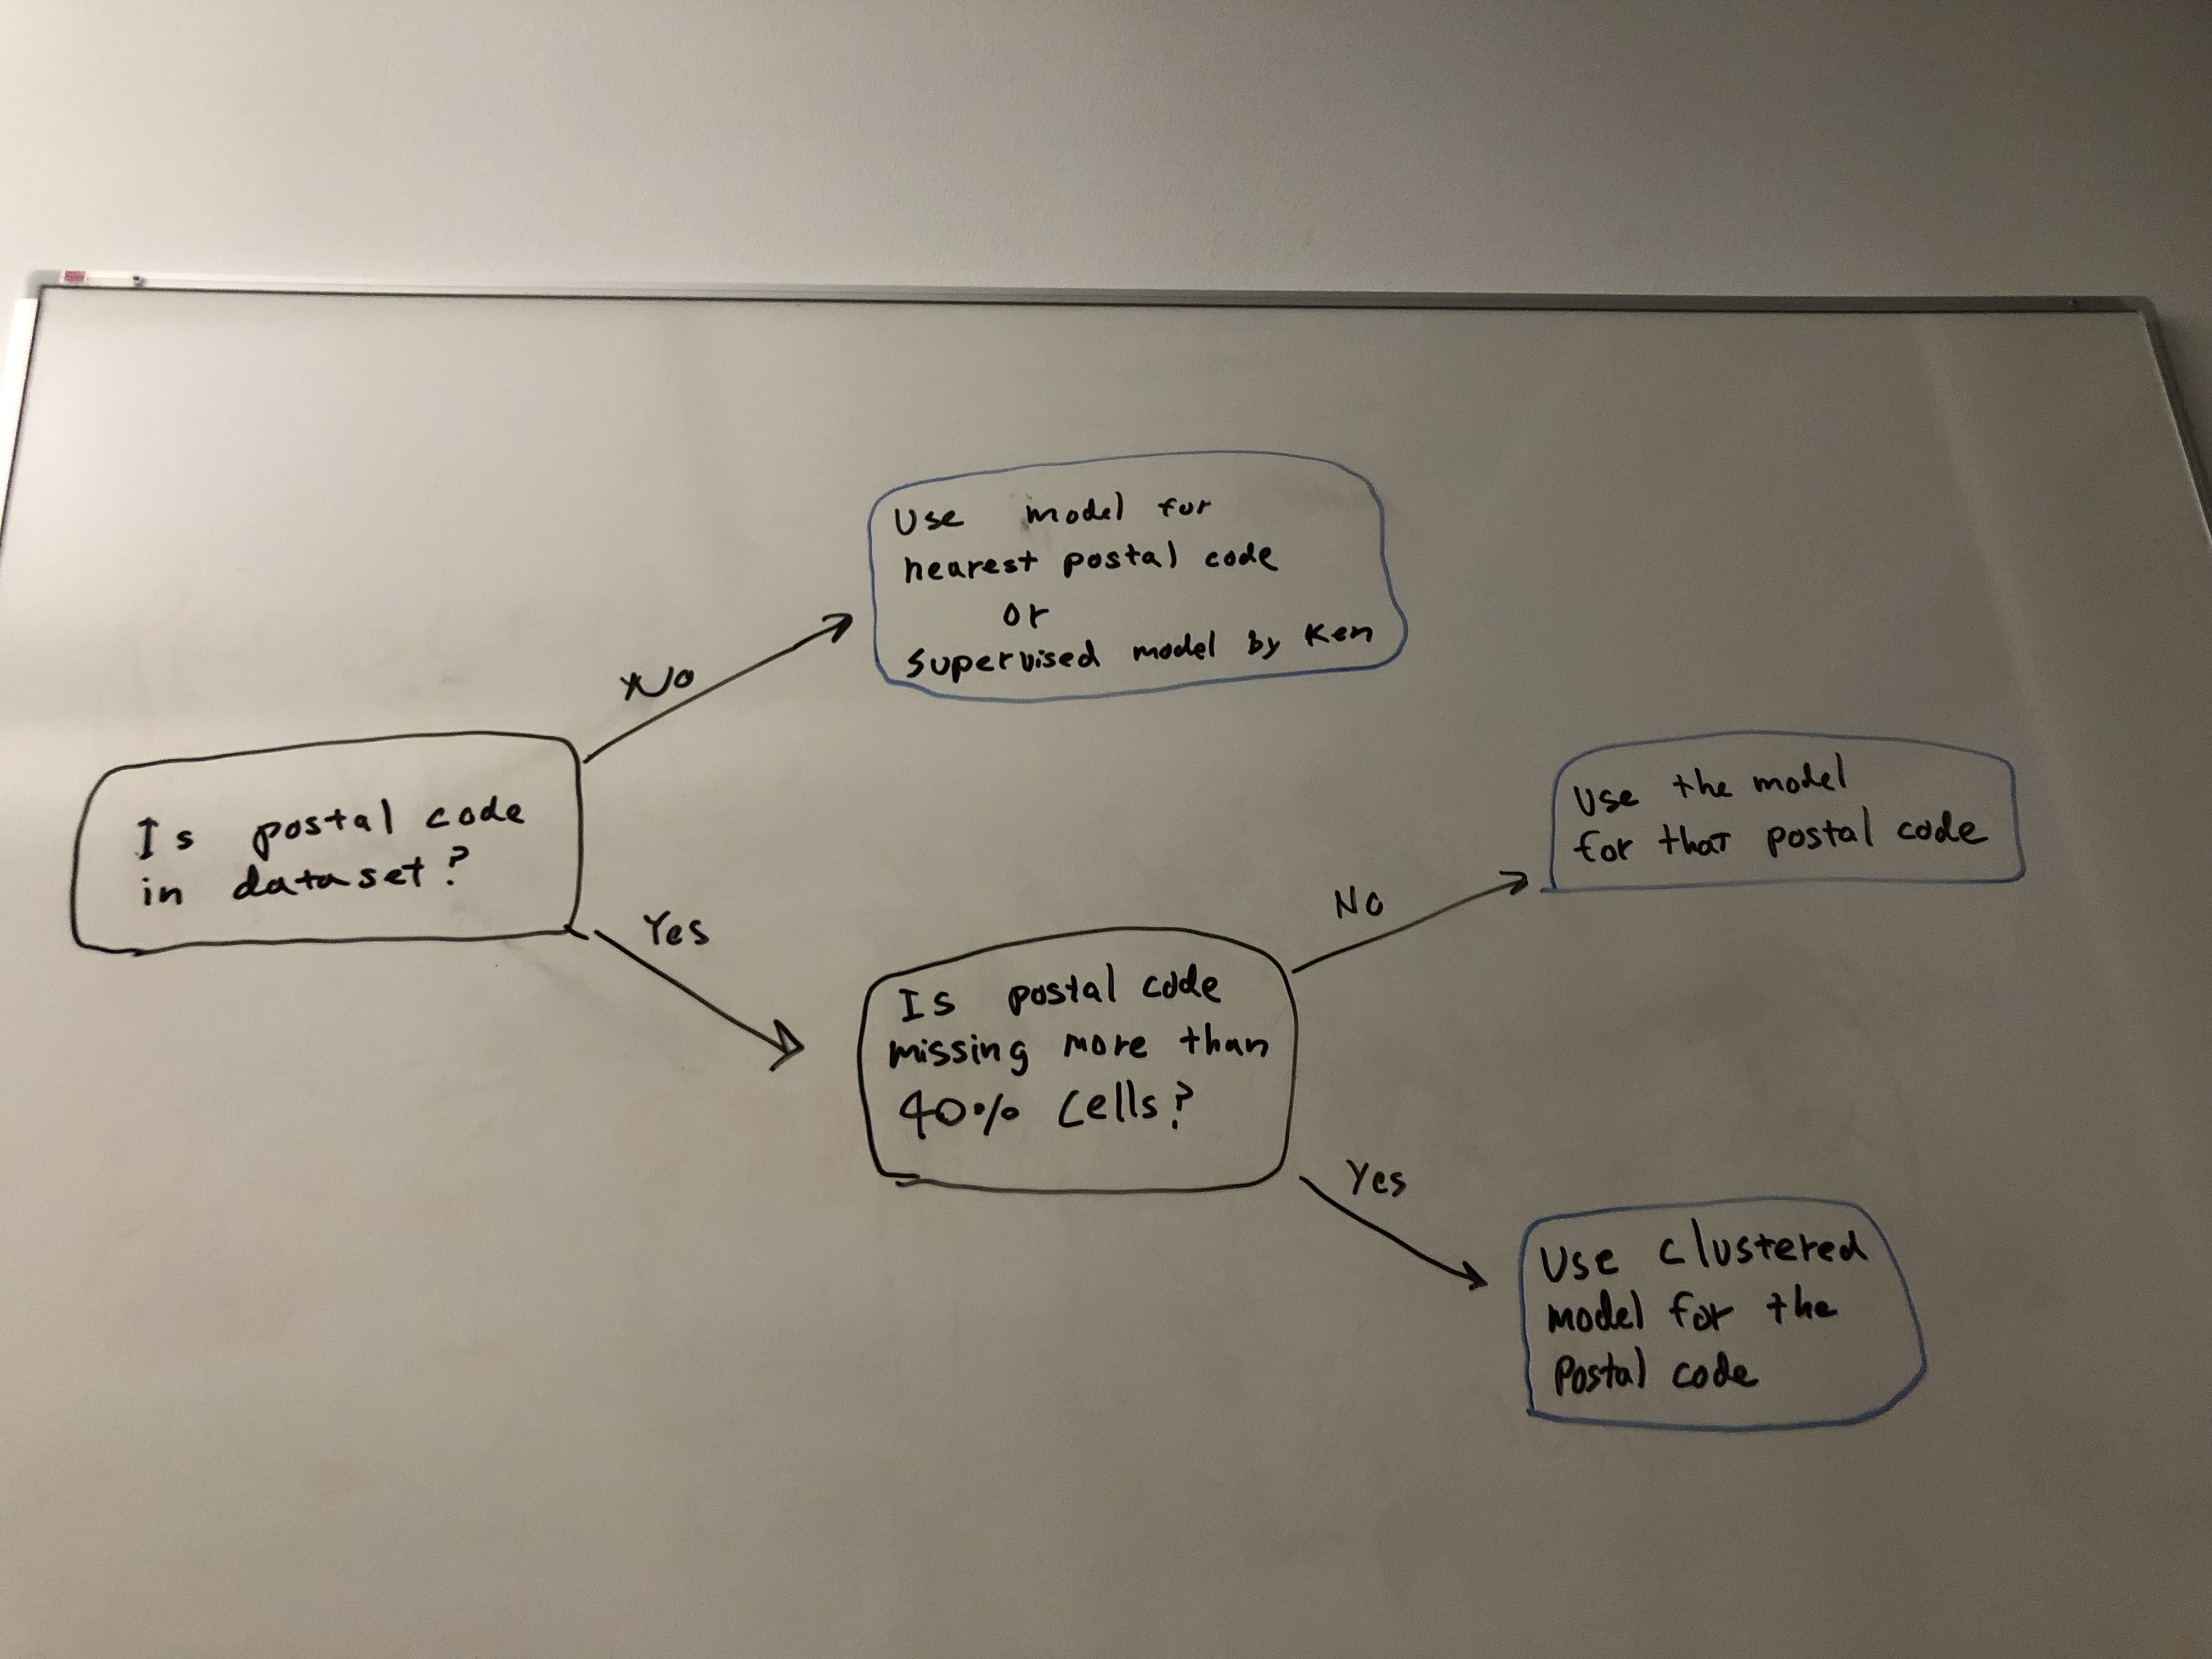

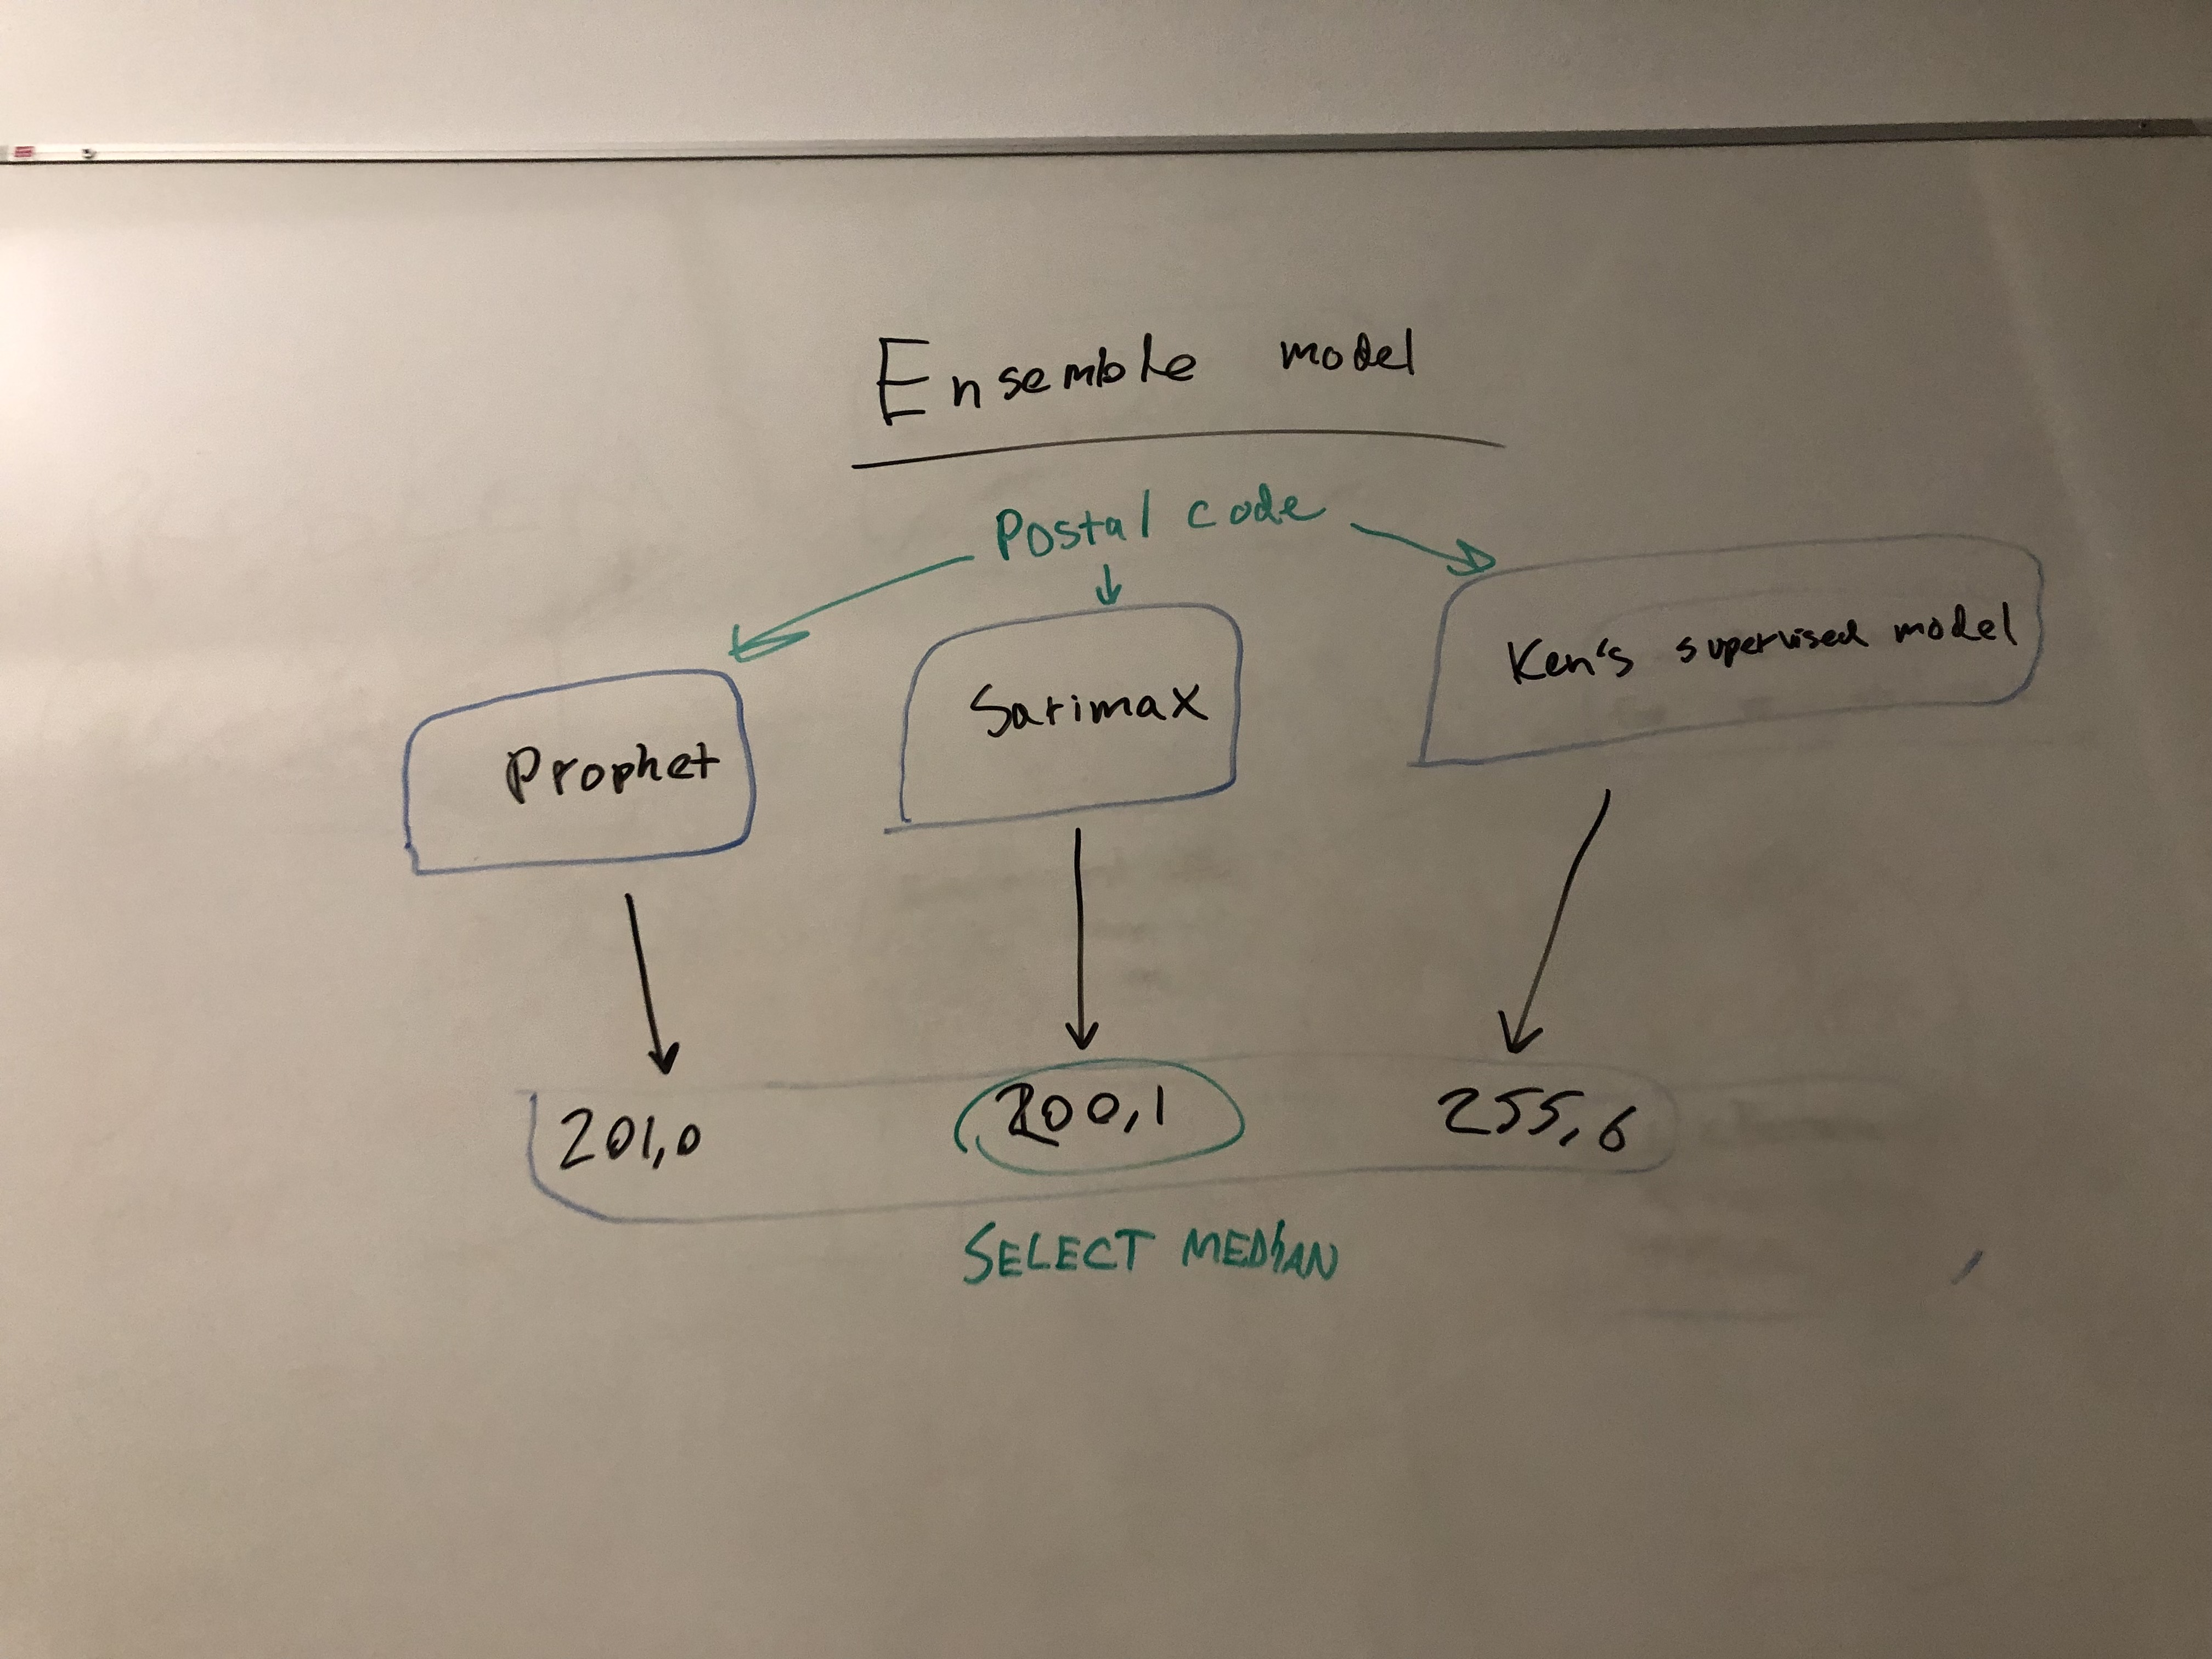

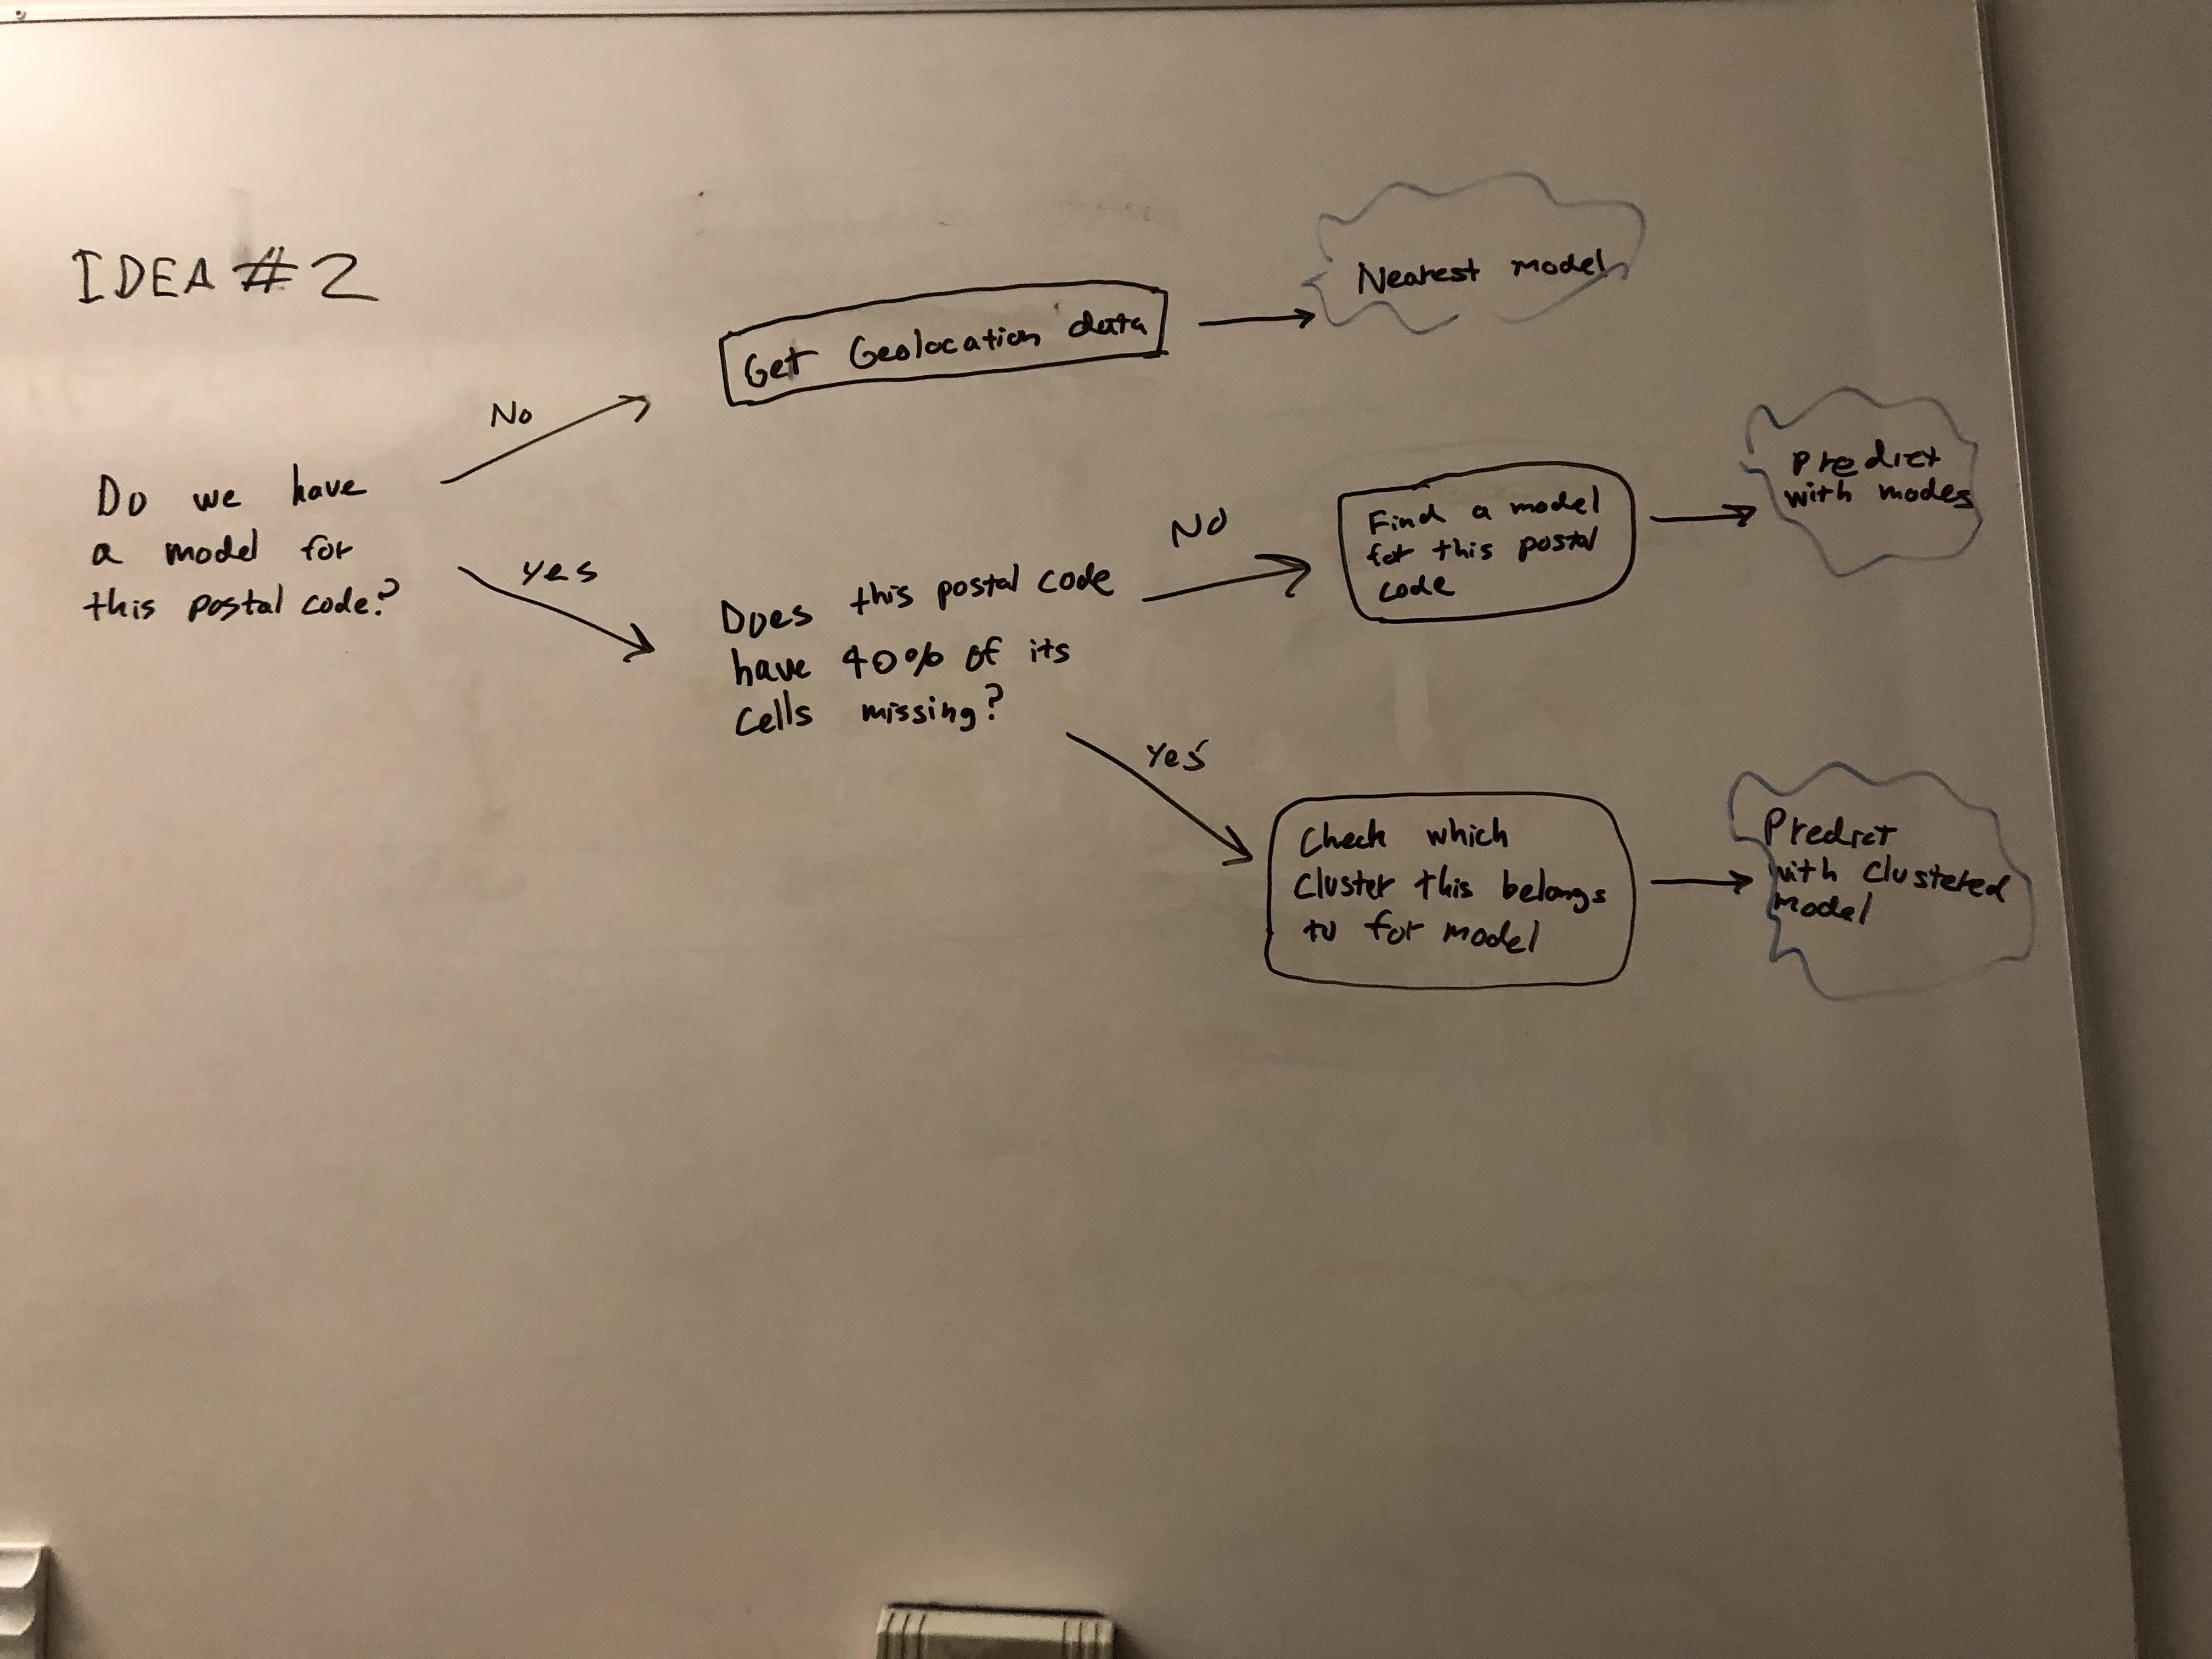

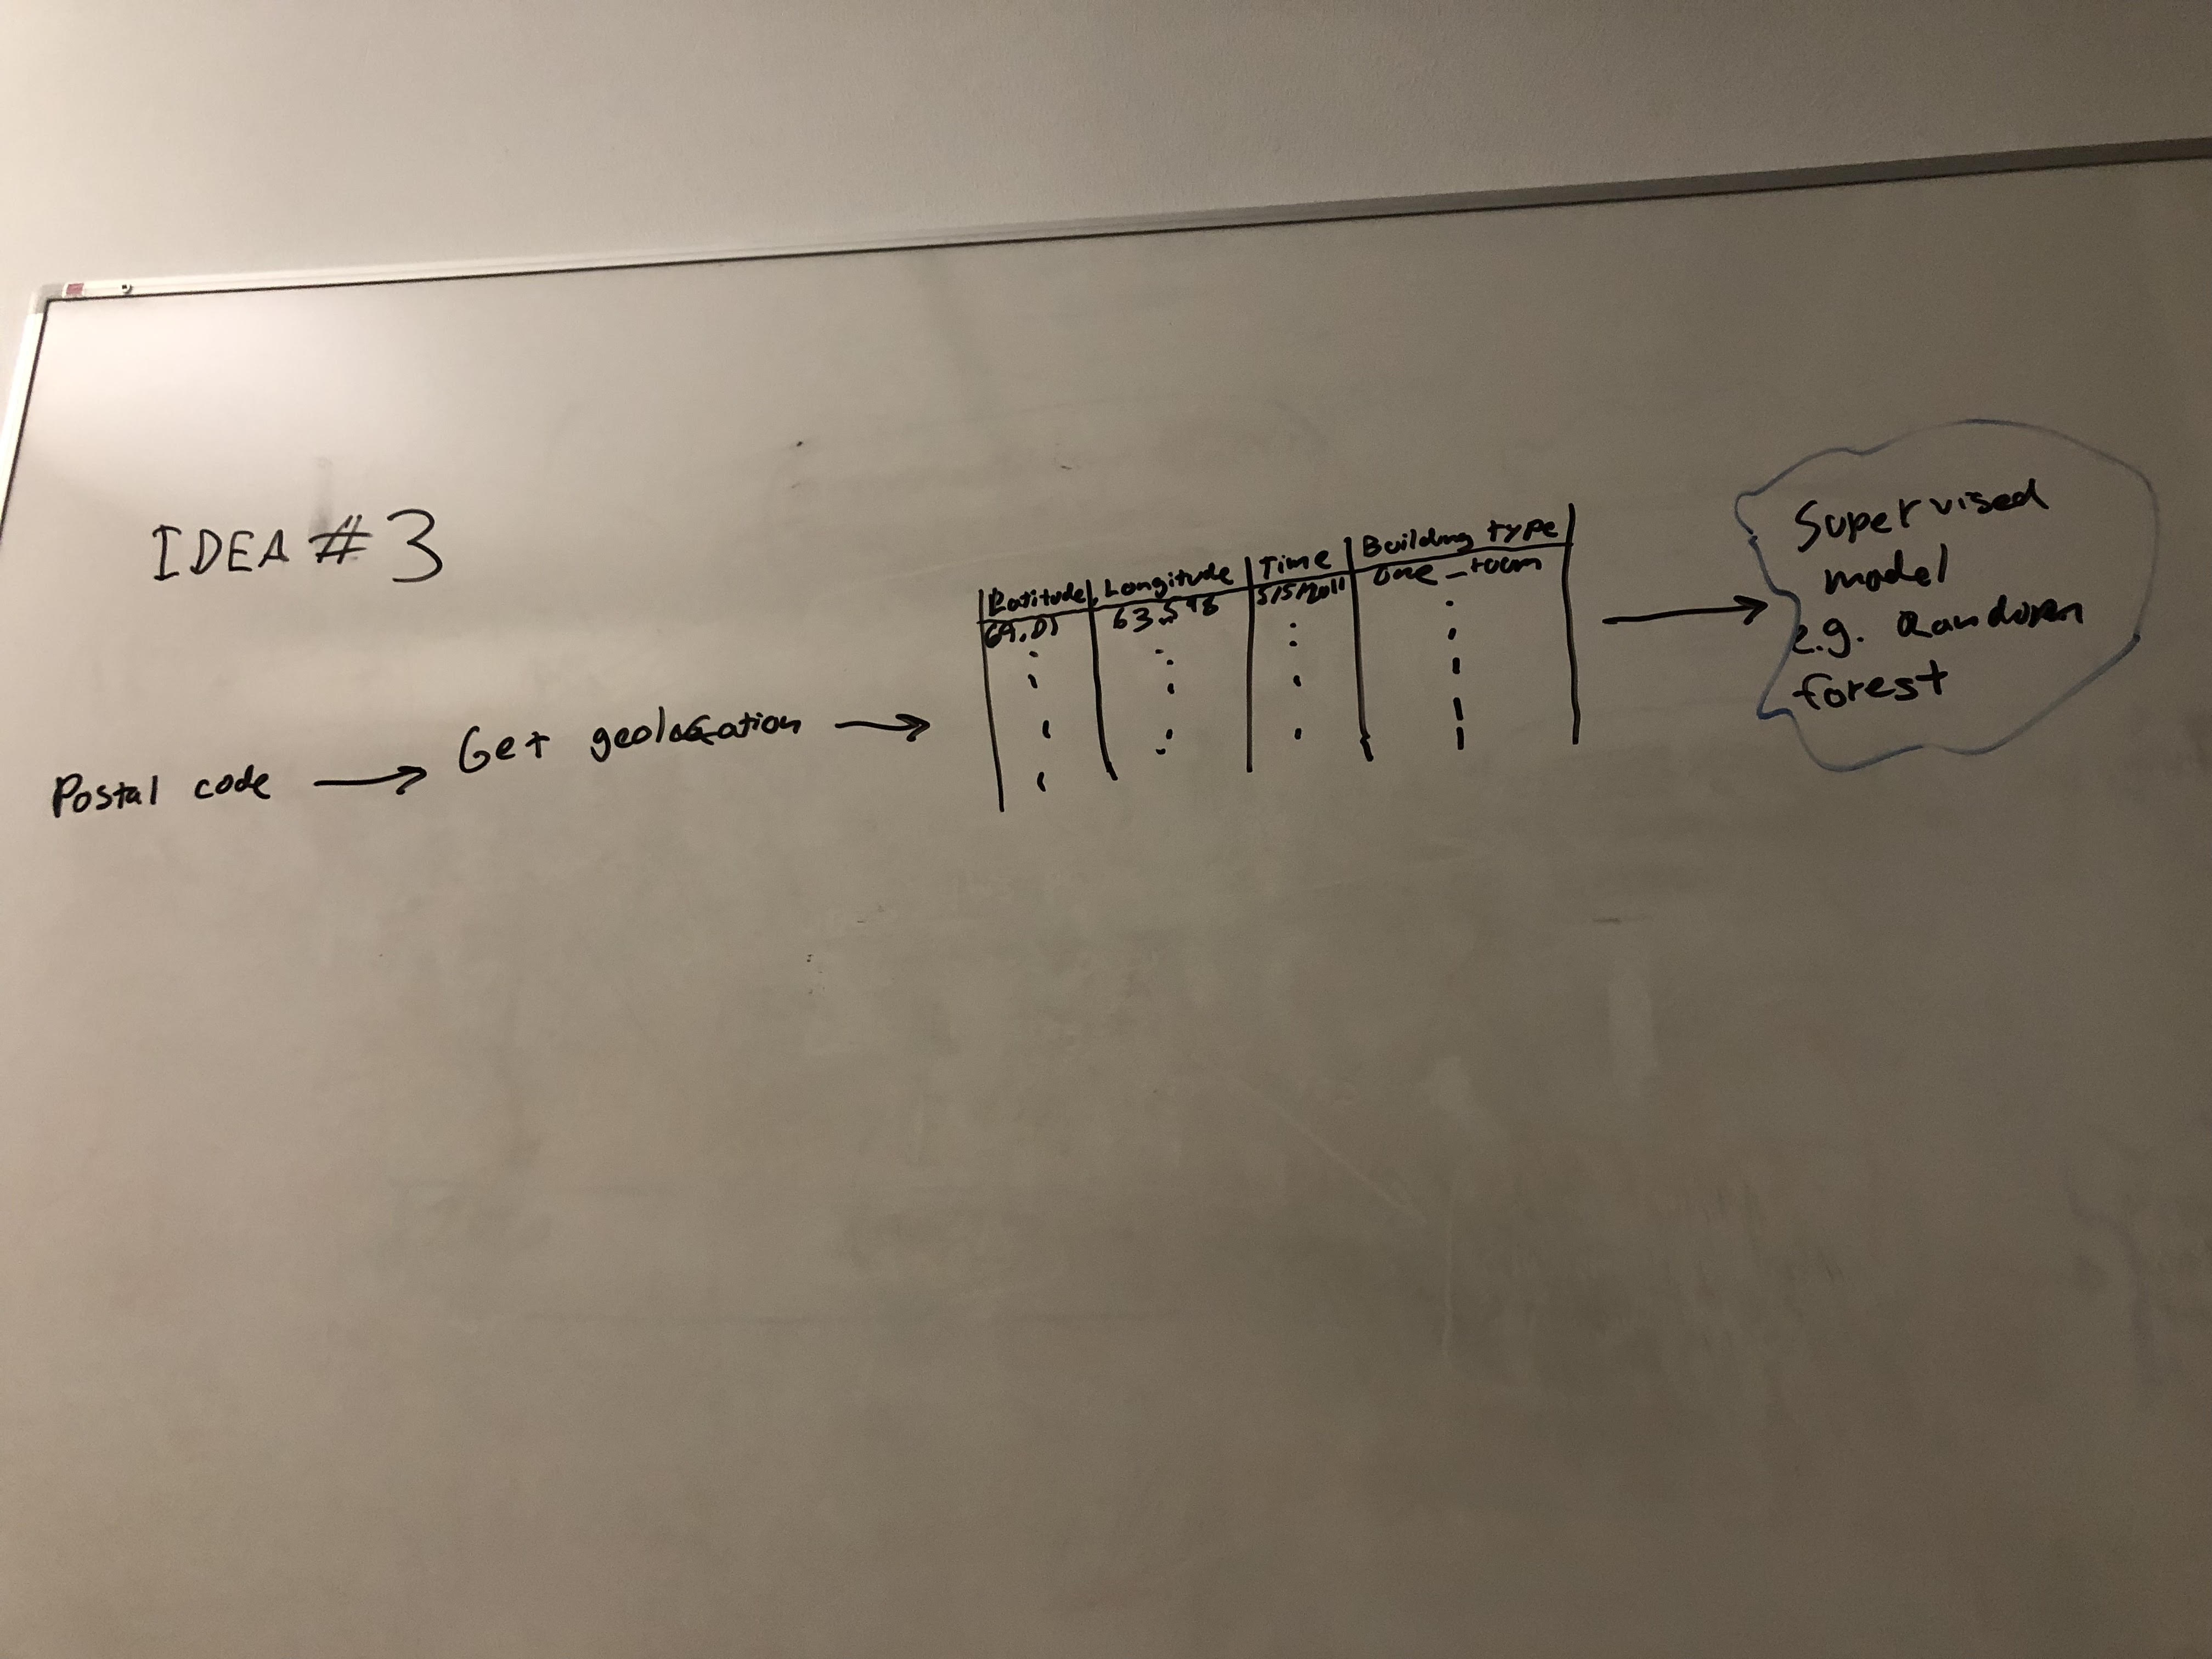